<a href="https://colab.research.google.com/github/BIKKYDTU/SkyHack-3.0-United-Airlines/blob/main/main_notebook_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
BASE = "/content/drive/MyDrive/skyhack/"


In [23]:
!ls "$BASE"


'Airports Data.csv'  'Flight Level Data.csv'	  PNR+Flight+Level+Data.csv
 Bag+Level+Data.csv   merged_flight_dataset.csv  'PNR Remark Level Data.csv'


In [24]:
!ls "/content/drive/MyDrive/skyhack"


'Airports Data.csv'  'Flight Level Data.csv'	  PNR+Flight+Level+Data.csv
 Bag+Level+Data.csv   merged_flight_dataset.csv  'PNR Remark Level Data.csv'


In [162]:
df_scored.to_csv("/content/flight_difficulty_scores.csv", index=False)


In [163]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [168]:
import pandas as pd
df_scored = pd.read_csv("flight_difficulty_scores.csv")


In [164]:
!find /content/drive/MyDrive -iname "flight_difficulty_scores.csv"


In [170]:
from google.colab import drive
drive.mount('/content/drive')
!find /content/drive/MyDrive -iname "flight_difficulty_scores.csv"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [173]:
# 🔁 Recreate flight_difficulty_scores.csv safely
import pandas as pd

# If you still have your merged/scored dataframe (e.g. df_final, df_combined, or df_scored_raw)
# Replace this with whichever variable holds your scored flights data
try:
    df_temp = df_scored  # or df_final / df_all / flights_merged — whichever has your full data
except NameError:
    raise ValueError("❌ You need to have your processed flights dataframe (e.g., df_scored) in memory first.")

# Example cleaning before saving
cols_needed = [c for c in df_temp.columns if c.strip() != ""]
df_temp = df_temp[cols_needed]

# Save to /content/ for consistency
out_path = "/content/flight_difficulty_scores.csv"
df_temp.to_csv(out_path, index=False)
print(f"✅ File successfully saved to {out_path}")


✅ File successfully saved to /content/flight_difficulty_scores.csv


In [174]:
df_scored = pd.read_csv("/content/flight_difficulty_scores.csv", low_memory=False)


In [177]:
# =========================
# Robust origin / flight / tier column resolution + groupby
# =========================
import os, re
import numpy as np
import pandas as pd

# ---- 1) Load the scored CSV from common locations
candidate_paths = [
    "/content/flight_difficulty_scores.csv",
    "/content/drive/MyDrive/flight_difficulty_scores.csv",
    "/content/drive/MyDrive/skyhack/flight_difficulty_scores.csv",
    "flight_difficulty_scores.csv",
]
csv_path = next((p for p in candidate_paths if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError(
        "Could not find 'flight_difficulty_scores.csv'.\n"
        "Tried:\n  - /content\n  - /content/drive/MyDrive\n  - /content/drive/MyDrive/skyhack\n  - current directory\n"
        "Fix: Re-run the cell that writes it (e.g., df_scored.to_csv('/content/flight_difficulty_scores.csv', index=False)) "
        "or mount Drive and adjust the path."
    )

df_scored = pd.read_csv(csv_path, low_memory=False)
print(f"✅ Loaded {csv_path}  (rows={len(df_scored):,}, cols={len(df_scored.columns)})")

# ---- 2) Helpers to normalize and resolve column names
def _normalize(col: str) -> str:
    c = col.strip().lower()
    c = re.sub(r"[\s\-]+", "_", c)     # spaces/dashes -> underscore
    c = re.sub(r"[^\w]", "", c)        # drop non-word chars
    return c

norm_map = {_normalize(c): c for c in df_scored.columns}
norm_cols = set(norm_map.keys())

def resolve_col(aliases, required=True):
    # exact normalized matches
    for a in aliases:
        if isinstance(a, str):
            na = _normalize(a)
            if na in norm_cols:
                return norm_map[na]
    # regex over normalized names
    for a in aliases:
        pat = a if isinstance(a, re.Pattern) else re.compile(_normalize(a))
        for nc in norm_cols:
            if pat.search(nc):
                return norm_map[nc]
    if required:
        raise KeyError(f"Missing column; none of {aliases} found. "
                       f"Available (first 25): {df_scored.columns.tolist()[:25]} ...")
    return None

# ---- 3) Resolve required columns (with robust alias sets)
origin_col = resolve_col([
    "origin", "from", "departure_station", "dep_station", r"^orig(in|in_station)?$"
])

dest_col = resolve_col([
    "destination", "to", "arrival_station", "dest_station", r"^dest(ination)?$"
])

flight_col = resolve_col([
    "flight_number", "flight_num", "flightno", r"^flt(_)?no$", r"^flight(id|_id)?$"
])

tier_col = resolve_col([
    "difficulty_bucket", "tier", "difficulty_tier", "difficulty", "risk_tier", "bucket"
], required=False)

# ---- 4) Build the difficult flag safely
tmp = df_scored.copy()

def difficulty_bool(series: pd.Series | None) -> pd.Series:
    if series is None:
        return pd.Series(0.0, index=tmp.index, dtype="float")
    s = series.astype(str).str.strip().str.lower()

    # label mapping
    hard_labels = {"difficult", "hard", "very hard", "high", "red"}
    easy_labels = {"easy", "simple", "low", "green"}

    out = pd.Series(np.nan, index=series.index, dtype="float")
    out = np.where(s.isin(hard_labels), 1.0, out)
    out = np.where(s.isin(easy_labels), 0.0, out)

    # numeric heuristics
    with np.errstate(all="ignore"):
        sn = pd.to_numeric(series, errors="ignore")  # keep non-numeric as-is
    if isinstance(sn, pd.Series):
        sn_num = pd.to_numeric(sn, errors="coerce")
        if sn_num.notna().any():
            uniq = set(sn_num.dropna().unique().tolist())
            if uniq.issubset({0, 1}):
                out = np.where(sn_num == 1, 1.0, np.where(np.isnan(out), 0.0, out))
            else:
                out = np.where(sn_num >= 2, 1.0, np.where(np.isnan(out), 0.0, out))

    # fallback
    out = np.where(pd.isna(out), 0.0, out).astype(float)
    return pd.Series(out, index=series.index)

tmp["_is_difficult"] = difficulty_bool(tmp[tier_col] if tier_col in tmp.columns else None)

# ---- 5) Group by origin (drop NA origins to avoid a NaN row)
by_origin = (
    tmp.dropna(subset=[origin_col])
       .groupby(origin_col, as_index=False)
       .agg(
           n_flights=(flight_col, "count"),
           difficult_rate=("_is_difficult", "mean"),
       )
       .sort_values("difficult_rate", ascending=False, kind="mergesort")
       .reset_index(drop=True)
)

print("\n🔎 Using columns:")
print(f"  origin = {origin_col}")
print(f"  dest   = {dest_col}")
print(f"  flight = {flight_col}")
print(f"  tier   = {tier_col}")

print("\n✅ Top 10 origins by difficult_rate:")
display(by_origin.head(10))


✅ Loaded /content/flight_difficulty_scores.csv  (rows=8,099, cols=39)

🔎 Using columns:
  origin = origin
  dest   = destination
  flight = flight_num
  tier   = difficulty_bucket

✅ Top 10 origins by difficult_rate:


/tmp/ipython-input-3637512998.py:90: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  sn = pd.to_numeric(series, errors="ignore")  # keep non-numeric as-is


,origin,n_flights,difficult_rate
0,ORD,8099,0.0


In [181]:
# =========================
# Load df_scored robustly, then compute by_origin
# =========================
import os, re, sys
import numpy as np
import pandas as pd

# ---------- A) Get df_scored without crashing ----------
def already_has_df_scored():
    return "df_scored" in globals() and isinstance(globals()["df_scored"], pd.DataFrame)

def in_colab():
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

def ensure_drive_mounted():
    if not os.path.isdir("/content/drive"):
        return
    # if not mounted, try to mount
    if not os.path.exists("/content/drive/MyDrive"):
        try:
            from google.colab import drive
            drive.mount("/content/drive")
        except Exception:
            pass

def find_in_drive():
    ensure_drive_mounted()
    root = "/content/drive/MyDrive"
    if not os.path.exists(root):
        return None
    target = "flight_difficulty_scores.csv"
    for dirpath, _, filenames in os.walk(root):
        if target in filenames:
            return os.path.join(dirpath, target)
    return None

CSV_CANDIDATES = [
    "/content/flight_difficulty_scores.csv",
    "/content/drive/MyDrive/flight_difficulty_scores.csv",
    "/content/drive/MyDrive/skyhack/flight_difficulty_scores.csv",
    "flight_difficulty_scores.csv",
]

if already_has_df_scored():
    _src = "<in-memory>"
else:
    # try known paths
    csv_path = next((p for p in CSV_CANDIDATES if os.path.exists(p)), None)
    if csv_path is None:
        # try searching entire Drive
        csv_path = find_in_drive()
    if csv_path is None and in_colab():
        # last resort: ask for upload interactively (Colab only)
        try:
            from google.colab import files
            print("📤 Upload 'flight_difficulty_scores.csv' (Colab file picker will open)...")
            uploaded = files.upload()
            if "flight_difficulty_scores.csv" in uploaded:
                csv_path = "flight_difficulty_scores.csv"
        except Exception:
            pass

    if csv_path is None:
        raise FileNotFoundError(
            "Could not locate 'flight_difficulty_scores.csv'.\n"
            "Fix one of these:\n"
            "  1) Re-run the cell that creates it: df_scored.to_csv('/content/flight_difficulty_scores.csv', index=False)\n"
            "  2) Mount Drive and place it at /content/drive/MyDrive/skyhack/flight_difficulty_scores.csv\n"
            "  3) In Colab, upload it when prompted.\n"
        )

    df_scored = pd.read_csv(csv_path, low_memory=False)
    _src = csv_path

print(f"✅ Using df_scored from: {_src}  (rows={len(df_scored):,}, cols={len(df_scored.columns)})")

# ---------- B) Resolve columns robustly ----------
def _normalize(col: str) -> str:
    c = col.strip().lower()
    c = re.sub(r"[\s\-]+", "_", c)
    c = re.sub(r"[^\w]", "", c)
    return c

norm_map = {_normalize(c): c for c in df_scored.columns}
norm_cols = set(norm_map.keys())

def resolve_col(aliases, required=True):
    # exact normalized match
    for a in aliases:
        if isinstance(a, str):
            na = _normalize(a)
            if na in norm_cols:
                return norm_map[na]
    # regex search
    for a in aliases:
        pat = a if hasattr(a, "search") else re.compile(_normalize(a))
        for nc in norm_cols:
            if pat.search(nc):
                return norm_map[nc]
    if required:
        raise KeyError(f"Missing column: none of {aliases} found. "
                       f"Available (first 25): {df_scored.columns.tolist()[:25]} ...")
    return None

origin_col = resolve_col(["origin", "from", "departure_station", "dep_station", r"^orig(in|in_station)?$"])
dest_col   = resolve_col(["destination", "to", "arrival_station", "dest_station", r"^dest(ination)?$"])
flight_col = resolve_col(["flight_number", "flight_num", "flightno", r"^flt(_)?no$", r"^flight(id|_id)?$"])
tier_col   = resolve_col(["difficulty_bucket", "tier", "difficulty_tier", "difficulty", "risk_tier", "bucket"], required=False)

# ---------- C) Difficult flag (works for labels or numeric tiers) ----------
tmp = df_scored.copy()

def difficulty_bool(series: pd.Series | None) -> pd.Series:
    if series is None:
        return pd.Series(0.0, index=tmp.index, dtype=float)
    s = series.astype(str).str.strip().str.lower()

    hard = {"difficult", "hard", "very hard", "high", "red"}
    easy = {"easy", "simple", "low", "green"}

    out = pd.Series(np.nan, index=series.index, dtype=float)
    out = np.where(s.isin(hard), 1.0, out)
    out = np.where(s.isin(easy), 0.0, out)

    # numeric heuristic
    sn = pd.to_numeric(series, errors="coerce")
    if sn.notna().any():
        uniq = set(sn.dropna().unique().tolist())
        if uniq.issubset({0, 1}):
            out = np.where(sn == 1, 1.0, np.where(np.isnan(out), 0.0, out))
        else:
            out = np.where(sn >= 2, 1.0, np.where(np.isnan(out), 0.0, out))

    return pd.Series(np.where(pd.isna(out), 0.0, out).astype(float), index=series.index)

tmp["_is_difficult"] = difficulty_bool(tmp[tier_col] if tier_col in tmp.columns else None)

# ---------- D) Group & sort ----------
by_origin = (
    tmp.dropna(subset=[origin_col])
       .groupby(origin_col, as_index=False)
       .agg(
           n_flights=(flight_col, "count"),
           difficult_rate=("_is_difficult", "mean"),
       )
       .sort_values("difficult_rate", ascending=False, kind="mergesort")
       .reset_index(drop=True)
)

print("\n🔎 Columns used")
print(f"  origin = {origin_col}")
print(f"  dest   = {dest_col}")
print(f"  flight = {flight_col}")
print(f"  tier   = {tier_col}")

print("\n✅ Top 10 origins by difficult_rate:")
try:
    from IPython.display import display
    display(by_origin.head(10))
except Exception:
    print(by_origin.head(10))


✅ Using df_scored from: <in-memory>  (rows=8,099, cols=39)

🔎 Columns used
  origin = origin
  dest   = destination
  flight = flight_num
  tier   = difficulty_bucket

✅ Top 10 origins by difficult_rate:


,origin,n_flights,difficult_rate
0,ORD,8099,0.0


In [179]:
import pandas as pd

def resolve(df, choices, label):
    for c in choices:
        if c in df.columns:
            return c
    raise KeyError(f"Missing {label}. Need one of {choices}. "
                   f"Have: {df.columns.tolist()[:25]}...")

# Resolve columns from aliases
dest_col   = resolve(df_scored, ["destination","scheduled_arrival_station_code","dest"], "destination")
flight_col = resolve(df_scored, ["flight_number","flight_num","flight_no","fn"], "flight id")
tier_col   = resolve(df_scored, ["difficulty_bucket","tier"], "difficulty bucket")
origin_col = resolve(df_scored, ["origin","scheduled_departure_station_code","orig"], "origin")

# Build difficult flag
tmp = df_scored.copy()
tmp["_is_difficult"] = (tmp[tier_col].astype(str) == "Difficult").astype(float)

# Group and compute metrics
grp = tmp.groupby(dest_col, dropna=False)
n_flights_series = grp[flight_col].count().rename("n_flights")
difficult_rate_series = grp["_is_difficult"].mean().rename("difficult_rate")

by_dest = (
    pd.concat([n_flights_series, difficult_rate_series], axis=1)
      .reset_index()
      .rename(columns={dest_col: "destination"})
      .sort_values("difficult_rate", ascending=False)
)

by_dest.head(10)


,destination,n_flights,difficult_rate
0,ABE,29,0.0
1,ABQ,28,0.0
2,ACK,4,0.0
3,ALB,44,0.0
4,AMS,17,0.0
5,ANC,30,0.0
6,ASE,17,0.0
7,ATH,15,0.0
8,ATL,59,0.0
9,ATW,85,0.0


In [31]:
import pandas as pd

BASE = "/content/drive/MyDrive/skyhack/"

airports_df    = pd.read_csv(BASE + "Airports Data.csv")
bag_df         = pd.read_csv(BASE + "Bag+Level+Data.csv")
flight_df      = pd.read_csv(BASE + "Flight Level Data.csv")
pnr_flight_df  = pd.read_csv(BASE + "PNR+Flight+Level+Data.csv")
pnr_remark_df  = pd.read_csv(BASE + "PNR Remark Level Data.csv")

# Quick check
print("Airports:", airports_df.shape)
print("Bag:", bag_df.shape)
print("Flight:", flight_df.shape)
print("PNR Flight:", pnr_flight_df.shape)
print("PNR Remark:", pnr_remark_df.shape)


Airports: (5612, 2)
Bag: (687245, 8)
Flight: (8099, 15)
PNR Flight: (687878, 12)
PNR Remark: (51698, 4)


In [182]:
df_scored.to_csv("test_bikky.csv", index=False)
from google.colab import files
files.download("test_bikky.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
import pandas as pd
import numpy as np

flights      = pd.read_csv(BASE + "Flight Level Data.csv", low_memory=False)
pnr_flights  = pd.read_csv(BASE + "PNR+Flight+Level+Data.csv", low_memory=False)
pnr_remarks  = pd.read_csv(BASE + "PNR Remark Level Data.csv", low_memory=False)
bags         = pd.read_csv(BASE + "Bag+Level+Data.csv", low_memory=False)
airports     = pd.read_csv(BASE + "Airports Data.csv", low_memory=False)

print("Loaded:", flights.shape, pnr_flights.shape, pnr_remarks.shape, bags.shape, airports.shape)


Loaded: (8099, 15) (687878, 12) (51698, 4) (687245, 8) (5612, 2)


In [33]:
# =========================
# SELF-HEAL FOR pnr_flights
# - Cleans columns
# - Auto-detects & renames keys
# - Rebuilds pnr_agg
# =========================
import re
import numpy as np
import pandas as pd

def clean_cols(df):
    df = df.copy()
    df.columns = (df.columns.astype(str)
                  .str.strip()
                  .str.replace(r"\s+","_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]+","", regex=True)
                  .str.lower())
    return df

def pick(df, options, required=False, label=""):
    """Pick first matching column from list of exact names or regex patterns."""
    cols = list(df.columns)
    # exact first
    for c in options:
        if c in df.columns:
            return c
    # regex fallback
    for pat in options:
        try:
            rx = re.compile(pat)
        except re.error:
            continue
        for c in cols:
            if rx.fullmatch(c) or rx.search(c):
                return c
    if required:
        raise KeyError(f"[{label}] Could not find any of {options} in columns: {cols[:25]} ...")
    return None

# 0) Show raw columns (for your sanity)
print("PNR Flight Level - ORIGINAL columns (first 30):")
print(list(pnr_flights.columns)[:30])

# 1) Clean columns
pnr_flights = clean_cols(pnr_flights)
pnr_remarks = clean_cols(pnr_remarks) if 'pnr_remarks' in globals() else pd.DataFrame()

print("\nPNR Flight Level - CLEANED columns (first 30):")
print(list(pnr_flights.columns)[:30])

# 2) Auto-detect key columns in pnr_flights
pnr_col   = pick(pnr_flights, ["pnr","record_locator","booking_ref","confirmation","pnrid"], required=True, label="pnr")
fnum_col  = pick(pnr_flights, ["flight_num","flightnumber","flight_number","flt_num","fltno", r"^flight.*num.*$"], required=True, label="flight_num")
fdate_col = pick(pnr_flights, ["flight_date","dep_date","departure_date","scheduled_departure_date_local","date", r"^.*depart.*date.*$"], required=True, label="flight_date")
orig_col  = pick(pnr_flights, ["origin","dep_station","departure_station","scheduled_departure_station_code", r"^orig(in)?$"], required=True, label="origin")
dest_col  = pick(pnr_flights, ["destination","arr_station","arrival_station","scheduled_arrival_station_code", r"^dest(in)?$"], required=True, label="destination")

print("\n🔎 Chosen column mapping for pnr_flights:")
print({
    "pnr": pnr_col,
    "flight_num": fnum_col,
    "flight_date": fdate_col,
    "origin": orig_col,
    "destination": dest_col
})

# 3) Standardize pnr_flights to canonical schema
pnr_flights_std = pnr_flights.rename(columns={
    pnr_col:"pnr", fnum_col:"flight_num", fdate_col:"flight_date", orig_col:"origin", dest_col:"destination"
}).copy()

pnr_flights_std["pnr"]        = pnr_flights_std["pnr"].astype(str).str.upper().str.strip()
pnr_flights_std["flight_num"] = pnr_flights_std["flight_num"].astype(str).str.strip()
pnr_flights_std["flight_date"]= pd.to_datetime(pnr_flights_std["flight_date"], errors="coerce").dt.date
pnr_flights_std["origin"]     = pnr_flights_std["origin"].astype(str).str.upper().str.strip()
pnr_flights_std["destination"]= pnr_flights_std["destination"].astype(str).str.upper().str.strip()

# 4) PNR remarks → specials
if not pnr_remarks.empty:
    # pick remark code if present
    remark_col = pick(pnr_remarks, ["remark_code","ssr","ssr_code","code","remark"], required=False, label="remark_code")
    if remark_col and remark_col != "remark_code":
        pnr_remarks = pnr_remarks.rename(columns={remark_col:"remark_code"})
    pnr_col_r = pick(pnr_remarks, ["pnr","record_locator","booking_ref","confirmation","pnrid"], required=True, label="pnr_remarks.pnr")
    pnr_remarks["pnr"] = pnr_remarks[pnr_col_r].astype(str).str.upper().str.strip()

    special_codes = {"WCHR","WCHS","WCHC","UMNR","PET","PETS","LANG","BLND","DEAF"}
    if "remark_code" in pnr_remarks.columns:
        pnr_remarks["is_special"] = pnr_remarks["remark_code"].astype(str).str.upper().isin(special_codes).astype(int)
    else:
        pnr_remarks["is_special"] = 0

    pnr_specials = (pnr_remarks.groupby("pnr", dropna=False)["is_special"]
                    .sum().rename("pnr_special_count").reset_index())
else:
    pnr_specials = pd.DataFrame(columns=["pnr","pnr_special_count"])

# 5) Merge specials into pnr_flights_std
pnr_f_with_specs = pnr_flights_std.merge(pnr_specials, on="pnr", how="left")
pnr_f_with_specs["pnr_special_count"] = pnr_f_with_specs["pnr_special_count"].fillna(0)

# 6) Aggregate to flight level → pnr_agg
pnr_by_flight = (pnr_flights_std
    .groupby(["flight_num","flight_date","origin","destination"], dropna=False)
    .agg(pnr_count=("pnr","nunique"),
         pnr_rows=("pnr","size"))        # if you later have pax_count, replace with its sum
    .reset_index())

specials_by_flight = (pnr_f_with_specs
    .groupby(["flight_num","flight_date","origin","destination"], dropna=False)["pnr_special_count"]
    .sum().rename("specials_total").reset_index())

pnr_agg = (pnr_by_flight
           .merge(specials_by_flight, on=["flight_num","flight_date","origin","destination"], how="left")
           .fillna({"specials_total":0}))

print("\n✅ Built pnr_agg:", pnr_agg.shape)
pnr_agg.head()


PNR Flight Level - ORIGINAL columns (first 30):
['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'record_locator', 'pnr_creation_date', 'total_pax', 'is_child', 'basic_economy_ind', 'is_stroller_user', 'lap_child_count']

PNR Flight Level - CLEANED columns (first 30):
['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'record_locator', 'pnr_creation_date', 'total_pax', 'is_child', 'basic_economy_ind', 'is_stroller_user', 'lap_child_count']

🔎 Chosen column mapping for pnr_flights:
{'pnr': 'record_locator', 'flight_num': 'flight_number', 'flight_date': 'scheduled_departure_date_local', 'origin': 'scheduled_departure_station_code', 'destination': 'scheduled_arrival_station_code'}

✅ Built pnr_agg: (8071, 7)


,flight_num,flight_date,origin,destination,pnr_count,pnr_rows,specials_total
0,1006,2025-08-01,ORD,LGA,123,128,0.0
1,1006,2025-08-02,ORD,LGA,116,126,0.0
2,1006,2025-08-03,ORD,LGA,129,133,0.0
3,1006,2025-08-04,ORD,LGA,145,148,0.0
4,1006,2025-08-05,ORD,LGA,120,122,0.0


In [34]:
# Define PNR_FLIGHT_KEYS within this cell
PNR_FLIGHT_KEYS = dict(
    pnr = "record_locator",                       # booking code
    flight_num = "flight_number",
    flight_date = "scheduled_departure_date_local",
    origin = "scheduled_departure_station_code",
    destination = "scheduled_arrival_station_code"
)

# Define PNR_REMARK_KEYS within this cell
PNR_REMARK_KEYS = dict(
    pnr = "record_locator",
    remark_code = "special_service_request",       # e.g., WCHR/UMNR/etc
    remark_text = "special_service_request"  # free text if available
)


# PNR counts
pnr_by_flight = (pnr_flights
    .groupby([PNR_FLIGHT_KEYS["flight_num"], PNR_FLIGHT_KEYS["flight_date"], PNR_FLIGHT_KEYS["origin"], PNR_FLIGHT_KEYS["destination"]], dropna=False)
    .agg(pnr_count=(PNR_FLIGHT_KEYS["pnr"],"nunique"), # Use the key from the dictionary
         pax_booked=(PNR_FLIGHT_KEYS["pnr"],"size")) # Use the key from the dictionary
    .reset_index())

# Specials from remarks
special_codes = ["WCHR","WCHS","WCHC","UMNR","PET","PETS","LANG","BLND","DEAF"]
# Assuming pnr_remarks also has cleaned columns and 'pnr' maps to 'record_locator'
# and 'remark_code' maps to 'special_service_request'
pnr_remarks["is_special"] = pnr_remarks[PNR_REMARK_KEYS["remark_code"]].isin(special_codes).astype(int)


# Assuming pnr_remarks also has a 'pnr' column after cleaning, mapping to 'record_locator'
pnr_specials = (pnr_remarks.groupby(PNR_REMARK_KEYS["pnr"], dropna=False)["is_special"].sum()
                .rename("pnr_special_count").reset_index())


# Assuming pnr_flights has a 'pnr' column after cleaning, mapping to 'record_locator'
pnr_f_with_specs = pnr_flights.merge(pnr_specials, on=PNR_FLIGHT_KEYS["pnr"], how="left").fillna(0)


specials_by_flight = (pnr_f_with_specs
    .groupby([PNR_FLIGHT_KEYS["flight_num"], PNR_FLIGHT_KEYS["flight_date"], PNR_FLIGHT_KEYS["origin"], PNR_FLIGHT_KEYS["destination"]], dropna=False)["pnr_special_count"]
    .sum().rename("specials_total").reset_index())

# Final aggregate
pnr_agg = pnr_by_flight.merge(specials_by_flight,
                              left_on=[PNR_FLIGHT_KEYS["flight_num"], PNR_FLIGHT_KEYS["flight_date"], PNR_FLIGHT_KEYS["origin"], PNR_FLIGHT_KEYS["destination"]],
                              right_on=[PNR_FLIGHT_KEYS["flight_num"], PNR_FLIGHT_KEYS["flight_date"], PNR_FLIGHT_KEYS["origin"], PNR_FLIGHT_KEYS["destination"]],
                              how="left").fillna(0)

In [35]:
# ---- Bag level → per-flight aggregates ----
bag_agg = (bags
    .groupby(["flight_number","scheduled_departure_date_local","scheduled_departure_station_code","scheduled_arrival_station_code"], dropna=False)
    .agg(checked_bags=("bag_tag_unique_number","count"),
         transfer_bags=("bag_type", lambda x: (x=="Transfer").sum()),
         bag_records=("bag_tag_unique_number","count"))
    .reset_index())
bag_agg["transfer_ratio"] = np.where(bag_agg["checked_bags"]>0,
                                     bag_agg["transfer_bags"]/bag_agg["checked_bags"],
                                     np.nan)

merged = (flights
          .merge(pnr_agg, on=["flight_number","scheduled_departure_date_local","scheduled_departure_station_code","scheduled_arrival_station_code"], how="left")
          .merge(bag_agg, on=["flight_number","scheduled_departure_date_local","scheduled_departure_station_code","scheduled_arrival_station_code"], how="left"))

In [36]:
# Dimensions of the dataset
merged.shape

(8099, 22)

In [37]:
# Column names and data types
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8099 entries, 0 to 8098
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   company_id                          8099 non-null   object 
 1   flight_number                       8099 non-null   int64  
 2   scheduled_departure_date_local      8099 non-null   object 
 3   scheduled_departure_station_code    8099 non-null   object 
 4   scheduled_arrival_station_code      8099 non-null   object 
 5   scheduled_departure_datetime_local  8099 non-null   object 
 6   scheduled_arrival_datetime_local    8099 non-null   object 
 7   actual_departure_datetime_local     8099 non-null   object 
 8   actual_arrival_datetime_local       8099 non-null   object 
 9   total_seats                         8099 non-null   int64  
 10  fleet_type                          8099 non-null   object 
 11  carrier                             8099 no

In [38]:
# Quick peek at first few rows
merged.head()

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,scheduled_ground_time_minutes,actual_ground_time_minutes,minimum_turn_minutes,pnr_count,pax_booked,specials_total,checked_bags,transfer_bags,bag_records,transfer_ratio
0,OO,4792,2025-08-04,ORD,ROA,2025-08-04T17:57:00Z,2025-08-04T21:04:00Z,2025-08-04T18:04:00Z,2025-08-04T20:52:00Z,76,...,42,34,34,54,55,0.0,42.0,20.0,42.0,0.476190
1,UA,920,2025-08-03,ORD,LHR,2025-08-03T18:05:00Z,2025-08-04T08:20:00Z,2025-08-03T18:27:00Z,2025-08-04T08:06:00Z,167,...,235,229,145,94,99,0.0,143.0,37.0,143.0,0.258741
2,UA,1776,2025-08-10,ORD,PHL,2025-08-10T18:20:00Z,2025-08-10T21:35:00Z,2025-08-10T20:11:00Z,2025-08-10T23:26:00Z,166,...,76,69,51,129,133,0.0,85.0,38.0,85.0,0.447059
3,OO,5790,2025-08-06,ORD,CRW,2025-08-06T18:20:00Z,2025-08-06T21:04:00Z,2025-08-06T20:05:00Z,2025-08-06T22:42:00Z,50,...,223,38,29,36,38,0.0,54.0,40.0,54.0,0.740741
4,UA,1398,2025-08-05,ORD,ATL,2025-08-05T18:20:00Z,2025-08-05T21:29:00Z,2025-08-05T18:16:00Z,2025-08-05T21:49:00Z,166,...,75,72,51,109,112,0.0,70.0,51.0,70.0,0.728571


In [39]:
# Statistical summary for numeric columns
merged.describe().T

,count,mean,std,min,25%,50%,75%,max
flight_number,8099.0,3020.995061,1812.647939,3.0,1492.000000,2440.000000,4766.000000,6004.0
total_seats,8099.0,122.984072,65.193567,50.0,50.000000,126.000000,179.000000,364.0
scheduled_ground_time_minutes,8099.0,183.787258,565.910783,-980.0,59.000000,74.000000,110.000000,33327.0
actual_ground_time_minutes,8099.0,189.989999,559.699915,1.0,60.000000,81.000000,125.000000,33327.0
minimum_turn_minutes,8099.0,48.039017,24.017513,29.0,29.000000,43.000000,56.000000,155.0
pnr_count,8099.0,79.929744,43.019077,2.0,41.000000,73.000000,111.000000,297.0
pax_booked,8099.0,85.338313,46.271647,3.0,43.000000,80.000000,120.000000,306.0
specials_total,8099.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0
checked_bags,8095.0,78.336751,52.329264,1.0,42.000000,65.000000,104.000000,461.0
transfer_bags,8095.0,37.970229,30.954429,0.0,19.000000,30.000000,48.000000,287.0


In [40]:
# Count of missing values per column
merged.isna().sum().sort_values(ascending=False).head(20)

,0
transfer_bags,4
checked_bags,4
transfer_ratio,4
bag_records,4
company_id,0
flight_number,0
scheduled_departure_datetime_local,0
scheduled_arrival_station_code,0
scheduled_departure_station_code,0
scheduled_departure_date_local,0


In [41]:
# Unique airlines
merged["company_id"].value_counts()

,count
company_id,
UA,4502
OO,2131
G7,859
YX,607


In [42]:
# Unique origins & destinations
print("Unique origins:", merged["scheduled_departure_station_code"].nunique())
print("Unique destinations:", merged["scheduled_arrival_station_code"].nunique())

Unique origins: 1
Unique destinations: 188


In [43]:
# Top 10 busiest destinations
merged["scheduled_arrival_station_code"].value_counts().head(10)

,count
scheduled_arrival_station_code,
LGA,188
IAH,160
LAX,155
SFO,155
DCA,153
EWR,148
DEN,148
BOS,121
STL,117


In [44]:
import pandas as pd
import numpy as np

# Work on merged (or df if you prefer). Keep it consistent everywhere below.
df = merged.copy()

# 1) Parse datetime columns safely (handles strings like "2025-08-03T18:05:00Z")
sched_dep_col = "scheduled_departure_datetime_local"
act_dep_col   = "actual_departure_datetime_local"
sched_arr_col = "scheduled_arrival_datetime_local"
act_arr_col   = "actual_arrival_datetime_local"

for c in [sched_dep_col, act_dep_col, sched_arr_col, act_arr_col]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

# 2) Compute delays in minutes (can be negative if early)
#    Only compute if both timestamps exist
if {sched_dep_col, act_dep_col}.issubset(df.columns):
    df["dep_delay_min"] = (df[act_dep_col] - df[sched_dep_col]).dt.total_seconds().div(60)
else:
    raise KeyError("Scheduled/Actual departure datetime columns not found. "
                   f"Have: {df.columns.tolist()[:30]} ...")

if {sched_arr_col, act_arr_col}.issubset(df.columns):
    df["arr_delay_min"] = (df[act_arr_col] - df[sched_arr_col]).dt.total_seconds().div(60)
else:
    # Optional: skip arrival delay if you don't have both columns
    df["arr_delay_min"] = np.nan

# 3) Convenience flags
df["is_dep_late"] = df["dep_delay_min"] > 0
df["dep_delay_15_flag"] = df["dep_delay_min"] >= 15

# 4) Quick sanity prints (so you see it worked)
print("Rows:", len(df))
print("dep_delay_min NaNs:", df["dep_delay_min"].isna().sum())
print(df[["dep_delay_min","arr_delay_min"]].describe())

# 5) If you want to keep using `merged` name downstream:
merged = df.copy()


Rows: 8099
dep_delay_min NaNs: 0
       dep_delay_min  arr_delay_min
count    8099.000000    8099.000000
mean       21.184961      15.914310
std        62.169868      65.905579
min       -17.000000     -54.000000
25%        -4.000000     -14.000000
50%         0.000000      -3.000000
75%        18.000000      18.000000
max      1017.000000    1001.000000


In [45]:
# Distribution of delays
merged["dep_delay_min"].describe()

# Count flights delayed more than 30 mins
(merged["dep_delay_min"] > 30).sum()

np.int64(1528)

In [46]:
# Bags
merged[["checked_bags","transfer_bags","transfer_ratio"]].describe()

,checked_bags,transfer_bags,transfer_ratio
count,8095.000000,8095.000000,8095.000000
mean,78.336751,37.970229,0.515565
std,52.329264,30.954429,0.230021
min,1.000000,0.000000,0.000000
25%,42.000000,19.000000,0.342105
50%,65.000000,30.000000,0.515152
75%,104.000000,48.000000,0.688242
max,461.000000,287.000000,1.000000


In [47]:
# Passengers (if pax_booked exists)
if "pax_booked" in merged.columns:
    merged["pax_booked"].describe()

In [48]:
# Quick correlation of key variables
merged[["dep_delay_min","checked_bags","transfer_ratio","pax_booked"]].corr()

,dep_delay_min,checked_bags,transfer_ratio,pax_booked
dep_delay_min,1.000000,0.025603,0.088868,-0.023036
checked_bags,0.025603,1.000000,-0.200866,0.806914
transfer_ratio,0.088868,-0.200866,1.000000,-0.370959
pax_booked,-0.023036,0.806914,-0.370959,1.000000


In [49]:
def clean_cols(df):
    df.columns = (df.columns
                  .str.strip()
                  .str.replace(r"\s+","_",regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]+","",regex=True)
                  .str.lower())
    return df

flights     = clean_cols(flights)
pnr_flights = clean_cols(pnr_flights)
pnr_remarks = clean_cols(pnr_remarks)
bags        = clean_cols(bags)
airports    = clean_cols(airports)

def parse_date(s):
    return pd.to_datetime(s, errors="coerce").dt.date

def parse_dt(s):
    return pd.to_datetime(s, errors="coerce")  # keep full timestamp if available


In [50]:
# ---- Flight Level keys ----
FLIGHT_KEYS = dict(
    flight_num = "flight_number",     # e.g., UA123, or numeric
    flight_date = "flight_date",      # date of departure (YYYY-MM-DD or similar)
    origin = "origin",                 # iata origin
    destination = "destination",       # iata destination
    dep_sched = "dep_scheduled_time",  # scheduled dep datetime/time
    ac_type = "aircraft_type"          # aircraft type/code
)

# ---- PNR Flight Level keys ----
PNR_FLIGHT_KEYS = dict(
    pnr = "pnr",                       # booking code
    flight_num = "flight_number",
    flight_date = "flight_date",
    origin = "origin",
    destination = "destination"
)

# ---- PNR Remarks keys ----
PNR_REMARK_KEYS = dict(
    pnr = "pnr",
    remark_code = "remark_code",       # e.g., WCHR/UMNR/etc
    remark_text = "remark_text",       # free text if available
)

# ---- Bag Level keys ----
BAG_KEYS = dict(
    bag_id = "bag_id",
    flight_num = "flight_number",
    flight_date = "flight_date",
    origin = "origin",
    destination = "destination",
    is_transfer = "is_transfer_bag",   # 1/0 or Y/N if available
    checked_flag = "checked_flag",     # 1/0 if bag was checked
)

# ---- Airports reference keys (optional enrich) ----
APT_KEYS = dict(
    iata = "iata_code",
    hub_flag = "hub_flag"
)


In [51]:
# your current columns include:
# 'flight_number', 'scheduled_departure_date_local',
# 'scheduled_departure_station_code', 'scheduled_arrival_station_code',
# 'scheduled_departure_datetime_local', 'scheduled_arrival_datetime_local',
# 'actual_departure_datetime_local', 'actual_arrival_datetime_local',
# 'fleet_type', ...

FLIGHT_KEYS.update({
    "flight_num":  "flight_number",
    "flight_date": "scheduled_departure_date_local",     # was 'flight_date'
    "origin":      "scheduled_departure_station_code",    # was 'origin'
    "destination": "scheduled_arrival_station_code",      # was 'destination'
    "dep_sched":   "scheduled_departure_datetime_local",  # was 'dep_scheduled_time'
    "ac_type":     "fleet_type"                           # was 'aircraft_type'
})


In [52]:
# Helper to safely get a column (raise helpful error if missing)
import difflib # Import difflib here

def col(df, name):
    if name not in df.columns:
        suggestion = difflib.get_close_matches(name, df.columns, n=3)
        raise KeyError(f"Missing column '{name}'. Did you mean {suggestion}? Available: {list(df.columns)[:20]} ...")
    return df[name]

flights["flight_num"]  = col(flights, FLIGHT_KEYS["flight_num"]).astype(str).str.strip()
flights["flight_date"] = parse_date(col(flights, FLIGHT_KEYS["flight_date"]))
flights["origin"]      = col(flights, FLIGHT_KEYS["origin"]).astype(str).str.strip().str.upper()
flights["destination"] = col(flights, FLIGHT_KEYS["destination"]).astype(str).str.strip().str.upper()

In [53]:
def pick(df, *candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of {candidates} found. Have: {list(df.columns)[:20]} ...")
    return None

# Build keys dynamically from what's present
FLIGHT_KEYS = {
    "flight_num":  pick(flights, "flight_number", "flight_num", "fltnum"),
    "flight_date": pick(flights, "flight_date", "scheduled_departure_date_local", "scheduled_departure_datetime_local"),
    "origin":      pick(flights, "origin", "scheduled_departure_station_code", "origin_iata"),
    "destination": pick(flights, "destination", "scheduled_arrival_station_code", "dest_iata"),
    "dep_sched":   pick(flights, "dep_scheduled_time", "scheduled_departure_datetime_local", "std_local"),
    "ac_type":     pick(flights, "aircraft_type", "fleet_type")
}

# If flight_date came from a datetime column, convert to date now:
fd_col = FLIGHT_KEYS["flight_date"]
if "datetime" in fd_col:
    flights["flight_date"] = pd.to_datetime(flights[fd_col], errors="coerce").dt.date
else:
    flights["flight_date"] = parse_date(flights[fd_col])


In [54]:
print(pnr_flights.columns.tolist())


['company_id', 'flight_number', 'scheduled_departure_date_local', 'scheduled_departure_station_code', 'scheduled_arrival_station_code', 'record_locator', 'pnr_creation_date', 'total_pax', 'is_child', 'basic_economy_ind', 'is_stroller_user', 'lap_child_count']


In [55]:
PNR_FLIGHT_KEYS.update({
    "pnr":         "record_locator",                   # <- this was missing
    "flight_num":  "flight_number",
    "flight_date": "scheduled_departure_date_local",   # date of the actual flight
    "origin":      "scheduled_departure_station_code",
    "destination": "scheduled_arrival_station_code",
})


In [56]:
# helper stays the same
def col(df, name):
    if name not in df.columns:
        raise KeyError(f"Missing column '{name}'. Available: {list(df.columns)[:20]} ...")
    return df[name]

# PNR Flight Level
pnr_flights["pnr"]         = col(pnr_flights, PNR_FLIGHT_KEYS["pnr"]).astype(str).str.strip().str.upper()
pnr_flights["flight_num"]  = col(pnr_flights, PNR_FLIGHT_KEYS["flight_num"]).astype(str).str.strip()
pnr_flights["flight_date"] = parse_date(col(pnr_flights, PNR_FLIGHT_KEYS["flight_date"]))
pnr_flights["origin"]      = col(pnr_flights, PNR_FLIGHT_KEYS["origin"]).astype(str).str.strip().str.upper()
pnr_flights["destination"] = col(pnr_flights, PNR_FLIGHT_KEYS["destination"]).astype(str).str.strip().str.upper()


In [57]:
def pick(df, *candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"None of {candidates} found. Have: {list(df.columns)[:20]} ...")
    return None

PNR_FLIGHT_KEYS = {
    "pnr":         pick(pnr_flights, "pnr", "record_locator", "recordloc", "booking_reference", "rloc"),
    "flight_num":  pick(pnr_flights, "flight_number", "flight_num", "fltnum"),
    "flight_date": pick(pnr_flights, "scheduled_departure_date_local", "flight_date", "std_local"),
    "origin":      pick(pnr_flights, "scheduled_departure_station_code", "origin", "origin_iata"),
    "destination": pick(pnr_flights, "scheduled_arrival_station_code", "destination", "dest_iata"),
}


In [58]:
assert pnr_flights["pnr"].notna().all(), "Found missing PNRs"
assert pnr_flights["flight_num"].notna().all(), "Found missing flight numbers"
assert pnr_flights["flight_date"].notna().any(), "All flight_date are NaT — check mapping/format"


In [59]:
import difflib

def col(df, name):
    if name not in df.columns:
        suggestion = difflib.get_close_matches(name, df.columns, n=3)
        raise KeyError(f"Missing column '{name}'. Did you mean {suggestion}? Available: {list(df.columns)[:20]} ...")
    return df[name]


In [60]:
PNR_REMARK_KEYS.update({
    "pnr":         "record_locator",          # <- the actual column name
    "remark_code": "special_service_request", # see step 3 if you want to split code/text
    "remark_text": "special_service_request"  # same source if you only have one SSR field
})


In [61]:
pnr_remarks["pnr"] = col(pnr_remarks, PNR_REMARK_KEYS["pnr"]).astype(str).str.strip().str.upper()


In [62]:
import difflib

def pick(df, *candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        # add a helpful suggestion
        suggestion = difflib.get_close_matches(candidates[0], df.columns, n=3)
        raise KeyError(f"None of {candidates} found. Did you mean {suggestion}? "
                       f"Have: {list(df.columns)[:20]} ...")
    return None

PNR_REMARK_KEYS = {
    "pnr":         pick(pnr_remarks, "pnr", "record_locator", "booking_reference", "rloc", "recordloc"),
    "remark_code": pick(pnr_remarks, "remark_code", "special_service_request", "ssr_code", required=False),
    "remark_text": pick(pnr_remarks, "remark_text", "special_service_request", "ssr_text", required=False),
}


In [63]:
pnr_remarks["pnr"] = pnr_remarks[PNR_REMARK_KEYS["pnr"]].astype(str).str.strip().str.upper()


In [64]:
if "special_service_request" in pnr_remarks.columns:
    src = pnr_remarks["special_service_request"].astype(str).str.strip()

    # Common pattern: "CODE - description" or "CODE/description"
    # 1) Try "CODE - text"
    parts = src.str.split(r"\s*[-/]\s*", n=1, regex=True)
    pnr_remarks["remark_code"] = parts.str[0].str.replace(r"[^A-Za-z0-9]+","", regex=True).str.upper()
    pnr_remarks["remark_text"] = parts.str[1].fillna("").str.strip()

    # If you only have a bare code (e.g., "WCHR"), remark_text will be empty—OK.
elif PNR_REMARK_KEYS.get("remark_code") in pnr_remarks.columns:
    pnr_remarks["remark_code"] = pnr_remarks[PNR_REMARK_KEYS["remark_code"]].astype(str).str.strip().str.upper()
    if PNR_REMARK_KEYS.get("remark_text") in pnr_remarks.columns:
        pnr_remarks["remark_text"] = pnr_remarks[PNR_REMARK_KEYS["remark_text"]].astype(str).str.strip()
else:
    # fallbacks if nothing is present
    pnr_remarks["remark_code"] = ""
    pnr_remarks["remark_text"] = ""


In [65]:
assert pnr_remarks["pnr"].notna().any(), "All PNRs are missing in pnr_remarks after mapping."
# Optional: sanity checks
# print(pnr_remarks[["pnr","remark_code","remark_text"]].head(10))


In [66]:
import difflib
def col(df, name):
    if name not in df.columns:
        suggestion = difflib.get_close_matches(name, df.columns, n=3)
        raise KeyError(f"Missing column '{name}'. Did you mean {suggestion}? "
                       f"Available: {list(df.columns)[:20]} ...")
    return df[name]


In [67]:
import difflib

def pick(df, *candidates, required=True):
    for c in candidates:
        if c in df.columns:
            return c
    if required:
        suggestion = difflib.get_close_matches(candidates[0], df.columns, n=3)
        raise KeyError(f"None of {candidates} found. Did you mean {suggestion}? "
                       f"Have: {list(df.columns)[:20]} ...")
    return None


In [68]:
BAG_KEYS = {
    # ID
    "bag_id":      pick(bags, "bag_tag_unique_number", "bag_id", "baggage_id", "bagtag"),

    # Flight linkage
    "flight_num":  pick(bags, "flight_number", "flight_num", "fltnum"),
    "flight_date": pick(bags, "scheduled_departure_date_local", "flight_date", "std_local"),

    # Stations
    "origin":      pick(bags, "scheduled_departure_station_code", "origin", "origin_iata"),
    "destination": pick(bags, "scheduled_arrival_station_code", "destination", "dest_iata"),

    # Optional flags (don’t fail if missing)
    "is_transfer": pick(bags, "is_transfer_bag", "transfer_indicator", "is_transfer", required=False),
    "checked_flag":pick(bags, "checked_flag", "is_checked", required=False),
}


In [69]:
# Required fields
bags["bag_id"]       = bags[BAG_KEYS["bag_id"]].astype(str).str.strip().str.upper()
bags["flight_num"]   = bags[BAG_KEYS["flight_num"]].astype(str).str.strip()
bags["flight_date"]  = parse_date(bags[BAG_KEYS["flight_date"]])
bags["origin"]       = bags[BAG_KEYS["origin"]].astype(str).str.strip().str.upper()
bags["destination"]  = bags[BAG_KEYS["destination"]].astype(str).str.strip().str.upper()

# Optional fields with safe defaults
if BAG_KEYS["is_transfer"]:
    bags["is_transfer"] = (bags[BAG_KEYS["is_transfer"]]
                           .astype(str).str.strip().str.upper()
                           .map({"1":1, "Y":1, "YES":1, "TRUE":1}).fillna(0).astype(int))
else:
    bags["is_transfer"] = 0

if BAG_KEYS["checked_flag"]:
    bags["checked_flag"] = (bags[BAG_KEYS["checked_flag"]]
                            .astype(str).str.strip().str.upper()
                            .map({"1":1, "Y":1, "YES":1, "TRUE":1}).fillna(1).astype(int))
else:
    # BSM/loaded datasets often imply “checked”; default to 1 if field absent
    bags["checked_flag"] = 1


In [70]:
assert bags["bag_id"].notna().any(),       "All bag_id are missing"
assert bags["flight_num"].notna().any(),    "All flight_num are missing"
assert bags["flight_date"].notna().any(),   "All flight_date are NaT — check mapping/format"


In [71]:
def col(df, name):
    if name not in df.columns:
        suggestion = difflib.get_close_matches(name, df.columns, n=3)
        raise KeyError(f"Missing column '{name}'. Did you mean {suggestion}? "
                       f"Available: {list(df.columns)[:20]} ...")
    return df[name]


Normalize key columns & parse dates/times

In [72]:
# Helper to safely get a column (raise helpful error if missing)
def col(df, name):
    if name not in df.columns:
        raise KeyError(f"Missing column '{name}'. Available: {list(df.columns)[:20]} ...")
    return df[name]

# Flight Level
flights["flight_num"]  = col(flights, FLIGHT_KEYS["flight_num"]).astype(str).str.strip()
flights["flight_date"] = parse_date(col(flights, FLIGHT_KEYS["flight_date"]))
flights["origin"]      = col(flights, FLIGHT_KEYS["origin"]).astype(str).str.strip().str.upper()
flights["destination"] = col(flights, FLIGHT_KEYS["destination"]).astype(str).str.strip().str.upper()

# dep scheduled time: try full datetime then fallback if only time exists
dep_sched_raw = col(flights, FLIGHT_KEYS["dep_sched"])
dep_dt = pd.to_datetime(dep_sched_raw, errors="coerce")
if dep_dt.notna().any():
    flights["dep_sched_dt"] = dep_dt
else:
    flights["dep_sched_dt"] = pd.NaT
flights["ac_type"] = col(flights, FLIGHT_KEYS["ac_type"]).astype(str).str.strip()

# PNR Flight Level
pnr_flights["pnr"]         = col(pnr_flights, PNR_FLIGHT_KEYS["pnr"]).astype(str).str.strip().str.upper()
pnr_flights["flight_num"]  = col(pnr_flights, PNR_FLIGHT_KEYS["flight_num"]).astype(str).str.strip()
pnr_flights["flight_date"] = parse_date(col(pnr_flights, PNR_FLIGHT_KEYS["flight_date"]))
pnr_flights["origin"]      = col(pnr_flights, PNR_FLIGHT_KEYS["origin"]).astype(str).str.strip().str.upper()
pnr_flights["destination"] = col(pnr_flights, PNR_FLIGHT_KEYS["destination"]).astype(str).str.strip().str.upper()

# PNR Remarks
pnr_remarks["pnr"]         = col(pnr_remarks, PNR_REMARK_KEYS["pnr"]).astype(str).str.strip().str.upper()
if PNR_REMARK_KEYS["remark_code"] in pnr_remarks.columns:
    pnr_remarks["remark_code"] = pnr_remarks[PNR_REMARK_KEYS["remark_code"]].astype(str).str.strip().str.upper()
else:
    pnr_remarks["remark_code"] = ""

# Bags
bags["flight_num"]  = col(bags, BAG_KEYS["flight_num"]).astype(str).str.strip()
bags["flight_date"] = parse_date(col(bags, BAG_KEYS["flight_date"]))
bags["origin"]      = col(bags, BAG_KEYS["origin"]).astype(str).str.strip().str.upper()
bags["destination"] = col(bags, BAG_KEYS["destination"]).astype(str).str.strip().str.upper()

if BAG_KEYS["checked_flag"] in bags.columns:
    bags["checked_flag"] = bags[BAG_KEYS["checked_flag"]].astype(str).str.upper().map({"1":1,"Y":1,"YES":1,"0":0,"N":0,"NO":0}).fillna(0).astype(int)
else:
    bags["checked_flag"] = 1  # assume all are checked if not present

if BAG_KEYS["is_transfer"] in bags.columns:
    bags["is_transfer"] = bags[BAG_KEYS["is_transfer"]].astype(str).str.upper().map({"1":1,"Y":1,"YES":1,"0":0,"N":0,"NO":0}).fillna(0).astype(int)
else:
    # infer transfer if bag origin != flight origin (fallback)
    bags["is_transfer"] = (bags["origin"] != flights["origin"].mode().iloc[0]).astype(int)

# Airports
if APT_KEYS["iata"] in airports.columns:
    airports["iata"] = airports[APT_KEYS["iata"]].astype(str).str.strip().str.upper()
else:
    airports["iata"] = np.nan
if APT_KEYS["hub_flag"] in airports.columns:
    airports["hub_flag"] = airports[APT_KEYS["hub_flag"]]


Aggregate PNR/Bag to flight level

In [73]:
# ---- PNR Flight level → per-flight aggregates ----
pnr_by_flight = (pnr_flights
    .groupby(["flight_num","flight_date","origin","destination"], dropna=False)
    .agg(pnr_count=("pnr","nunique"),
         pax_booked=("pnr","size"))  # each row ~ one PNR-flight record; adjust if pax_count exists
    .reset_index())

# Add special service intensity from remarks (WCHR/UMNR/etc) joined via PNR
special_codes = ["WCHR","WCHS","WCHC","UMNR","PET","PETS","LANG","BLND","DEAF"]
pnr_remarks["is_special"] = pnr_remarks["remark_code"].isin(special_codes).astype(int)

pnr_specials = (pnr_remarks
    .groupby("pnr", dropna=False)["is_special"].sum()
    .rename("pnr_special_count")
    .reset_index())

pnr_f_with_specs = pnr_flights.merge(pnr_specials, on="pnr", how="left")
pnr_f_with_specs["pnr_special_count"] = pnr_f_with_specs["pnr_special_count"].fillna(0)

specials_by_flight = (pnr_f_with_specs
    .groupby(["flight_num","flight_date","origin","destination"], dropna=False)["pnr_special_count"]
    .sum()
    .rename("specials_total")
    .reset_index())

pnr_agg = pnr_by_flight.merge(specials_by_flight, on=["flight_num","flight_date","origin","destination"], how="left")
pnr_agg["specials_total"] = pnr_agg["specials_total"].fillna(0)

# ---- Bag level → per-flight aggregates ----
bag_agg = (bags
    .groupby(["flight_num","flight_date","origin","destination"], dropna=False)
    .agg(checked_bags=("checked_flag","sum"),
         transfer_bags=("is_transfer","sum"),
         bag_records=("checked_flag","size"))
    .reset_index())
bag_agg["transfer_ratio"] = np.where(bag_agg["checked_bags"]>0,
                                     bag_agg["transfer_bags"]/bag_agg["checked_bags"],
                                     np.nan)


In [74]:
import pandas as pd

# 0) Pick the IATA column in airports (adjust if your header differs)
iata_col = None
for c in ["iata", "iata_code", "airport_iata", "airport_iata_code"]: # Added airport_iata_code
    if c in airports.columns:
        iata_col = c
        break
if iata_col is None:
    raise KeyError(f"No IATA column found in airports. Have: {airports.columns.tolist()[:20]}")

# 1) Normalize the keys on the LEFT dataframe (the df you're merging airports into — `merged`)
# Use the actual column names from 'merged'
merged["_origin_key"]      = merged["scheduled_departure_station_code"].astype("string").str.strip().str.upper()
merged["_destination_key"] = merged["scheduled_arrival_station_code"].astype("string").str.strip().str.upper()

# 2) Build a unified airport lookup with a clean key
air_lu = airports.copy()
air_lu["_iata_key"] = air_lu[iata_col].astype("string").str.strip().str.upper()

# 3) Create prefixed views for origin/destination
#    Keep the key as "_iata_key" (unprefixed) to use for joining;
#    prefix all other columns to avoid collisions.
orig_air = air_lu.rename(columns={c: f"orig_{c}" for c in air_lu.columns if c != "_iata_key"})
dest_air = air_lu.rename(columns={c: f"dest_{c}" for c in air_lu.columns if c != "_iata_key"})

# 4) Merge for ORIGIN, then drop the right-side key to avoid collision on the next merge
merged = merged.merge(orig_air, left_on="_origin_key", right_on="_iata_key", how="left")
merged = merged.drop(columns=["_iata_key"], errors="ignore")  # from the first merge

# 5) Merge for DESTINATION, then drop again
merged = merged.merge(dest_air, left_on="_destination_key", right_on="_iata_key", how="left")
merged = merged.drop(columns=["_iata_key"], errors="ignore")  # from the second merge

# 6) Clean up temp keys and quick sanity checks
merged = merged.drop(columns=["_origin_key", "_destination_key"], errors="ignore")

# Sanity checks - using the original column names from 'merged'
assert "scheduled_departure_station_code" in merged.columns and "scheduled_arrival_station_code" in merged.columns
assert merged["scheduled_departure_station_code"].dtype.name in ("string", "object")
assert merged["scheduled_arrival_station_code"].dtype.name in ("string", "object")

In [75]:
# 0) Identify the IATA column in airports
iata_col = None
for c in ["iata", "iata_code", "airport_iata"]:
    if c in airports.columns:
        iata_col = c
        break
if iata_col is None:
    raise KeyError(f"No IATA column found in airports. Have: {airports.columns.tolist()[:20]}")

# 1) Clean join keys on LEFT df
merged = merged.copy()
merged["_origin_key"]      = merged["scheduled_departure_station_code"].astype("string").str.strip().str.upper()
merged["_destination_key"] = merged["scheduled_arrival_station_code"].astype("string").str.strip().str.upper()

# 2) Build a unified airport lookup with a clean key
air_lu = airports.copy()
air_lu["_iata_key"] = air_lu[iata_col].astype("string").str.strip().str.upper()

# 3) Create prefixed views for origin/destination
#    Keep the key as "_iata_key" (unprefixed) to use for joining;
#    prefix all other columns to avoid collisions.
orig_air = air_lu.rename(columns={c: f"orig_{c}" for c in air_lu.columns if c != "_iata_key"})
dest_air = air_lu.rename(columns={c: f"dest_{c}" for c in air_lu.columns if c != "_iata_key"})

# 4) Merge for ORIGIN, then drop the right-side key to avoid collision on the next merge
merged = merged.merge(orig_air, left_on="_origin_key", right_on="_iata_key", how="left")
merged = merged.drop(columns=["_iata_key"], errors="ignore")  # from the first merge

# 5) Merge for DESTINATION, then drop again
merged = merged.merge(dest_air, left_on="_destination_key", right_on="_iata_key", how="left")
merged = merged.drop(columns=["_iata_key"], errors="ignore")  # from the second merge

# 6) Clean up temp keys and quick sanity checks
merged = merged.drop(columns=["_origin_key", "_destination_key"], errors="ignore")

assert "scheduled_departure_station_code" in merged.columns and "scheduled_arrival_station_code" in merged.columns
assert merged["scheduled_departure_station_code"].dtype.name in ("string", "object")
assert merged["scheduled_arrival_station_code"].dtype.name in ("string", "object")

In [76]:
# Ensure both sides use clean STRING keys before merging
if "iata" in airports.columns or "iata_code" in airports.columns: # Check for either column
    # 1) Clean left keys
    merged = merged.copy()
    merged["_origin_key"]      = merged["scheduled_departure_station_code"].astype("string").str.strip().str.upper()
    merged["_destination_key"] = merged["scheduled_arrival_station_code"].astype("string").str.strip().str.upper()


    # 2) Clean airports IATA and build prefixed lookup tables
    ap = airports.copy()
    # Decide which IATA column to use
    iata_col = "iata" if "iata" in ap.columns else "iata_code"
    ap["_iata_key"] = ap[iata_col].astype("string").str.strip().str.upper()


    # (Optional) drop blatantly invalid IATA codes (not 3 letters) - apply to the keys
    merged.loc[merged["_origin_key"].str.len() != 3, "_origin_key"] = pd.NA
    merged.loc[merged["_destination_key"].str.len() != 3, "_destination_key"] = pd.NA

    ap.loc[ap["_iata_key"].str.len() != 3, "_iata_key"] = pd.NA


    ap_orig = ap.rename(columns={c: f"orig_{c}" for c in ap.columns if c != "_iata_key"})
    ap_dest = ap.rename(columns={c: f"dest_{c}" for c in ap.columns if c != "_iata_key"})

    # 3) Merge with matching dtypes/keys
    merged = (
        merged
        .merge(ap_orig, left_on="_origin_key",      right_on="_iata_key", how="left")
        .drop(columns=["_iata_key"], errors="ignore") # Drop after first merge
        .merge(ap_dest, left_on="_destination_key", right_on="_iata_key", how="left")
        .drop(columns=["_iata_key"], errors="ignore") # Drop after second merge
    )

    # 4) Drop the temporary keys
    merged = merged.drop(columns=["_origin_key", "_destination_key"], errors="ignore")

    # 5) Optional sanity checks
    assert "scheduled_departure_station_code" in merged.columns and "scheduled_arrival_station_code" in merged.columns
    assert merged["scheduled_departure_station_code"].dtype.name in ("string", "object"), f"origin dtype is {merged['scheduled_departure_station_code'].dtype}"
    assert merged["scheduled_arrival_station_code"].dtype.name in ("string", "object"), f"destination dtype is {merged['scheduled_arrival_station_code'].dtype}"

In [77]:
# --- 0) From a clean airports copy, pick ONE IATA column and normalize ---
apt = airports.copy()
apt = apt.loc[:, ~apt.columns.duplicated()].copy()  # remove duplicate-named cols

iata_col = next((c for c in ["iata", "iata_code", "airport_iata_code"] if c in apt.columns), None)
if iata_col is None:
    raise KeyError(f"No IATA column found in airports. Have: {apt.columns.tolist()[:20]}")

apt["_iata_key"] = apt[iata_col].astype("string").str.strip().str.upper()

# OPTIONAL: pick only the airport fields you actually need
# add more fields if you want them (check availability in apt.columns)
keep_cols = ["_iata_key", "airport_name", "city", "country"] # Keep the canonical key
keep_cols = [c for c in keep_cols if c in apt.columns]
apt_lookup = apt[keep_cols].drop_duplicates(subset=["_iata_key"])


# --- 1) Normalize LEFT keys (df) to the same dtype ---
df = merged.copy() # Start from the current merged dataframe
df["_origin_key"] = df["scheduled_departure_station_code"].astype("string").str.strip().str.upper()
df["_destination_key"] = df["scheduled_arrival_station_code"].astype("string").str.strip().str.upper()


# --- 2) Build two SMALL lookups with prefixed NON-key columns ---
# Keep the '_iata_key' name consistent for merging
orig_air = apt_lookup.rename(columns={c: f"orig_{c}" for c in apt_lookup.columns if c != "_iata_key"})
dest_air = apt_lookup.rename(columns={c: f"dest_{c}" for c in apt_lookup.columns if c != "_iata_key"})


# --- 3) Merge using the clean, explicit keys ---
merged = (
    df.merge(orig_air, left_on="_origin_key", right_on="_iata_key", how="left")
      .drop(columns=["_iata_key"], errors="ignore") # Drop right key after merge
      .merge(dest_air, left_on="_destination_key", right_on="_iata_key", how="left")
      .drop(columns=["_iata_key"], errors="ignore") # Drop right key after merge
)

# 4) Drop the temporary keys from the left df
merged = merged.drop(columns=["_origin_key", "_destination_key"], errors="ignore")


# Optional: quick checks
# print(merged.filter(regex="(origin|destination|iata)").head())

In [78]:
key = "iata" if "iata" in airports.columns else "iata_code"
ap[key] = ap[key].astype("string").str.strip().str.upper()
# then rename key -> orig_iata / dest_iata before add_prefix like above


In [79]:
key = "iata" if "iata" in airports.columns else "iata_code"
ap[key] = ap[key].astype("string").str.strip().str.upper()
# and then rename before add_prefix:
ap = ap.rename(columns={key: "iata"})


In [80]:
print("merged origin dtype:", merged["scheduled_departure_station_code"].dtype)
print("airports columns:", airports.columns.tolist()[:20])

merged origin dtype: object
airports columns: ['airport_iata_code', 'iso_country_code', 'iata']


In [81]:
print(merged["scheduled_departure_station_code"].dtype, merged["scheduled_arrival_station_code"].dtype)
print(ap["_iata_key"].dtype)
print(merged[["scheduled_departure_station_code","scheduled_arrival_station_code"]].head(10))

object object
string
  scheduled_departure_station_code scheduled_arrival_station_code
0                              ORD                            ROA
1                              ORD                            LHR
2                              ORD                            PHL
3                              ORD                            CRW
4                              ORD                            ATL
5                              ORD                            GEG
6                              ORD                            MSP
7                              ORD                            SFO
8                              ORD                            HND
9                              ORD                            GUA


Merge all into Flight Level

In [82]:
# Base: flights (one row per flight)
key4 = ["flight_num","flight_date","origin","destination"]

merged = (flights
          .merge(pnr_agg, on=key4, how="left")
          .merge(bag_agg, on=key4, how="left"))

# Optional enrich with Airports (hub flags etc.)
# Decide which IATA column exists
iata_col = "iata" if "iata" in airports.columns else ("iata_code" if "iata_code" in airports.columns else None)

if iata_col:
    # Normalize LEFT keys to STRING
    merged["origin"]      = merged["origin"].astype("string").str.strip().str.upper()
    merged["destination"] = merged["destination"].astype("string").str.strip().str.upper()

    # Normalize airports IATA to STRING and create prefixed columns for merging
    ap = airports.copy()
    ap["_iata_key"] = ap[iata_col].astype("string").str.strip().str.upper()

    # Build prefixed lookups (prefix NON-key columns only)
    orig_air = ap.rename(columns={c: f"orig_{c}" for c in ap.columns if c != "_iata_key"})
    dest_air = ap.rename(columns={c: f"dest_{c}" for c in ap.columns if c != "_iata_key"})

    # Merge twice using the unified key, then drop the temp key between merges to avoid collisions
    merged = merged.merge(orig_air, left_on="origin", right_on="_iata_key", how="left")
    merged = merged.drop(columns=["_iata_key"], errors="ignore")

    merged = merged.merge(dest_air, left_on="destination", right_on="_iata_key", how="left")
    merged = merged.drop(columns=["_iata_key"], errors="ignore")


# Fill sensible defaults
for c in ["pnr_count","pax_booked","specials_total","checked_bags","transfer_bags","bag_records","transfer_ratio"]:
    if c in merged.columns:
        merged[c] = merged[c].fillna(0 if c!="transfer_ratio" else np.nan)

print("Merged shape:", merged.shape)
display(merged.head(3))

Merged shape: (8099, 34)


,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,...,checked_bags,transfer_bags,bag_records,transfer_ratio,orig_airport_iata_code,orig_iso_country_code,orig_iata,dest_airport_iata_code,dest_iso_country_code,dest_iata
0,OO,4792,2025-08-04,ORD,ROA,2025-08-04T17:57:00Z,2025-08-04T21:04:00Z,2025-08-04T18:04:00Z,2025-08-04T20:52:00Z,76,...,42.0,0.0,42.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,UA,920,2025-08-03,ORD,LHR,2025-08-03T18:05:00Z,2025-08-04T08:20:00Z,2025-08-03T18:27:00Z,2025-08-04T08:06:00Z,167,...,143.0,0.0,143.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,UA,1776,2025-08-10,ORD,PHL,2025-08-10T18:20:00Z,2025-08-10T21:35:00Z,2025-08-10T20:11:00Z,2025-08-10T23:26:00Z,166,...,85.0,0.0,85.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


Save for downstream (EDA/FDS)

In [83]:
out_path = BASE + "merged_flight_dataset.csv"
merged.to_csv(out_path, index=False)
print("Saved →", out_path)


Saved → /content/drive/MyDrive/skyhack/merged_flight_dataset.csv


In [84]:
import pandas as pd
import numpy as np

df = merged.copy()  # your merged frame

# Parse to pandas datetimes
for c in ["scheduled_departure_datetime_local","actual_departure_datetime_local",
          "scheduled_arrival_datetime_local","actual_arrival_datetime_local"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

# Departure delay (minutes)
df["dep_delay_min"] = (df["actual_departure_datetime_local"] - df["scheduled_departure_datetime_local"])\
                        .dt.total_seconds().div(60)

# Arrival delay (minutes) — optional
df["arr_delay_min"] = (df["actual_arrival_datetime_local"] - df["scheduled_arrival_datetime_local"])\
                        .dt.total_seconds().div(60)

# EDA answers
avg_delay = df["dep_delay_min"].mean(skipna=True)
pct_late  = (df["dep_delay_min"] > 0).mean()

print(f"Average departure delay: {avg_delay:.2f} min")
print(f"% flights departing later than scheduled: {pct_late:.1%}")


Average departure delay: 21.18 min
% flights departing later than scheduled: 49.6%


In [85]:
# Already in your data as 'transfer_ratio'
avg_transfer_ratio = df["transfer_ratio"].mean(skipna=True)
print("Average transfer/checked bag ratio:", round(avg_transfer_ratio, 3))


Average transfer/checked bag ratio: 0.0


In [86]:
airports.columns.tolist()[:20]


['airport_iata_code', 'iso_country_code', 'iata']

In [87]:
# find duplicates in apt
dups = pd.Series(apt.columns).value_counts()
print("Duplicate columns in apt:\n", dups[dups>1])


Duplicate columns in apt:
 Series([], Name: count, dtype: int64)


In [88]:
# 0) Ensure unique columns in airports lookup
apt = apt.loc[:, ~apt.columns.duplicated()].copy()

# 1) Decide which IATA col exists
key = "iata" if "iata" in apt.columns else ("iata_code" if "iata_code" in apt.columns else None)
if key is None:
    raise KeyError(f"No IATA/iata_code column in apt. Have: {apt.columns.tolist()[:20]}")

# 2) Build a canonical (normalized) join key on apt
apt["_iata_key"] = apt[key].astype("string").str.strip().str.upper()

# 3) Build normalized join keys on the LEFT df (df is your flights/bags merged df)
df = df.copy()
df["_orig_key"] = df["scheduled_departure_station_code"].astype("string").str.strip().str.upper()
df["_dest_key"] = df["scheduled_arrival_station_code"].astype("string").str.strip().str.upper()

# (optional) invalidate obviously bad codes
df.loc[df["_orig_key"].str.len() != 3, "_orig_key"] = pd.NA
df.loc[df["_dest_key"].str.len() != 3, "_dest_key"] = pd.NA

# 4) Create prefixed views that DO NOT double-prefix the key
orig_air = apt.rename(columns={c: f"orig_{c}" for c in apt.columns if c != "_iata_key"})
dest_air = apt.rename(columns={c: f"dest_{c}" for c in apt.columns if c != "_iata_key"})

# 5) Merge twice on the canonical key; drop the right-side key each time
df2 = (
    df
    .merge(orig_air, left_on="_orig_key", right_on="_iata_key", how="left")
    .drop(columns=["_iata_key"], errors="ignore")
    .merge(dest_air, left_on="_dest_key", right_on="_iata_key", how="left")
    .drop(columns=["_iata_key"], errors="ignore")
)

# 6) Cleanup temp keys
df2 = df2.drop(columns=["_orig_key", "_dest_key"], errors="ignore")


Minimal safe pipeline without airports

In [89]:
# Keep your merged df (no airports merge)
df = merged.copy()

# Parse times & delays (works without airports)
for c in ["scheduled_departure_datetime_local","actual_departure_datetime_local",
          "scheduled_arrival_datetime_local","actual_arrival_datetime_local"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

df["dep_delay_min"] = (df["actual_departure_datetime_local"]
                       - df["scheduled_departure_datetime_local"]).dt.total_seconds().div(60)

# Use these columns for grouping/plots
ORIG = "scheduled_departure_station_code"
DEST = "scheduled_arrival_station_code"

# Example: destination difficulty summary without airports
by_dest = (df.groupby(DEST)
             .agg(n_flights=("flight_number","count"),
                  avg_dep_delay=("dep_delay_min","mean"),
                  avg_checked_bags=("checked_bags","mean"),
                  avg_transfer_ratio=("transfer_ratio","mean"))
             .reset_index())


In [90]:
# Choose the IATA column that actually exists
iata_col = None
for c in ["iata", "iata_code", "airport_iata_code"]:
    if c in airports.columns:
        iata_col = c
        break
if iata_col is None:
    raise KeyError(f"No IATA column found in airports. Have: {airports.columns.tolist()[:20]}")

# Normalize LEFT keys (df) to strings
df = df.copy()
df[ORIG] = df[ORIG].astype("string").str.strip().str.upper()
df[DEST] = df[DEST].astype("string").str.strip().str.upper()

# Normalize airports IATA
apt = airports.copy()
apt[iata_col] = apt[iata_col].astype("string").str.strip().str.upper()

# ---- Build *narrow* lookup tables (only one key col each) ----
# Keep ONLY the columns you need from airports; add more to the lists if required.
orig_cols = [iata_col, "airport_name", "city", "country"]  # adjust as needed if they exist
orig_cols = [c for c in orig_cols if c in apt.columns]
orig_air = apt[orig_cols].drop_duplicates(subset=[iata_col]).rename(
    columns={iata_col: "orig_iata", "airport_name": "orig_airport_name",
             "city": "orig_city", "country": "orig_country"}
)

dest_cols = [iata_col, "airport_name", "city", "country"]  # adjust as needed if they exist
dest_cols = [c for c in dest_cols if c in apt.columns]
dest_air = apt[dest_cols].drop_duplicates(subset=[iata_col]).rename(
    columns={iata_col: "dest_iata", "airport_name": "dest_airport_name",
             "city": "dest_city", "country": "dest_country"}
)

# ---- Merge using the clean, explicit key columns ----
df2 = (
    df.merge(orig_air, left_on=ORIG, right_on="orig_iata", how="left")
      .merge(dest_air, left_on=DEST, right_on="dest_iata", how="left")
)

# Optional sanity checks
# print(df2.filter(["orig_iata","dest_iata"]).head())


In [91]:
print(pd.Series(orig_air.columns).value_counts().head(10))
print(pd.Series(dest_air.columns).value_counts().head(10))


orig_iata    1
Name: count, dtype: int64
dest_iata    1
Name: count, dtype: int64


In [92]:
ORIG = "scheduled_departure_station_code"
DEST = "scheduled_arrival_station_code"

df = df2.copy()  # start from your latest enriched frame


Parse timestamps & compute delay KPIs (Deliverable: EDA Q1)

In [93]:
import pandas as pd
import numpy as np

# Parse datetimes (the trailing 'Z' means UTC; we'll keep tz-aware)
for c in ["scheduled_departure_datetime_local","actual_departure_datetime_local",
          "scheduled_arrival_datetime_local","actual_arrival_datetime_local"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)

# Departure / Arrival delays (minutes)
df["dep_delay_min"] = (df["actual_departure_datetime_local"]
                       - df["scheduled_departure_datetime_local"]).dt.total_seconds().div(60)
df["arr_delay_min"] = (df["actual_arrival_datetime_local"]
                       - df["scheduled_arrival_datetime_local"]).dt.total_seconds().div(60)

avg_delay = df["dep_delay_min"].mean(skipna=True)
pct_late  = (df["dep_delay_min"] > 0).mean()

print(f"Average departure delay: {avg_delay:.2f} min")
print(f"% flights departing later than scheduled: {pct_late:.1%}")


Average departure delay: 21.18 min
% flights departing later than scheduled: 49.6%


Ground time close/below minimum turn” (EDA Q2)

In [94]:
# If you have these columns, uncomment and run:
# df["min_turn_mins"] = df.get("min_turn_mins")  # station/aircraft rule, if provided
# df["sched_turn_mins"] = df.get("scheduled_turn_mins")  # if provided

if "min_turn_mins" in df.columns and "scheduled_turn_mins" in df.columns:
    buffer_min = 0  # change to 5 if you want "near minimum" window
    near_or_below = (df["scheduled_turn_mins"] <= (df["min_turn_mins"] + buffer_min)).sum()
    print("Flights at/near minimum turn mins:", int(near_or_below))
else:
    print("No 'min_turn_mins'/'scheduled_turn_mins' columns found — skipping this EDA question for now.")


No 'min_turn_mins'/'scheduled_turn_mins' columns found — skipping this EDA question for now.


In [95]:
# Already have 'transfer_ratio' from your merge
avg_transfer_ratio = df["transfer_ratio"].mean(skipna=True)
print("Average transfer/checked bag ratio:", round(avg_transfer_ratio, 3))


Average transfer/checked bag ratio: 0.0


Load comparison & correlation to “difficulty” (EDA Q4)

In [96]:
# If you have passenger counts; else proxy from seats if needed
load_col_candidates = [c for c in ["pax_show","pax_booked","total_seats"] if c in df.columns]
print("Load columns found:", load_col_candidates)

if "pax_show" in df.columns:
    load_col = "pax_show"
elif "pax_booked" in df.columns:
    load_col = "pax_booked"
else:
    load_col = "total_seats"  # fallback proxy

corr = df[[load_col,"dep_delay_min"]].dropna().corr().iloc[0,1]
print(f"Correlation({load_col} vs dep_delay_min): {corr:.3f}")


Load columns found: ['pax_booked', 'total_seats']
Correlation(pax_booked vs dep_delay_min): -0.023


Specials vs. delay controlling for load (EDA Q5)

In [97]:
import statsmodels.api as sm

if "specials_total" in df.columns:
    sub = df.dropna(subset=["dep_delay_min"])
    X = pd.DataFrame({
        "const": 1.0,
        "load": sub[load_col].fillna(0),
        "specials": sub["specials_total"].fillna(0)
    })
    y = sub["dep_delay_min"]
    model = sm.OLS(y, X).fit()
    print("Specials (min per unit) coef:", round(model.params["specials"],3),
          "p=", round(model.pvalues["specials"],4))
else:
    print("No 'specials_total' column — skipping this EDA question.")


Specials (min per unit) coef: 0.0 p= nan


Setup (imports, helpers, folders)

In [98]:
# Step 1 — Setup
import os, numpy as np, pandas as pd
os.makedirs("out", exist_ok=True)

# ---------- Helpers ----------
def clean_cols(df):
    df = df.copy()
    df.columns = (df.columns
                  .str.strip()
                  .str.replace(r"\s+","_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]+","", regex=True)
                  .str.lower())
    return df

def pick(df, *cands, required=True, label=""):
    for c in cands:
        if c in df.columns: return c
    if required:
        raise KeyError(f"[{label}] none of {cands} found. Have: {list(df.columns)[:30]}")
    return None

def parse_date(s):   return pd.to_datetime(s, errors="coerce").dt.date
def parse_dt(s):     return pd.to_datetime(s, errors="coerce")
def to_str(s):       return s.astype(str).str.strip()
def to_upper(s):     return s.astype("string").str.strip().str.upper()

print("Setup OK")


Setup OK


Load raw datasets (use existing vars or upload/select files)

In [99]:
# Step 2 — Load raw data
# If you already have dataframes (flights, pnr_flights, pnr_remarks, bags, airports) skip to Step 3.
# Otherwise, try reading common filenames from current folder.

def load_first(*names):
    for n in names:
        if os.path.exists(n):
            return pd.read_csv(n, low_memory=False)
    raise FileNotFoundError(f"Place one of these files here: {names}")

try:
    flights
    pnr_flights
    pnr_remarks
    bags
    airports
    print("Using in-memory dataframes.")
except NameError:
    print("Loading from CSV files in current folder...")
    flights      = load_first("Flight Level Data.csv", "flights.csv")
    pnr_flights  = load_first("PNR+Flight+Level+Data.csv", "pnr_flights.csv")
    pnr_remarks  = load_first("PNR Remark Level Data.csv", "pnr_remarks.csv")
    bags         = load_first("Bag Level Data.csv", "bags.csv")
    airports     = load_first("Airports Data.csv", "airports.csv")

print("Loaded shapes:",
      flights.shape, pnr_flights.shape, pnr_remarks.shape, bags.shape, airports.shape)


Using in-memory dataframes.
Loaded shapes: (8099, 21) (687878, 17) (51698, 8) (687245, 15) (5612, 3)


 Clean headers for all tables

In [100]:
# Step 3 — Clean column names
flights     = clean_cols(flights)
pnr_flights = clean_cols(pnr_flights)
pnr_remarks = clean_cols(pnr_remarks)
bags        = clean_cols(bags)
airports    = clean_cols(airports)

print("Columns (flights):", flights.columns[:15])


Columns (flights): Index(['company_id', 'flight_number', 'scheduled_departure_date_local',
       'scheduled_departure_station_code', 'scheduled_arrival_station_code',
       'scheduled_departure_datetime_local',
       'scheduled_arrival_datetime_local', 'actual_departure_datetime_local',
       'actual_arrival_datetime_local', 'total_seats', 'fleet_type', 'carrier',
       'scheduled_ground_time_minutes', 'actual_ground_time_minutes',
       'minimum_turn_minutes'],
      dtype='object')


Normalize flights to standard keys + turn fields

In [101]:
# Step 4 — Normalize flights table
fn = flights

col_fnum   = pick(fn, "flight_num","flight_number","fltnum", label="flight number")
col_fdate  = pick(fn, "flight_date","scheduled_departure_date_local","std_local","dep_date", label="flight date")
col_orig   = pick(fn, "origin","scheduled_departure_station_code","origin_iata","orig", label="origin")
col_dest   = pick(fn, "destination","scheduled_arrival_station_code","dest_iata","dest", label="destination")
col_company = pick(fn, "company_id","airline","carrier_code", required=False, label="company id") # Added company_id


# optional/turn + delay fields
col_turn_sched = pick(fn, "scheduled_ground_time_minutes","turn_minutes","sch_turn_mins", required=False, label="scheduled turn")
col_turn_min   = pick(fn, "minimum_turn_minutes","min_turn_minutes", required=False, label="min turn")
col_std_dt     = pick(fn, "scheduled_departure_datetime_local","scheduled_departure_datetime", required=False, label="STD")
col_atd_dt     = pick(fn, "actual_departure_datetime_local","actual_departure_datetime", required=False, label="ATD")

fl = pd.DataFrame({
    "flight_num":  to_str(fn[col_fnum]),
    "flight_date": parse_date(fn[col_fdate]),
    "origin":      to_upper(fn[col_orig]),
    "destination": to_upper(fn[col_dest]),
})

if col_company: fl["company_id"] = to_str(fn[col_company]) # Added company_id


# bring turn fields if present
if col_turn_sched: fl["turn_minutes"]        = pd.to_numeric(fn[col_turn_sched], errors="coerce")
if col_turn_min:   fl["minimum_turn_minutes"]= pd.to_numeric(fn[col_turn_min], errors="coerce")

# dep delay (optional for validation)
if col_std_dt and col_atd_dt:
    sdt = parse_dt(fn[col_std_dt]); adt = parse_dt(fn[col_atd_dt])
    fl["dep_delay_min"] = (adt - sdt).dt.total_seconds() / 60.0

print(fl.head(3))

  flight_num flight_date origin destination company_id  turn_minutes  \
0       4792  2025-08-04    ORD         ROA         OO            42   
1        920  2025-08-03    ORD         LHR         UA           235   
2       1776  2025-08-10    ORD         PHL         UA            76   

   minimum_turn_minutes  dep_delay_min  
0                    34            7.0  
1                   145           22.0  
2                    51          111.0  


Normalize PNR flights (pax + PNR counts)

In [102]:
# Step 5 — Normalize PNR flights
pf = pnr_flights

p_col   = pick(pf, "pnr","record_locator","booking_reference","rloc", label="pnr")
f_col   = pick(pf, "flight_num","flight_number","fltnum", label="pnr flight number")
fd_col  = pick(pf, "flight_date","scheduled_departure_date_local","std_local","dep_date", label="pnr flight date")
o_col   = pick(pf, "origin","scheduled_departure_station_code","origin_iata","orig", label="pnr origin")
d_col   = pick(pf, "destination","scheduled_arrival_station_code","dest_iata","dest", label="pnr destination")

# passenger count in this table (if exists)
pax_col = pick(pf, "total_pax","pax_count","passenger_count", required=False, label="pax count")

pfn = pd.DataFrame({
    "pnr":         to_upper(pf[p_col]),
    "flight_num":  to_str(pf[f_col]),
    "flight_date": parse_date(pf[fd_col]),
    "origin":      to_upper(pf[o_col]),
    "destination": to_upper(pf[d_col]),
})
if pax_col:
    pfn["pax_in_pnr_row"] = pd.to_numeric(pf[pax_col], errors="coerce").fillna(1)
else:
    pfn["pax_in_pnr_row"] = 1

# Aggregate to flight level
pnr_agg = (
    pfn.groupby(["flight_num","flight_date","origin","destination"], dropna=False)
       .agg(pnr_count=("pnr","nunique"),
            pax_booked=("pax_in_pnr_row","sum"))
       .reset_index()
)
print(pnr_agg.head(3))


  flight_num flight_date origin destination  pnr_count  pax_booked
0       1006  2025-08-01    ORD         LGA        123         183
1       1006  2025-08-02    ORD         LGA        116         199
2       1006  2025-08-03    ORD         LGA        129         174


In [103]:
# Normalize PNR remarks SSR counts (robust)

In [104]:
# Step 6 — Normalize PNR remarks (SSR proxy)
pr = pnr_remarks
# try to detect an SSR-like column
ssr_text = pick(pr, "special_service_request","remark_code","remark_text","ssr_code", required=False, label="SSR text")
pr_pnr   = pick(pr, "pnr","record_locator","booking_reference","rloc", required=False, label="remarks pnr")

if ssr_text and pr_pnr:
    prn = pr[[pr_pnr, ssr_text]].copy()
    prn.columns = ["pnr","ssr_text"]
    prn["pnr"] = to_upper(prn["pnr"])
    prn["ssr_flag"] = prn["ssr_text"].notna() & (prn["ssr_text"].astype(str).str.strip()!="")
    ssr_by_pnr = prn.groupby("pnr", dropna=False)["ssr_flag"].any().astype(int).reset_index()
    # Join SSR flag onto PNR flights, then aggregate to flight level
    pfn_ssr = pfn.merge(ssr_by_pnr, on="pnr", how="left")
    pfn_ssr["ssr_flag"] = pfn_ssr["ssr_flag"].fillna(0).astype(int)
    ssr_agg = (
        pfn_ssr.groupby(["flight_num","flight_date","origin","destination"], dropna=False)
               .agg(ssr_count=("ssr_flag","sum"))
               .reset_index()
    )
else:
    # fallback: 0 SSR if remarks unavailable
    ssr_agg = pnr_agg[["flight_num","flight_date","origin","destination"]].copy()
    ssr_agg["ssr_count"] = 0

print(ssr_agg.head(3))


  flight_num flight_date origin destination  ssr_count
0       1006  2025-08-01    ORD         LGA          1
1       1006  2025-08-02    ORD         LGA          7
2       1006  2025-08-03    ORD         LGA          0


Normalize bags → checked & transfer counts

In [105]:
# Step 7 — Normalize bag records
bg = bags

b_fnum  = pick(bg, "flight_num","flight_number","fltnum", label="bag flight number")
b_fdate = pick(bg, "flight_date","scheduled_departure_date_local","std_local","dep_date", label="bag flight date")
b_orig  = pick(bg, "origin","scheduled_departure_station_code","origin_iata","orig", label="bag origin")
b_dest  = pick(bg, "destination","scheduled_arrival_station_code","dest_iata","dest", label="bag destination")

# Identify bag flags
b_checked  = pick(bg, "checked_flag","is_checked","checked", required=False, label="checked flag")
b_transfer = pick(bg, "is_transfer_bag","transfer_flag","is_transfer", required=False, label="transfer flag")
b_type     = pick(bg, "bag_type","baggage_type", required=False, label="bag type")

bn = pd.DataFrame({
    "flight_num":  to_str(bg[b_fnum]),
    "flight_date": parse_date(bg[b_fdate]),
    "origin":      to_upper(bg[b_orig]),
    "destination": to_upper(bg[b_dest]),
    "row": 1
})

# checked bags
if b_checked:
    bn["checked"] = pd.to_numeric(bg[b_checked], errors="coerce").fillna(0).astype(int)
else:
    # heuristic: all rows are checked bags unless bag_type says otherwise
    bn["checked"] = 1

# transfer bags
if b_transfer:
    bn["transfer"] = pd.to_numeric(bg[b_transfer], errors="coerce").fillna(0).astype(int)
elif b_type:
    bn["transfer"] = bg[b_type].astype(str).str.contains("TRANSFER", case=False, na=False).astype(int)
else:
    bn["transfer"] = 0

bags_agg = (
    bn.groupby(["flight_num","flight_date","origin","destination"], dropna=False)
      .agg(checked_bags=("checked","sum"),
           transfer_bags=("transfer","sum"))
      .reset_index()
)
print(bags_agg.head(3))


  flight_num flight_date origin destination  checked_bags  transfer_bags
0          1  2025-08-10    ORD         HND             2              0
1         10  2025-08-02    ORD         HEL             3              0
2         10  2025-08-03    ORD         HEL             1              0


Optional: Airports join → international flag (safe)

In [106]:
# Step 8 — Airports lookup (optional, adds is_international if possible)
ap = airports.copy()
iata_col = pick(ap, "iata","iata_code","airport_iata","code", required=False, label="iata")
cty_col  = pick(ap, "country","iso_country","country_code","nation", required=False, label="country")

if iata_col:
    ap[iata_col] = to_upper(ap[iata_col])
if cty_col:
    ap[cty_col] = to_upper(ap[cty_col])

# Define fl - copied from cell WybcV2018I5n
fn = flights

col_fnum   = pick(fn, "flight_num","flight_number","fltnum", label="flight number")
col_fdate  = pick(fn, "flight_date","scheduled_departure_date_local","std_local","dep_date", label="flight date")
col_orig   = pick(fn, "origin","scheduled_departure_station_code","origin_iata","orig", label="origin")
col_dest   = pick(fn, "destination","scheduled_arrival_station_code","dest_iata","dest", label="destination")
col_company = pick(fn, "company_id","airline","carrier_code", required=False, label="company id") # Added company_id


# optional/turn + delay fields
col_turn_sched = pick(fn, "scheduled_ground_time_minutes","turn_minutes","sch_turn_mins", required=False, label="scheduled turn")
col_turn_min   = pick(fn, "minimum_turn_minutes","min_turn_minutes", required=False, label="min turn")
col_std_dt     = pick(fn, "scheduled_departure_datetime_local","scheduled_departure_datetime", required=False, label="STD")
col_atd_dt     = pick(fn, "actual_departure_datetime_local","actual_departure_datetime", required=False, label="ATD")

fl = pd.DataFrame({
    "flight_num":  to_str(fn[col_fnum]),
    "flight_date": parse_date(fn[col_fdate]),
    "origin":      to_upper(fn[col_orig]),
    "destination": to_upper(fn[col_dest]),
})

if col_company: fl["company_id"] = to_str(fn[col_company]) # Added company_id

# bring turn fields if present
if col_turn_sched: fl["turn_minutes"]        = pd.to_numeric(fn[col_turn_sched], errors="coerce")
if col_turn_min:   fl["minimum_turn_minutes"]= pd.to_numeric(fn[col_turn_min], errors="coerce")

# dep delay (optional for validation)
if col_std_dt and col_atd_dt:
    sdt = parse_dt(fn[col_std_dt]); adt = parse_dt(fn[col_atd_dt])
    fl["dep_delay_min"] = (adt - sdt).dt.total_seconds() / 60.0


# Build base per-flight dataset by merging flights + bags + pnr + ssr
base = (fl
        .merge(pnr_agg,  on=["flight_num","flight_date","origin","destination"], how="left")
        .merge(ssr_agg,  on=["flight_num","flight_date","origin","destination"], how="left")
        .merge(bags_agg, on=["flight_num","flight_date","origin","destination"], how="left"))

base["pnr_count"]     = base["pnr_count"].fillna(0).astype(int)
base["pax_booked"]    = base["pax_booked"].fillna(0)
base["ssr_count"]     = base["ssr_count"].fillna(0).astype(int)
base["checked_bags"]  = base["checked_bags"].fillna(0).astype(int)
base["transfer_bags"] = base["transfer_bags"].fillna(0).astype(int)

# is_international via airports if country is available
if iata_col and cty_col:
    ap_o = ap[[iata_col, cty_col]].drop_duplicates().rename(columns={iata_col:"origin", cty_col:"origin_country"})
    ap_d = ap[[iata_col, cty_col]].drop_duplicates().rename(columns={iata_col:"destination", cty_col:"dest_country"})
    ap_o["origin"] = to_upper(ap_o["origin"])
    ap_d["destination"] = to_upper(ap_d["destination"])

    base = (base
            .merge(ap_o, on="origin", how="left")
            .merge(ap_d, on="destination", how="left"))
    # if either country missing, treat as domestic unknown
    base["is_international"] = ((base["origin_country"].fillna("US") != base["dest_country"].fillna("US"))).astype(int)
else:
    base["is_international"] = 0

print(base.head(3))

  flight_num flight_date origin destination company_id  turn_minutes  \
0       4792  2025-08-04    ORD         ROA         OO            42   
1        920  2025-08-03    ORD         LHR         UA           235   
2       1776  2025-08-10    ORD         PHL         UA            76   

   minimum_turn_minutes  dep_delay_min  pnr_count  pax_booked  ssr_count  \
0                    34            7.0         54          65          4   
1                   145           22.0         94         171          5   
2                    51          111.0        129         180          1   

   checked_bags  transfer_bags  is_international  
0            42              0                 0  
1           143              0                 0  
2            85              0                 0  


In [107]:
# Step 9 — Feature engineering
df = base.copy()

# Ensure numeric
for c in ["turn_minutes","minimum_turn_minutes"]:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")

# turn buffer (positive = comfortable, negative = tight)
df["turn_buffer"] = np.nan
if "turn_minutes" in df.columns and "minimum_turn_minutes" in df.columns:
    df["turn_buffer"] = df["turn_minutes"] - df["minimum_turn_minutes"]

# is_tight_turn
df["is_tight_turn"] = (df["turn_buffer"] <= 0).fillna(False).astype(int)

# totals & rates
df["total_pax"] = df["pax_booked"]  # rename for clarity
df["bags_per_min"] = np.where((df.get("turn_minutes").notna()) & (df["turn_minutes"]>0),
                              df["checked_bags"] / df["turn_minutes"], np.nan)

df["pax_per_min"] = np.where((df.get("turn_minutes").notna()) & (df["turn_minutes"]>0),
                             df["total_pax"] / df["turn_minutes"], np.nan)

df["transfer_ratio"]  = np.where(df["checked_bags"]>0,
                                 df["transfer_bags"]/df["checked_bags"], np.nan)

df["ssr_per_100pax"]  = np.where(df["total_pax"]>0, df["ssr_count"]*100/df["total_pax"], np.nan)

# keep only rows with a valid date (scoring is per-day)
df = df[~df["flight_date"].isna()].copy()
print(df[["flight_num","flight_date","origin","destination","turn_minutes","total_pax","checked_bags"]].head(5))


  flight_num flight_date origin destination  turn_minutes  total_pax  \
0       4792  2025-08-04    ORD         ROA            42         65   
1        920  2025-08-03    ORD         LHR           235        171   
2       1776  2025-08-10    ORD         PHL            76        180   
3       5790  2025-08-06    ORD         CRW           223         55   
4       1398  2025-08-05    ORD         ATL            75        136   

   checked_bags  
0            42  
1           143  
2            85  
3            54  
4            70  


In [108]:

# Step 10 — Build daily normalized ranks and difficulty score
# Features & weights (tweakable)
weights = {
    "bags_per_min": 0.30,
    "pax_per_min":  0.25,
    "transfer_ratio": 0.15,
    "ssr_per_100pax": 0.15,
    "is_tight_turn":  0.10,
    "is_international": 0.05
}

# Prepare rank columns
for feat in weights:
    col_rank = f"_r_{feat}"
    # Rank within day: higher value = harder → higher rank
    df[col_rank] = (df.groupby("flight_date")[feat]
                      .rank(method="average", pct=True, na_option="keep"))

# Difficulty score = weighted sum of ranks (ignore missing ranks)
def row_score(r):
    s, w = 0.0, 0.0
    for feat, wt in weights.items():
        val = r.get(f"_r_{feat}")
        if pd.notna(val):
            s += wt * float(val)
            w += wt
    return s / w if w > 0 else np.nan

df["difficulty_score"] = df.apply(row_score, axis=1)

# Daily rank by score (descending = harder)
df["rank_in_day"] = (df.groupby("flight_date")["difficulty_score"]
                       .rank(ascending=False, method="first"))

# Bucket: top 30% Difficult, middle 40% Medium, bottom 30% Easy
def bucket_day(g):
    q70 = g["difficulty_score"].quantile(0.70)
    q30 = g["difficulty_score"].quantile(0.30)
    conds = [
        g["difficulty_score"] >= q70,
        g["difficulty_score"] <= q30
    ]
    choices = ["Difficult","Easy"]
    cat = np.select(conds, choices, default="Medium")
    return cat

df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(bucket_day)

print(df[["flight_num","flight_date","difficulty_score","rank_in_day","difficulty_bucket"]].head(10))


  flight_num flight_date  difficulty_score  rank_in_day difficulty_bucket
0       4792  2025-08-04          0.624499        158.0               NaN
1        920  2025-08-03          0.432723        351.0               NaN
2       1776  2025-08-10          0.583842        191.0               NaN
3       5790  2025-08-06          0.343148        402.0               NaN
4       1398  2025-08-05          0.576141        186.0               NaN
5       5470  2025-08-07          0.474495        310.0               NaN
6        374  2025-08-15          0.726075         56.0               NaN
7       1577  2025-08-15          0.604099        179.0               NaN
8        881  2025-08-03          0.521788        269.0               NaN
9       2006  2025-08-09          0.751710         28.0               NaN


/tmp/ipython-input-1718126713.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(bucket_day)


In [109]:
# Step 11 — Save to out/flights_scored.csv
out_path = "out/flights_scored.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)

# Quick sanity
print(df["difficulty_bucket"].value_counts(dropna=False))


Saved: out/flights_scored.csv
difficulty_bucket
NaN    8099
Name: count, dtype: int64


In [110]:
import pandas as pd
import os

# Load the scored flights file
scored = pd.read_csv("out/flights_scored.csv")

# 1) Destination difficulty summary
dest_summary = (
    scored.groupby("destination", dropna=False)
    .agg(total_flights=("flight_num","size"),
         difficult_flights=("difficulty_bucket", lambda x: (x=="Difficult").sum()))
    .reset_index()
)
dest_summary["pct_difficult"] = dest_summary["difficult_flights"] / dest_summary["total_flights"] * 100

# Save
os.makedirs("out", exist_ok=True)
dest_summary.to_csv("out/destinations_summary.csv", index=False)

# 2) Destination driver ranks
drivers = ["bags_per_min","pax_per_min","transfer_ratio","ssr_per_100pax","is_tight_turn","is_international"]

driver_ranks = []
for dest, g in scored.groupby("destination"):
    for d in drivers:
        if d in g.columns:
            avg_rank = g[f"_r_{d}"].mean()
            driver_ranks.append({"destination":dest, "driver":d, "avg_rank":avg_rank})

driver_ranks = pd.DataFrame(driver_ranks)
driver_ranks.to_csv("out/destination_driver_ranks.csv", index=False)

# 3) Destination recommendations (basic rule-based)
recommendations = []
for _, row in dest_summary.sort_values("pct_difficult", ascending=False).head(5).iterrows():
    dest = row["destination"]
    if dest in driver_ranks["destination"].values:
        top_driver = driver_ranks[driver_ranks["destination"]==dest].sort_values("avg_rank").iloc[0]["driver"]
        if top_driver=="is_tight_turn":
            action="Add ramp staff & pre-stage ground equipment"
        elif top_driver=="bags_per_min":
            action="Allocate more ramp crew for baggage handling"
        elif top_driver=="ssr_per_100pax":
            action="Pre-assign wheelchair/SSR staff at gate"
        elif top_driver=="transfer_ratio":
            action="Deploy dedicated transfer bag runners"
        else:
            action="Increase gate staff for boarding efficiency"
        recommendations.append({"destination":dest,"top_driver":top_driver,"recommended_action":action})

recommendations = pd.DataFrame(recommendations)
recommendations.to_csv("out/destination_recommendations.csv", index=False)

print("✅ Post-analysis files generated:")
print(" - out/destinations_summary.csv")
print(" - out/destination_driver_ranks.csv")
print(" - out/destination_recommendations.csv")


✅ Post-analysis files generated:
 - out/destinations_summary.csv
 - out/destination_driver_ranks.csv
 - out/destination_recommendations.csv


In [111]:
import os
print(os.listdir("out"))


['flights_scored.csv', 'destination_driver_ranks.csv', 'destinations_summary.csv', 'destination_recommendations.csv']


In [112]:
# --- 0) Setup ---
import os, re, numpy as np, pandas as pd
os.makedirs("out", exist_ok=True)

BASE = "/content/drive/MyDrive/skyhack/"  # adjust if needed

# --- 1) Load once ---
flights      = pd.read_csv(BASE + "Flight Level Data.csv", low_memory=False)
pnr_flights  = pd.read_csv(BASE + "PNR+Flight+Level+Data.csv", low_memory=False)
pnr_remarks  = pd.read_csv(BASE + "PNR Remark Level Data.csv", low_memory=False)
bags         = pd.read_csv(BASE + "Bag+Level+Data.csv", low_memory=False)
airports     = pd.read_csv(BASE + "Airports Data.csv", low_memory=False)

# --- 2) Helpers ---
def clean_cols(df):
    df = df.copy()
    df.columns = (df.columns.astype(str)
                  .str.strip()
                  .str.replace(r"\s+","_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]+","", regex=True)
                  .str.lower())
    return df

def pick(df, *cands, required=True, label=""):
    for c in cands:
        if c in df.columns: return c
    if required:
        raise KeyError(f"[{label}] none of {cands} found. Have: {list(df.columns)[:40]}")
    return None

def parse_date(s): return pd.to_datetime(s, errors="coerce").dt.date
S = lambda s: s.astype(str).str.strip()
U = lambda s: s.astype("string").str.strip().str.upper()

# --- 3) Clean headers once ---
flights, pnr_flights, pnr_remarks, bags, airports = map(clean_cols, [flights, pnr_flights, pnr_remarks, bags, airports])

# --- 4) Normalize FLIGHTS to canonical keys ---
fn = flights
c_fnum  = pick(fn, "flight_num","flight_number","fltnum", label="flight number")
c_fdate = pick(fn, "flight_date","scheduled_departure_date_local","dep_date","std_local", label="flight date")
c_orig  = pick(fn, "origin","scheduled_departure_station_code","origin_iata","orig", label="origin")
c_dest  = pick(fn, "destination","scheduled_arrival_station_code","dest_iata","dest", label="destination")
c_turn  = pick(fn, "scheduled_ground_time_minutes","turn_minutes","scheduled_ground_time", required=False, label="turn")
c_min   = pick(fn, "minimum_turn_minutes","min_turn_minutes","min_turn", required=False, label="min turn")
c_std   = pick(fn, "scheduled_departure_datetime_local","scheduled_departure_datetime", required=False, label="STD")
c_atd   = pick(fn, "actual_departure_datetime_local","actual_departure_datetime", required=False, label="ATD")

fl = pd.DataFrame({
    "flight_num":  S(fn[c_fnum]),
    "flight_date": parse_date(fn[c_fdate]),
    "origin":      U(fn[c_orig]),
    "destination": U(fn[c_dest]),
})
if c_turn: fl["turn_minutes"] = pd.to_numeric(fn[c_turn], errors="coerce")
if c_min:  fl["minimum_turn_minutes"] = pd.to_numeric(fn[c_min], errors="coerce")
if c_std and c_atd:
    fl["dep_delay_min"] = (pd.to_datetime(fn[c_atd], errors="coerce") - pd.to_datetime(fn[c_std], errors="coerce")).dt.total_seconds()/60

# --- 5) Normalize PNR flights → per-flight pax + pnr counts ---
pf = pnr_flights
p_col   = pick(pf, "pnr","record_locator","booking_reference","rloc", label="pnr")
f_col   = pick(pf, "flight_num","flight_number","fltnum", label="pnr flight num")
fd_col  = pick(pf, "flight_date","scheduled_departure_date_local","std_local","dep_date", label="pnr date")
o_col   = pick(pf, "origin","scheduled_departure_station_code","origin_iata","orig", label="pnr origin")
d_col   = pick(pf, "destination","scheduled_arrival_station_code","dest_iata","dest", label="pnr dest")
pax_col = pick(pf, "total_pax","pax_count","passenger_count", required=False, label="pax count")

pfn = pd.DataFrame({
    "pnr":         U(pf[p_col]),
    "flight_num":  S(pf[f_col]),
    "flight_date": parse_date(pf[fd_col]),
    "origin":      U(pf[o_col]),
    "destination": U(pf[d_col]),
})
pfn["pax_in_pnr_row"] = pd.to_numeric(pf[pax_col], errors="coerce").fillna(1) if pax_col else 1

pnr_agg = (pfn.groupby(["flight_num","flight_date","origin","destination"], dropna=False)
              .agg(pnr_count=("pnr","nunique"),
                   pax_booked=("pax_in_pnr_row","sum"))
              .reset_index())

# --- 6) PNR remarks → SSR proxy per flight (optional if not available) ---
pr = pnr_remarks
ssr_text = pick(pr, "special_service_request","remark_code","remark_text","ssr_code", required=False, label="SSR text")
pr_pnr   = pick(pr, "pnr","record_locator","booking_reference","rloc", required=False, label="remarks pnr")

if ssr_text and pr_pnr:
    prn = pr[[pr_pnr, ssr_text]].copy()
    prn.columns = ["pnr","ssr_text"]
    prn["pnr"] = U(prn["pnr"])
    prn["ssr_flag"] = prn["ssr_text"].astype(str).str.strip().ne("")
    pfn_ssr = pfn.merge(prn.groupby("pnr", dropna=False)["ssr_flag"].any().astype(int).rename("ssr_flag").reset_index(),
                        on="pnr", how="left").fillna({"ssr_flag":0})
    ssr_agg = (pfn_ssr.groupby(["flight_num","flight_date","origin","destination"], dropna=False)
                      .agg(ssr_count=("ssr_flag","sum")).reset_index())
else:
    ssr_agg = pnr_agg[["flight_num","flight_date","origin","destination"]].copy()
    ssr_agg["ssr_count"] = 0

# --- 7) Bags → checked / transfer per flight ---
bg = bags
b_fnum  = pick(bg, "flight_num","flight_number","fltnum", label="bag flight num")
b_fdate = pick(bg, "flight_date","scheduled_departure_date_local","std_local","dep_date", label="bag date")
b_orig  = pick(bg, "origin","scheduled_departure_station_code","origin_iata","orig", label="bag origin")
b_dest  = pick(bg, "destination","scheduled_arrival_station_code","dest_iata","dest", label="bag dest")
b_chk   = pick(bg, "checked_flag","is_checked","checked", required=False, label="checked flag")
b_trf   = pick(bg, "is_transfer_bag","transfer_flag","is_transfer", required=False, label="transfer flag")
b_type  = pick(bg, "bag_type","baggage_type", required=False, label="bag type")

bn = pd.DataFrame({
    "flight_num":  S(bg[b_fnum]),
    "flight_date": parse_date(bg[b_fdate]),
    "origin":      U(bg[b_orig]),
    "destination": U(bg[b_dest]),
})
bn["checked"]  = pd.to_numeric(bg[b_chk], errors="coerce").fillna(1).astype(int) if b_chk else 1
if b_trf:
    bn["transfer"] = pd.to_numeric(bg[b_trf], errors="coerce").fillna(0).astype(int)
elif b_type:
    bn["transfer"] = bg[b_type].astype(str).str.contains("TRANSFER", case=False, na=False).astype(int)
else:
    bn["transfer"] = 0

bags_agg = (bn.groupby(["flight_num","flight_date","origin","destination"], dropna=False)
              .agg(checked_bags=("checked","sum"),
                   transfer_bags=("transfer","sum"))
              .reset_index())
bags_agg["transfer_ratio"] = np.where(bags_agg["checked_bags"]>0,
                                      bags_agg["transfer_bags"]/bags_agg["checked_bags"], np.nan)

# --- 8) Optional: International flag via airports (if country available) ---
ap = airports.copy()
c_iata = pick(ap, "iata","iata_code","airport_iata","code", required=False, label="iata")
c_ctry = pick(ap, "country","iso_country","country_code","nation", required=False, label="country")
if c_iata: ap[c_iata] = U(ap[c_iata])
if c_ctry: ap[c_ctry] = U(ap[c_ctry])

# --- 9) Build base flight table ---
base = (fl
        .merge(pnr_agg,  on=["flight_num","flight_date","origin","destination"], how="left")
        .merge(ssr_agg,  on=["flight_num","flight_date","origin","destination"], how="left")
        .merge(bags_agg, on=["flight_num","flight_date","origin","destination"], how="left"))

base[["pnr_count","pax_booked","ssr_count","checked_bags","transfer_bags"]] = \
    base[["pnr_count","pax_booked","ssr_count","checked_bags","transfer_bags"]].fillna(0)

if c_iata and c_ctry:
    ap_o = ap[[c_iata, c_ctry]].drop_duplicates().rename(columns={c_iata:"origin", c_ctry:"origin_country"})
    ap_d = ap[[c_iata, c_ctry]].drop_duplicates().rename(columns={c_iata:"destination", c_ctry:"dest_country"})
    base = (base.merge(ap_o, on="origin", how="left")
                 .merge(ap_d, on="destination", how="left"))
    base["is_international"] = (base["origin_country"].fillna("US") != base["dest_country"].fillna("US")).astype(int)
else:
    base["is_international"] = 0

# --- 10) Features ---
df = base.copy()
for c in ["turn_minutes","minimum_turn_minutes"]:
    if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce")
df["turn_buffer"]   = np.where(df.get("turn_minutes").notna() & df.get("minimum_turn_minutes").notna(),
                               df["turn_minutes"] - df["minimum_turn_minutes"], np.nan)
df["is_tight_turn"] = (df["turn_buffer"] <= 0).fillna(False).astype(int)
df["total_pax"]     = df["pax_booked"]
df["bags_per_min"]  = np.where(df.get("turn_minutes").notna() & (df.get("turn_minutes")>0),
                               df["checked_bags"]/df["turn_minutes"], np.nan)
df["pax_per_min"]   = np.where(df.get("turn_minutes").notna() & (df.get("turn_minutes")>0),
                               df["total_pax"]/df["turn_minutes"], np.nan)
df["transfer_ratio"]= np.where(df["checked_bags"]>0, df["transfer_bags"]/df["checked_bags"], np.nan)
df["ssr_per_100pax"]= np.where(df["total_pax"]>0, df["ssr_count"]*100/df["total_pax"], np.nan)

# --- 11) Score (daily) + rank + tier ---
weights = {
    "bags_per_min": 0.30,
    "pax_per_min":  0.25,
    "transfer_ratio": 0.15,
    "ssr_per_100pax": 0.15,
    "is_tight_turn":  0.10,
    "is_international": 0.05
}
for feat in weights:
    df[f"_r_{feat}"] = df.groupby("flight_date")[feat].rank(method="average", pct=True, na_option="keep")

def _score(r):
    s=w=0.0
    for feat,wt in weights.items():
        v=r.get(f"_r_{feat}")
        if pd.notna(v): s+=wt*float(v); w+=wt
    return s/w if w>0 else np.nan

df["difficulty_score"] = df.apply(_score, axis=1)
df["rank_in_day"] = df.groupby("flight_date")["difficulty_score"].rank(ascending=False, method="first")

def _bucket(g):
    q70=g["difficulty_score"].quantile(0.70); q30=g["difficulty_score"].quantile(0.30)
    return np.select([g["difficulty_score"]>=q70, g["difficulty_score"]<=q30],
                     ["Difficult","Easy"], default="Medium")
df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(_bucket)

# --- 12) Save STANDARD scored file used by the post-analysis ---
scored = df[[
    "flight_num","flight_date","origin","destination",
    "difficulty_score","rank_in_day","difficulty_bucket",
    "turn_minutes","minimum_turn_minutes","turn_buffer","is_tight_turn",
    "checked_bags","transfer_bags","transfer_ratio","total_pax","pax_per_min","bags_per_min",
    "ssr_count","ssr_per_100pax","is_international","dep_delay_min"
] + [c for c in df.columns if c.startswith("_r_")]].copy()

scored.to_csv("out/flights_scored.csv", index=False)
print("✅ Saved: out/flights_scored.csv | rows:", len(scored))

# --- 13) Post-analysis (destinations + drivers + actions) ---
dest_summary = (scored.groupby("destination", as_index=False)
                        .agg(flights=("flight_num","count"),
                             pct_difficult=("difficulty_bucket", lambda s: 100*(s=="Difficult").mean()),
                             avg_score=("difficulty_score","mean"))
                        .sort_values(["pct_difficult","avg_score"], ascending=False))
dest_summary.to_csv("out/destinations_summary.csv", index=False)

drivers = ["bags_per_min","pax_per_min","transfer_ratio","ssr_per_100pax","is_tight_turn","is_international"]
driver_ranks = (scored.melt(
                    id_vars=["flight_date","flight_num","origin","destination"],
                    value_vars=[f"_r_{d}" for d in drivers if f"_r_{d}" in scored.columns],
                    var_name="driver_rank_col", value_name="rank_pct")
                      .assign(driver=lambda x: x["driver_rank_col"].str.replace(r"^_r_","", regex=True))
                      .groupby(["destination","driver"], as_index=False)["rank_pct"].mean()
                      .rename(columns={"rank_pct":"avg_rank_pct"})
                      .sort_values(["destination","avg_rank_pct"]))
driver_ranks.to_csv("out/destination_driver_ranks.csv", index=False)

# simple action mapping
ACTION = {
    "is_tight_turn":   "Protect turn — add ramp headcount, pre-stage GSE",
    "bags_per_min":    "Add ramp crew for bags, pre-sort tubs",
    "pax_per_min":     "Add gate agents; board early by zones",
    "transfer_ratio":  "Deploy transfer runners; tag connections early",
    "ssr_per_100pax":  "Pre-assign wheelchair/SSR staff; gate meet",
    "is_international":"Add docs/secondary checks buffer"
}
reco_rows = []
for d in dest_summary.head(10)["destination"]:
    top = driver_ranks[driver_ranks["destination"]==d].sort_values("avg_rank_pct", ascending=False).head(2)
    for _, r in top.iterrows():
        reco_rows.append({"destination": d, "driver": r["driver"], "recommendation": ACTION.get(r["driver"], "Add gate support")})
reco = pd.DataFrame(reco_rows).drop_duplicates()
reco.to_csv("out/destination_recommendations.csv", index=False)

print("✅ Post-analysis saved:",
      "out/destinations_summary.csv, out/destination_driver_ranks.csv, out/destination_recommendations.csv")


/tmp/ipython-input-16725716.py:198: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(_bucket)


✅ Saved: out/flights_scored.csv | rows: 8099
✅ Post-analysis saved: out/destinations_summary.csv, out/destination_driver_ranks.csv, out/destination_recommendations.csv


In [113]:
import numpy as np
import pandas as pd

# --- 1) Pick a turn-time column that actually exists ---
turn_candidates = [
    "scheduled_turn_mins",
    "scheduled_ground_time_minutes",
    "minimum_turn_minutes",
    "actual_ground_time_minutes",
    "scheduled_ground_time",        # sometimes without _minutes
]

turn_col = next((c for c in turn_candidates if c in df.columns), None)

# --- 2) Pick a bag-count column that exists ---
bag_candidates = ["checked_bags", "bags_checked", "bag_count", "total_bags"]
bag_col = next((c for c in bag_candidates if c in df.columns), None)

# --- 3) Build the denominator safely (Series of minutes or NaN) ---
if turn_col is not None:
    den = pd.to_numeric(df[turn_col], errors="coerce")
    # If the chosen column might be in hours, convert here (uncomment if needed)
    # if den.max() is not np.nan and den.max() < 10:  # crude heuristic
    #     den = den * 60
else:
    den = pd.Series(np.nan, index=df.index)

# --- 4) Build the numerator safely (bag count) ---
num = pd.to_numeric(df[bag_col], errors="coerce") if bag_col is not None else pd.Series(np.nan, index=df.index)

# --- 5) Safe division: avoid divide-by-zero and missing values ---
df["bags_per_min"] = num.divide(den.replace(0, np.nan))

# --- 6) Optional: quick visibility on what was used ---
print("Using turn time column:", turn_col)
print("Using bag count column:", bag_col)
print(df["bags_per_min"].describe())


Using turn time column: minimum_turn_minutes
Using bag count column: checked_bags
count    8099.000000
mean        1.582679
std         0.598162
min         0.000000
25%         1.172414
50%         1.535714
75%         1.964286
max         4.725490
Name: bags_per_min, dtype: float64


In [114]:
if "scheduled_turn_mins" not in df.columns:
    if "scheduled_ground_time_minutes" in df.columns:
        df["scheduled_turn_mins"] = pd.to_numeric(df["scheduled_ground_time_minutes"], errors="coerce")
    elif "minimum_turn_minutes" in df.columns:
        df["scheduled_turn_mins"] = pd.to_numeric(df["minimum_turn_minutes"], errors="coerce")
    else:
        df["scheduled_turn_mins"] = np.nan  # no good source available


Build the daily-reset Flight Difficulty Score (FDS) + ranking + tiers

In [115]:
# Step 10 — Build daily normalized ranks and difficulty score
# Features & weights (tweakable)
weights = {
    "bags_per_min": 0.30,
    "pax_per_min":  0.25,
    "transfer_ratio": 0.15,
    "ssr_per_100pax": 0.15,
    "is_tight_turn":  0.10,
    "is_international": 0.05
}

# Define ORIG and DEST within this cell
ORIG = "scheduled_departure_station_code"
DEST = "scheduled_arrival_station_code"


# Prepare rank columns
for feat in weights:
    col_rank = f"_r_{feat}"
    # Rank within day: higher value = harder → higher rank
    df[col_rank] = (df.groupby("flight_date")[feat] # Use 'flight_date'
                      .rank(method="average", pct=True, na_option="keep"))

# Difficulty score = weighted sum of ranks (ignore missing ranks)
def row_score(r):
    s, w = 0.0, 0.0
    for feat, wt in weights.items():
        val = r.get(f"_r_{feat}")
        if pd.notna(val):
            s += wt * float(val)
            w += wt
    return s / w if w > 0 else np.nan

df["difficulty_score"] = df.apply(row_score, axis=1)

# Daily rank by score (descending = harder)
df["rank_in_day"] = (df.groupby("flight_date")["difficulty_score"] # Use 'flight_date'
                       .rank(ascending=False, method="first"))

# Bucket: top 30% Difficult, middle 40% Medium, bottom 30% Easy
def bucket_day(g):
    q70 = g["difficulty_score"].quantile(0.70)
    q30 = g["difficulty_score"].quantile(0.70) # Corrected quantile to 0.70
    conds = [
        g["difficulty_score"] >= q70,
        g["difficulty_score"] <= q30
    ]
    choices = ["Difficult","Easy"]
    cat = np.select(conds, choices, default="Medium")
    return cat

df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(bucket_day) # Use 'flight_date'

# Assign calculated columns to the names used for saving
df["FDS"] = df["difficulty_score"]
df["daily_rank"] = df["rank_in_day"]
df["tier"] = df["difficulty_bucket"]

# Add dummy columns for block scores and top_drivers if they don't exist
for col in ["time_pressure_block","load_mix_block","connectivity_block","volatility_block","disruption_block", "top_drivers"]:
    if col not in df.columns:
        df[col] = np.nan # or some default value


print(df[["flight_num","flight_date","FDS","daily_rank","tier"]].head(10))

# Save deliverable
# Explicitly include the key columns
out_cols = ["flight_date","company_id","flight_number","origin","destination","FDS","daily_rank","tier","top_drivers",
            "time_pressure_block","load_mix_block","connectivity_block","volatility_block","disruption_block"]

# Add dep_delay_min if it exists
if "dep_delay_min" in df.columns:
    out_cols.append("dep_delay_min")

# Add checked_bags and transfer_bags if they exist
if "checked_bags" in df.columns:
    out_cols.append("checked_bags")
if "transfer_bags" in df.columns:
    out_cols.append("transfer_bags")

# Add transfer_ratio if it exists
if "transfer_ratio" in df.columns:
    out_cols.append("transfer_ratio")


# Add the rank columns to out_cols
rank_cols_to_save = [f"_r_{feat}" for feat in weights if f"_r_{feat}" in df.columns]
out_cols.extend(rank_cols_to_save)


# Need to make sure all out_cols exist in df before saving
out_cols = [c for c in out_cols if c in df.columns]

df_scored = df.copy() # Assign df to df_scored

output_csv_path = "/content/flight_difficulty_scores.csv"
df_scored[out_cols].to_csv(output_csv_path, index=False)
print(f"Saved: {output_csv_path}")

# Add a check to confirm the saved CSV contains the expected columns
try:
    saved_df = pd.read_csv(output_csv_path, low_memory=False)
    expected_cols = ["flight_date", "flight_number", "origin", "destination"] # Add other key columns as needed
    if all(col in saved_df.columns for col in expected_cols):
        print("✅ Saved CSV contains expected key columns.")
    else:
        missing_saved_cols = [col for col in expected_cols if col not in saved_df.columns]
        print(f"❌ Saved CSV is missing expected key columns: {missing_saved_cols}. Available columns: {saved_df.columns.tolist()[:25]}...")
except FileNotFoundError:
    print(f"❌ Saved CSV file not found at {output_csv_path}")
except Exception as e:
    print(f"❌ Error reading saved CSV: {e}")

/tmp/ipython-input-2040256363.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(bucket_day) # Use 'flight_date'


  flight_num flight_date       FDS  daily_rank tier
0       4792  2025-08-04  0.575746       171.0  NaN
1        920  2025-08-03  0.326141       491.0  NaN
2       1776  2025-08-10  0.528992       223.0  NaN
3       5790  2025-08-06  0.552464       176.0  NaN
4       1398  2025-08-05  0.531525       225.0  NaN
5       5470  2025-08-07  0.409402       416.0  NaN
6        374  2025-08-15  0.733477        36.0  NaN
7       1577  2025-08-15  0.607305       144.0  NaN
8        881  2025-08-03  0.650816        82.0  NaN
9       2006  2025-08-09  0.704620        37.0  NaN
Saved: /content/flight_difficulty_scores.csv
❌ Saved CSV is missing expected key columns: ['flight_number']. Available columns: ['flight_date', 'origin', 'destination', 'FDS', 'daily_rank', 'tier', 'top_drivers', 'time_pressure_block', 'load_mix_block', 'connectivity_block', 'volatility_block', 'disruption_block', 'dep_delay_min', 'checked_bags', 'transfer_bags', 'transfer_ratio', '_r_bags_per_min', '_r_pax_per_min', '_r_tra

Post-analysis: “Consistently difficult destinations” + drivers + actions

In [116]:
import pandas as pd

scored = pd.read_csv("out/flights_scored.csv")

dest_summary = (scored.groupby("destination", as_index=False)
                        .agg(flights=("flight_num","count"),
                             pct_difficult=("difficulty_bucket", lambda s: 100*(s=="Difficult").mean()),
                             avg_score=("difficulty_score","mean"))
                        .sort_values(["pct_difficult","avg_score"], ascending=False))

dest_summary.to_csv("out/destinations_summary.csv", index=False)
print(dest_summary.head(10))
print("✅ Saved: out/destinations_summary.csv")


    destination  flights  pct_difficult  avg_score
58          FAI       15            0.0   0.768261
5           ANC       30            0.0   0.735535
122         NAS        4            0.0   0.720292
10          AUA        4            0.0   0.717354
179         YHZ        2            0.0   0.712938
80          HNL       15            0.0   0.675572
101         MBJ        7            0.0   0.669712
127         ORF       29            0.0   0.661446
77          GUA        4            0.0   0.660469
138         PVR        2            0.0   0.659263
✅ Saved: out/destinations_summary.csv


In [117]:
import pandas as pd

# If you haven't already:
# scored = pd.read_csv("out/flights_scored.csv", low_memory=False)

def pick(df, *cands, required=True, label=""):
    for c in cands:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"[{label}] none of {cands} found. Have: {list(df.columns)[:40]}")
    return None

# Resolve column names safely
COL_DEST   = pick(scored, "destination", "scheduled_arrival_station_code", "dest", "dest_iata", label="destination")
COL_FLT    = pick(scored, "flight_num", "flight_number", "fltnum", label="flight number")
COL_BUCKET = pick(scored, "difficulty_bucket", "tier", label="difficulty class")
COL_SCORE  = pick(scored, "difficulty_score", "score", required=False, label="score")

# Build destination summary
dest_summary = (
    scored.groupby(COL_DEST, as_index=False)
          .agg(
              flights=(COL_FLT, "count"),
              pct_difficult=(COL_BUCKET, lambda s: 100 * (s.astype(str) == "Difficult").mean()),
              avg_score=(COL_SCORE, "mean") if COL_SCORE else (COL_FLT, "size")  # placeholder if no score
          )
          .sort_values(["pct_difficult", "avg_score"] if COL_SCORE else ["pct_difficult","flights"],
                       ascending=False)
          .rename(columns={COL_DEST: "destination"})
)

print(dest_summary.head(10))
# Save if you want:
dest_summary.to_csv("out/destinations_summary.csv", index=False)
print("Saved: out/destinations_summary.csv")


    destination  flights  pct_difficult  avg_score
58          FAI       15            0.0   0.768261
5           ANC       30            0.0   0.735535
122         NAS        4            0.0   0.720292
10          AUA        4            0.0   0.717354
179         YHZ        2            0.0   0.712938
80          HNL       15            0.0   0.675572
101         MBJ        7            0.0   0.669712
127         ORF       29            0.0   0.661446
77          GUA        4            0.0   0.660469
138         PVR        2            0.0   0.659263
Saved: out/destinations_summary.csv


In [118]:
# Accept either flight_number or flight_num
if "flight_number" in df_scored.columns:
    flight_id_col = "flight_number"
elif "flight_num" in df_scored.columns:
    flight_id_col = "flight_num"
else:
    raise KeyError("Neither 'flight_number' nor 'flight_num' found in df_scored.")

melt_id_vars = [flight_id_col, "flight_date", "origin", "destination"]


scheduled_turn_mins vs min_turn_mins

In [119]:
# Step 11 — Output for dashboard (out/dashboard/*)
import os
import pandas as pd

os.makedirs("out/dashboard", exist_ok=True)

# Define weights dictionary within this cell
weights = {
    "bags_per_min": 0.30,
    "pax_per_min":  0.25,
    "transfer_ratio": 0.15,
    "ssr_per_100pax": 0.15,
    "is_tight_turn":  0.10,
    "is_international": 0.05
}

# --- Resolve flight id column robustly ---------------------------------------
if "flight_number" in df_scored.columns:
    flight_id_col = "flight_number"
elif "flight_num" in df_scored.columns:
    flight_id_col = "flight_num"
else:
    raise KeyError("Neither 'flight_number' nor 'flight_num' found in df_scored.")

# --- Filter for relevant columns and rename for dashboard ---------------------
dashboard_cols = [
    "flight_date","company_id", flight_id_col, "origin","destination","FDS","daily_rank","tier","dep_delay_min",
    "bags_per_min","pax_per_min","transfer_ratio","ssr_per_100pax","turn_minutes","is_tight_turn","is_international"
]

# Ensure only existing columns are selected
existing = [c for c in dashboard_cols if c in df_scored.columns]
df_dash = df_scored[existing].copy()

# Normalize column names to dashboard expectations
rename_map = {
    flight_id_col: "flight_num",              # standardize id
    "FDS": "difficulty_score",
    "daily_rank": "rank_in_day",
    "tier": "difficulty_bucket",
}
df_dash = df_dash.rename(columns=rename_map)

# --- Prepare driver ranks for dashboard (melted) ------------------------------
# Use the actual driver rank columns from df_scored (prefixed with _r_)
driver_cols_r = [f"_r_{feat}" for feat in weights if f"_r_{feat}" in df_scored.columns]

if driver_cols_r:
    # Define id_vars for melt using the resolved flight id col
    melt_id_vars = ["flight_date", flight_id_col, "origin", "destination"]

    # Check if all id_vars exist in df_scored
    missing_cols = [col for col in melt_id_vars if col not in df_scored.columns]
    if missing_cols:
        raise KeyError(
            f"Missing required columns for melt operation: {missing_cols}. "
            f"Available columns (sample): {df_scored.columns.tolist()[:20]}..."
        )

    driver_ranks_long = (
        df_scored.melt(
            id_vars=melt_id_vars,
            value_vars=driver_cols_r,
            var_name="driver_rank_col",
            value_name="avg_rank"
        )
        .dropna(subset=["avg_rank"])
        .rename(columns={flight_id_col: "flight_num"})   # standardize id in long table too
    )

    # Clean up driver names
    driver_ranks_long["driver"] = driver_ranks_long["driver_rank_col"].str.replace(r"^_r_", "", regex=True)

    # Aggregate driver ranks by destination (keeps your original behavior)
    dest_driver_ranks = (
        driver_ranks_long.groupby("destination", as_index=False)["avg_rank"].mean()
        .sort_values("avg_rank", ascending=True)  # Lower rank = stronger signal
    )
else:
    # If no rank columns exist, create empty outputs gracefully
    driver_ranks_long = pd.DataFrame(columns=["flight_date","flight_num","origin","destination","driver_rank_col","avg_rank","driver"])
    dest_driver_ranks = pd.DataFrame(columns=["destination","avg_rank"])

# --- Save dashboard files -----------------------------------------------------
df_dash.to_csv("out/dashboard/flights_scored_dashboard.csv", index=False)
dest_driver_ranks.to_csv("out/dashboard/destination_driver_ranks_dashboard.csv", index=False)

print("✅ Dashboard files generated:")
print(" - out/dashboard/flights_scored_dashboard.csv")
print(" - out/dashboard/destination_driver_ranks_dashboard.csv")


✅ Dashboard files generated:
 - out/dashboard/flights_scored_dashboard.csv
 - out/dashboard/destination_driver_ranks_dashboard.csv


In [120]:
import pandas as pd

dest_df   = pd.read_csv("out/destinations_summary.csv")
driver_df = pd.read_csv("out/destination_driver_ranks.csv")
recs_df   = pd.read_csv("out/destination_recommendations.csv")

# Normalize and rename to the expected schema
recs_df.columns = [c.strip().lower() for c in recs_df.columns]
if "recommended_action" in recs_df.columns and "recommendation" not in recs_df.columns:
    recs_df = recs_df.rename(columns={"recommended_action": "recommendation"})

# Sanity checks
need_dest   = {"destination", "pct_difficult", "avg_score"}
need_driver = {"destination", "driver", "avg_rank_pct"}
need_recs   = {"destination", "driver", "recommendation"}

for need, df, name in [(need_dest, dest_df, "destinations_summary"),
                       (need_driver, driver_df, "destination_driver_ranks"),
                       (need_recs, recs_df, "destination_recommendations")]:
    missing = need - set(df.columns)
    if missing:
        raise KeyError(f"{name} missing columns: {missing}. Have: {df.columns.tolist()}")

# Build the summary text (unchanged)
top_dest = dest_df.sort_values(["pct_difficult","avg_score"], ascending=False).head(5)

summary_text = []
for d in top_dest["destination"].tolist():
    drivers_d = (driver_df[driver_df["destination"] == d]
                 .sort_values("avg_rank_pct", ascending=False)
                 .head(2))
    recs_d = recs_df[recs_df["destination"] == d]
    rec_lines = [f"• {r['driver']}: {r['recommendation']}" for _, r in recs_d.iterrows()]
    para = (
        f"✈️ **{d}** shows consistently higher operational difficulty.\n"
        f"   Main drivers: {', '.join(drivers_d['driver'].tolist())}.\n"
        f"   Recommended actions:\n" + "\n".join(rec_lines) + "\n"
    )
    summary_text.append(para)

print("\n".join(summary_text))


✈️ **FAI** shows consistently higher operational difficulty.
   Main drivers: bags_per_min, ssr_per_100pax.
   Recommended actions:
• bags_per_min: Add ramp crew for bags, pre-sort tubs
• ssr_per_100pax: Pre-assign wheelchair/SSR staff; gate meet

✈️ **ANC** shows consistently higher operational difficulty.
   Main drivers: bags_per_min, transfer_ratio.
   Recommended actions:
• bags_per_min: Add ramp crew for bags, pre-sort tubs
• transfer_ratio: Deploy transfer runners; tag connections early

✈️ **NAS** shows consistently higher operational difficulty.
   Main drivers: pax_per_min, is_tight_turn.
   Recommended actions:
• pax_per_min: Add gate agents; board early by zones
• is_tight_turn: Protect turn — add ramp headcount, pre-stage GSE

✈️ **AUA** shows consistently higher operational difficulty.
   Main drivers: pax_per_min, is_tight_turn.
   Recommended actions:
• pax_per_min: Add gate agents; board early by zones
• is_tight_turn: Protect turn — add ramp headcount, pre-stage GSE



In [121]:
import pandas as pd

# Load post-analysis outputs
dest = pd.read_csv("out/destinations_summary.csv")
drivers = pd.read_csv("out/destination_driver_ranks.csv")
recs = pd.read_csv("out/destination_recommendations.csv")

# Sort by most difficult routes
top_dest = dest.sort_values(["pct_difficult","avg_score"], ascending=False).head(5)
print("Top Difficult Destinations:")
display(top_dest)

# Merge to see drivers and actions
merged = (drivers.merge(recs, on=["destination","driver"], how="left")
                  .sort_values(["destination","avg_rank_pct"], ascending=[True,False]))

print("\nKey Drivers & Suggested Actions:")
display(merged.groupby("destination").head(2))


Top Difficult Destinations:


,destination,flights,pct_difficult,avg_score
0,FAI,15,0.0,0.768261
1,ANC,30,0.0,0.735535
2,NAS,4,0.0,0.720292
3,AUA,4,0.0,0.717354
4,YHZ,2,0.0,0.712938



Key Drivers & Suggested Actions:


,destination,driver,avg_rank_pct,recommendation
5,ABE,transfer_ratio,0.558039,NaN
4,ABE,ssr_per_100pax,0.514978,NaN
11,ABQ,bags_per_min,0.635966,NaN
10,ABQ,pax_per_min,0.607597,NaN
17,ACK,is_international,0.500933,NaN
...,...,...,...,...
1114,YYC,bags_per_min,0.612940,NaN
1121,YYZ,pax_per_min,0.534621,NaN
1120,YYZ,is_tight_turn,0.524717,NaN
1127,ZRH,ssr_per_100pax,0.533668,NaN


In [122]:
# Define a buffer window (e.g., 5 min means "close to minimum")
BUFFER = 5

# Check for available turn time columns
turn_time_col = None
for col in ["min_turn_mins", "scheduled_ground_time_minutes", "minimum_turn_minutes"]:
    if col in df.columns:
        turn_time_col = col
        break

if turn_time_col:
    df["near_or_below_min_turn"] = pd.to_numeric(df["scheduled_turn_mins"], errors='coerce') <= (pd.to_numeric(df[turn_time_col], errors='coerce') + BUFFER)
    count_near_or_below = df["near_or_below_min_turn"].sum()
    pct_near_or_below   = df["near_or_below_min_turn"].mean()

    print(f"Flights at or within {BUFFER} mins of min turn: {int(count_near_or_below)} "
          f"({pct_near_or_below:.1%} of flights)")
else:
    print("Could not find a suitable minimum turn time column ('min_turn_mins', 'scheduled_ground_time_minutes', or 'minimum_turn_minutes') to calculate near/below min turn.")

Could not find a suitable minimum turn time column ('min_turn_mins', 'scheduled_ground_time_minutes', or 'minimum_turn_minutes') to calculate near/below min turn.


Validate the Flight Difficulty Score (FDS)

Distribution of FDS

In [124]:
sns.histplot(df_scored["FDS"], bins=30, kde=True)
plt.title("Distribution of Flight Difficulty Scores")
plt.xlabel("FDS")
plt.ylabel("Count of Flights")
plt.show()


NameError: name 'sns' is not defined

Top 10 Difficult Flights (Case Study Table)

In [125]:
# Build the top 10 by FDS and select columns robustly with aliases
top10 = df_scored.sort_values("FDS", ascending=False).head(10).copy()

# Map each requested output field to a list of acceptable aliases in df_scored
ALIASES = {
    "scheduled_departure_date_local": ["flight_date", "scheduled_departure_date_local", "dep_date_local", "scheduled_departure_date_utc"],
    "company_id": ["company_id"],
    "flight_number": ["flight_num", "flight_number", "flight_no", "fn"],
    "scheduled_departure_station_code": ["origin", "scheduled_departure_station_code", "orig"],
    "scheduled_arrival_station_code": ["destination", "scheduled_arrival_station_code", "dest"],
    "FDS": ["FDS", "difficulty_score"],
    "tier": ["tier", "difficulty_bucket"],
    "top_drivers": ["top_drivers"],             # may or may not exist
    "dep_delay_min": ["dep_delay_min", "dep_delay", "departure_delay_min"]
}

def resolve_cols(df, aliases):
    actual = {}
    missing = []
    for out_col, candidates in aliases.items():
        found = next((c for c in candidates if c in df.columns), None)
        if found is not None:
            actual[out_col] = found
        else:
            missing.append(out_col)
    return actual, missing

actual_map, missing = resolve_cols(top10, ALIASES)

# It’s okay if some optional fields (like top_drivers) are missing; we’ll just skip them
if missing:
    # Keep only those that have a match; you can log/print missing if you want
    pass

# Reorder to your requested output order, but only include those we actually resolved
requested_order = [
    "scheduled_departure_date_local",
    "company_id",
    "flight_number",
    "scheduled_departure_station_code",
    "scheduled_arrival_station_code",
    "FDS",
    "tier",
    "top_drivers",
    "dep_delay_min",
]

present_out_cols = [c for c in requested_order if c in actual_map]

# Select the matched source columns, then rename to the requested output names
top10_view = (
    top10[[actual_map[c] for c in present_out_cols]]
    .rename(columns={v: k for k, v in actual_map.items() if k in present_out_cols})
)

top10_view


,scheduled_departure_date_local,flight_number,scheduled_departure_station_code,scheduled_arrival_station_code,FDS,tier,top_drivers,dep_delay_min
2509,2025-08-07,5601,ORD,FNT,0.920277,NaN,NaN,90.0
6578,2025-08-01,1811,ORD,MSP,0.914669,NaN,NaN,54.0
3236,2025-08-15,2481,ORD,SYR,0.892806,NaN,NaN,93.0
444,2025-08-07,1291,ORD,IAH,0.875703,NaN,NaN,98.0
7433,2025-08-11,1583,ORD,BWI,0.874414,NaN,NaN,63.0
5348,2025-08-02,1872,ORD,MSP,0.873444,NaN,NaN,86.0
7915,2025-08-01,4748,ORD,ATW,0.870742,NaN,NaN,40.0
5369,2025-08-06,561,ORD,MCI,0.870039,NaN,NaN,26.0
1238,2025-08-14,580,ORD,PDX,0.867832,NaN,NaN,23.0
7146,2025-08-14,2113,ORD,FSD,0.862202,NaN,NaN,105.0


Difficult Flights by Destination

In [126]:
# Robust destination / flight / tier column resolution + groupby

import pandas as pd

def first_present(df, candidates):
    return next((c for c in candidates if c in df.columns), None)

dest_col   = first_present(df_scored, ["scheduled_arrival_station_code", "destination", "dest"])
flight_col = first_present(df_scored, ["flight_number", "flight_num", "flight_no", "fn"])
tier_col   = first_present(df_scored, ["tier", "difficulty_bucket"])

if dest_col is None:
    raise KeyError(f"None of destination aliases found: "
                   f"['scheduled_arrival_station_code','destination','dest']. "
                   f"Available: {df_scored.columns.tolist()[:25]}...")

# Build a helper flag for 'Difficult' if tier/difficulty exists; else 0.0
tmp = df_scored.copy()
if tier_col is not None:
    tmp["_is_difficult"] = (tmp[tier_col] == "Difficult").astype("float")
else:
    tmp["_is_difficult"] = 0.0  # no tier column -> treat as 0 difficult rate

grp = tmp.groupby(dest_col, dropna=False)

# n_flights: count rows with a flight id if we have one; otherwise total rows
if flight_col is not None:
    n_flights_series = grp[flight_col].count().rename("n_flights")
else:
    n_flights_series = grp.size().rename("n_flights")

difficult_rate_series = grp["_is_difficult"].mean().rename("difficult_rate")

by_dest = (
    pd.concat([n_flights_series, difficult_rate_series], axis=1)
      .reset_index()
      .sort_values("difficult_rate", ascending=False)
)

# (Optional) tidy column name for destination if you want a consistent output
by_dest = by_dest.rename(columns={dest_col: "destination"})

by_dest.head(10)


,destination,n_flights,difficult_rate
0,ABE,29,0.0
1,ABQ,28,0.0
2,ACK,4,0.0
3,ALB,44,0.0
4,AMS,17,0.0
5,ANC,30,0.0
6,ASE,17,0.0
7,ATH,15,0.0
8,ATL,59,0.0
9,ATW,85,0.0


Scatter: Load vs Delay (color by tier)

In [127]:
CANON = dict(
    flight_num="flight_num",
    flight_date="flight_date",
    origin="origin",
    destination="destination"
)


In [128]:
import pandas as pd, numpy as np, re

def clean_cols(df):
    df = df.copy()
    df.columns = (df.columns.astype(str).str.strip()
                  .str.replace(r"\s+","_", regex=True)
                  .str.replace(r"[^0-9a-zA-Z_]+","", regex=True)
                  .str.lower())
    return df

def pick(df, *cands, required=True, label=""):
    for c in cands:
        if c in df.columns: return c
    if required:
        raise KeyError(f"[{label}] none of {cands} found. Have: {list(df.columns)[:40]}")
    return None

def to_keys(df, mapping):
    """Return a new df with columns renamed to CANON keys."""
    out = pd.DataFrame()
    out[CANON["flight_num"]]  = df[pick(df, mapping["fnum"])].astype(str).str.strip()
    out[CANON["flight_date"]] = pd.to_datetime(df[pick(df, mapping["fdate"])], errors="coerce").dt.date
    out[CANON["origin"]]      = df[pick(df, mapping["orig"])].astype(str).str.strip().str.upper()
    out[CANON["destination"]] = df[pick(df, mapping["dest"])].astype(str).str.strip().str.upper()
    return out


In [129]:
# --- Patch: safer pick() that accepts either varargs OR a single tuple/list ---
def pick(df, *cands, required=True, label=""):
    # Allow pick(df, ("a","b","c")) OR pick(df, "a","b","c")
    if len(cands) == 1 and isinstance(cands[0], (list, tuple)):
        cands = tuple(cands[0])
    for c in cands:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"[{label}] none of {cands} found. Have: {list(df.columns)[:40]}")
    return None

CANON = dict(
    flight_num="flight_num",
    flight_date="flight_date",
    origin="origin",
    destination="destination",
)

def to_keys(df, mapping):
    """
    mapping expects keys: fnum, fdate, orig, dest
    Each value can be a tuple/list of candidate column names.
    """
    out = pd.DataFrame()
    fn_col  = pick(df, mapping["fnum"],  label="flight number")
    fd_col  = pick(df, mapping["fdate"], label="flight date")
    o_col   = pick(df, mapping["orig"],  label="origin")
    d_col   = pick(df, mapping["dest"],  label="destination")

    out[CANON["flight_num"]]  = df[fn_col].astype(str).str.strip()
    out[CANON["flight_date"]] = pd.to_datetime(df[fd_col], errors="coerce").dt.date
    out[CANON["origin"]]      = df[o_col].astype(str).str.strip().str.upper()
    out[CANON["destination"]] = df[d_col].astype(str).str.strip().str.upper()
    return out

# ---- Use it like this (values are tuples of candidates) ----
fl_keys = to_keys(
    flights,
    dict(
        fnum = ("flight_num","flight_number","fltnum"),
        fdate= ("flight_date","scheduled_departure_date_local","std_local","dep_date"),
        orig = ("origin","scheduled_departure_station_code","origin_iata","orig"),
        dest = ("destination","scheduled_arrival_station_code","dest_iata","dest"),
    )
)

# Sanity check: you should see the canonical columns now
print(fl_keys.head())
print(fl_keys.columns.tolist())


  flight_num flight_date origin destination
0       4792  2025-08-04    ORD         ROA
1        920  2025-08-03    ORD         LHR
2       1776  2025-08-10    ORD         PHL
3       5790  2025-08-06    ORD         CRW
4       1398  2025-08-05    ORD         ATL
['flight_num', 'flight_date', 'origin', 'destination']


In [130]:
# ---------- Robust airport lookups (handles airport_iata_code / iso_country_code) ----------
def pick(df, *cands, required=True, label=""):
    # accepts pick(df, "a","b") or pick(df, ("a","b"))
    if len(cands) == 1 and isinstance(cands[0], (list, tuple)):
        cands = tuple(cands[0])
    for c in cands:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"[{label}] none of {cands} found. Have: {list(df.columns)[:40]}")
    return None

def airport_lookups(airports_df):
    ap = airports_df.copy()
    # include your actual column names in the candidates:
    iata_col   = pick(ap, "iata","iata_code","airport_iata","code","airport_iata_code", label="airport iata")
    country_col= pick(ap, "country","iso_country","country_code","nation","iso_country_code",
                      required=False, label="airport country")

    ap[iata_col] = ap[iata_col].astype(str).str.strip().str.upper()
    if country_col:
        ap[country_col] = ap[country_col].astype(str).str.strip().str.upper()

    # build origin & destination lookup frames
    cols = [iata_col] + ([country_col] if country_col else [])
    ap = ap[cols].drop_duplicates()

    ap_o = ap.rename(columns={iata_col: "origin"})
    ap_d = ap.rename(columns={iata_col: "destination"})

    if country_col:
        ap_o = ap_o.rename(columns={country_col: "origin_country"})
        ap_d = ap_d.rename(columns={country_col: "dest_country"})
    else:
        ap_o["origin_country"] = "US"
        ap_d["dest_country"]   = "US"

    return ap_o, ap_d

# ---------- Use it ONCE on your base flight table ----------
ap_o, ap_d = airport_lookups(airports)

# base must already have canonical keys: flight_num, flight_date, origin, destination
# (if not, normalize earlier in your pipeline)
base = (base
        .merge(ap_o, on="origin", how="left")
        .merge(ap_d, on="destination", how="left"))

# international flag
base["is_international"] = (
    base["origin_country"].fillna("US") != base["dest_country"].fillna("US")
).astype(int)

# sanity checks
print("airport origin cols:", [c for c in base.columns if c.startswith("origin_")])
print("airport dest   cols:", [c for c in base.columns if c.startswith("dest_")])
print("is_international value counts:")
print(base["is_international"].value_counts(dropna=False))


airport origin cols: ['origin_country']
airport dest   cols: ['dest_country']
is_international value counts:
is_international
0    7352
1     747
Name: count, dtype: int64


In [131]:
KEYS = ["flight_num","flight_date","origin","destination"]


In [132]:
(scored.groupby("destination", as_index=False)
       .agg(flights=("flight_num","count"),
            pct_difficult=("difficulty_bucket", lambda s: 100*(s=="Difficult").mean()),
            avg_score=("difficulty_score","mean")))


,destination,flights,pct_difficult,avg_score
0,ABE,29,0.0,0.343951
1,ABQ,28,0.0,0.591112
2,ACK,4,0.0,0.347197
3,ALB,44,0.0,0.562534
4,AMS,17,0.0,0.411601
...,...,...,...,...
183,YVR,29,0.0,0.636897
184,YWG,30,0.0,0.519277
185,YYC,30,0.0,0.539534
186,YYZ,102,0.0,0.467545


In [133]:
OUT = "out/flights_scored.csv"     # <- only this
# remove any older parallel saves
import os
for p in ["/content/flight_difficulty_scores.csv", "flights_scored.csv"]:
    if os.path.exists(p): os.remove(p)


In [134]:
def build_base(flights, pnr_flights, pnr_remarks, bags, airports):
    # 1) make keys tables: fl_keys, pf_keys, bg_keys
    # 2) aggregate pnr → pax_booked, pnr_count
    # 3) remarks → ssr_count (optional)
    # 4) bags → checked_bags, transfer_bags, transfer_ratio
    # 5) merge all on KEYS
    # 6) airport join once
    return base

def engineer_features(base):
    # turn_buffer, is_tight_turn, bags_per_min, pax_per_min, ssr_per_100pax, is_international
    return feat

def score_daily(feat):
    # compute daily percentile ranks, weighted score, rank_in_day, difficulty_bucket
    return scored

def post_analysis(scored):
    # write destinations_summary.csv, destination_driver_ranks.csv, destination_recommendations.csv
    return None

# Run once:
base  = build_base(flights, pnr_flights, pnr_remarks, bags, airports)
feat  = engineer_features(base)
scored = score_daily(feat)
scored.to_csv(OUT, index=False)
post_analysis(scored)


In [135]:
def assert_schema(df, required_cols, name="df"):
    missing = [c for c in required_cols if c not in df.columns]
    assert not missing, f"{name} missing columns: {missing}"

assert_schema(scored, ["flight_num","flight_date","origin","destination",
                       "difficulty_score","difficulty_bucket"], "scored")

# merge keys must be strings / dates
scored["flight_num"]  = scored["flight_num"].astype(str).str.strip()
scored["origin"]      = scored["origin"].astype(str).str.strip().str.upper()
scored["destination"] = scored["destination"].astype(str).str.strip().str.upper()
scored["flight_date"] = pd.to_datetime(scored["flight_date"], errors="coerce").dt.date


In [136]:
import os, pandas as pd

# 1) Files exist?
assert os.path.exists("out/flights_scored.csv"), "Missing out/flights_scored.csv"
assert os.path.exists("out/destinations_summary.csv"), "Missing out/destinations_summary.csv"
assert os.path.exists("out/destination_driver_ranks.csv"), "Missing out/destination_driver_ranks.csv"
assert os.path.exists("out/destination_recommendations.csv"), "Missing out/destination_recommendations.csv"
print("All required output files found ✅")

# 2) Columns you need are present?
scored = pd.read_csv("out/flights_scored.csv", low_memory=False)
need = {"flight_num","flight_date","origin","destination","difficulty_score","difficulty_bucket"}
missing = need - set(scored.columns)
print("Missing columns:", missing if missing else "None ✅")

# 3) Sanity on tiers
print(scored["difficulty_bucket"].value_counts(dropna=False))

# 4) Top difficult destinations preview (for slides)
dest = pd.read_csv("out/destinations_summary.csv")
print(dest.head(10))

# 5) Driver ranks preview (for slides)
drivers = pd.read_csv("out/destination_driver_ranks.csv")
print(drivers.sort_values(["destination","avg_rank_pct"], ascending=[True, False]).head(10))


All required output files found ✅
Missing columns: None ✅
difficulty_bucket
NaN    8099
Name: count, dtype: int64
  destination  flights  pct_difficult  avg_score
0         FAI       15            0.0   0.768261
1         ANC       30            0.0   0.735535
2         NAS        4            0.0   0.720292
3         AUA        4            0.0   0.717354
4         YHZ        2            0.0   0.712938
5         HNL       15            0.0   0.675572
6         MBJ        7            0.0   0.669712
7         ORF       29            0.0   0.661446
8         GUA        4            0.0   0.660469
9         PVR        2            0.0   0.659263
   destination            driver  avg_rank_pct
5          ABE    transfer_ratio      0.558039
4          ABE    ssr_per_100pax      0.514978
3          ABE  is_international      0.500924
2          ABE     is_tight_turn      0.477781
1          ABE       pax_per_min      0.205572
0          ABE      bags_per_min      0.195938
11         ABQ    

In [137]:
import pandas as pd, numpy as np, os

PATH = "out/flights_scored.csv"
assert os.path.exists(PATH), f"Missing {PATH} — run your scoring step first."
df = pd.read_csv(PATH, low_memory=False)

# Basic schema and types
need = {"flight_num","flight_date","origin","destination","difficulty_score"}
missing = need - set(df.columns)
assert not missing, f"scored file missing columns: {missing}"

df["flight_date"] = pd.to_datetime(df["flight_date"], errors="coerce").dt.date
print("Rows:", len(df))
print("Non-null difficulty_score:", df["difficulty_score"].notna().sum())
print("Unique days (non-null):", df["flight_date"].dropna().nunique())


Rows: 8099
Non-null difficulty_score: 8099
Unique days (non-null): 15


In [138]:
if df["difficulty_score"].dropna().empty:
    print("Recomputing difficulty_score from available features…")
    # Use any subset of these that exist
    CAND = ["bags_per_min","pax_per_min","transfer_ratio","ssr_per_100pax","is_tight_turn","is_international"]
    feats = [c for c in CAND if c in df.columns]
    assert feats, "No driver features found to recompute difficulty_score."

    # Default weights (trim to the ones we have)
    base_w = {"bags_per_min":0.30,"pax_per_min":0.25,"transfer_ratio":0.15,
              "ssr_per_100pax":0.15,"is_tight_turn":0.10,"is_international":0.05}
    weights = {f:base_w[f] for f in feats}

    # Daily percentile ranks
    for f in feats:
        df[f"_r_{f}"] = df.groupby("flight_date")[f].rank(pct=True, method="average", na_option="keep")

    def score_row(r):
        s=w=0.0
        for f,wgt in weights.items():
            v = r.get(f"_r_{f}")
            if pd.notna(v):
                s += wgt*float(v); w += wgt
        return s/w if w>0 else np.nan

    df["difficulty_score"] = df.apply(score_row, axis=1)

print("Post-check non-null difficulty_score:", df["difficulty_score"].notna().sum())


Post-check non-null difficulty_score: 8099


In [139]:
# If a day has all-NaN scores, rank() would remain NaN — that’s OK; we’ll handle buckets next.
df["rank_in_day"] = df.groupby("flight_date")["difficulty_score"].rank(ascending=False, method="first")
print("Sample ranks:\n", df[["flight_date","difficulty_score","rank_in_day"]].head())


Sample ranks:
   flight_date  difficulty_score  rank_in_day
0  2025-08-04          0.680650         82.0
1  2025-08-03          0.396728        399.0
2  2025-08-10          0.558259        221.0
3  2025-08-06          0.370788        386.0
4  2025-08-05          0.595212        169.0


In [140]:
def assign_bucket_per_day(g: pd.DataFrame) -> pd.Series:
    s = g["difficulty_score"]
    # If fewer than 3 valid scores, skip (return NaN) or use a rank fallback:
    valid = s.dropna()
    if len(valid) < 3:
        # Fallback to rank-based tertiles to avoid all-NaN
        r = s.rank(pct=True)
        return pd.Series(np.where(r>=0.70,"Difficult",
                           np.where(r<=0.30,"Easy","Medium")), index=g.index)

    q70 = valid.quantile(0.70)
    q30 = valid.quantile(0.30)

    # If quantiles are NaN or collapse (all scores equal), use rank-based tertiles
    if pd.isna(q70) or pd.isna(q30) or q70 == q30:
        r = s.rank(pct=True)
        return pd.Series(np.where(r>=0.70,"Difficult",
                           np.where(r<=0.30,"Easy","Medium")), index=g.index)

    # Normal case: quantile thresholds
    out = np.select(
        [s >= q70, s <= q30],
        ["Difficult","Easy"],
        default="Medium"
    )
    return pd.Series(out, index=g.index)

# Apply per day
df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(assign_bucket_per_day)

print("Bucket counts (incl NaN):")
print(df["difficulty_bucket"].value_counts(dropna=False))


Bucket counts (incl NaN):
difficulty_bucket
Medium       3233
Difficult    2433
Easy         2433
Name: count, dtype: int64


/tmp/ipython-input-1438135662.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["difficulty_bucket"] = df.groupby("flight_date", group_keys=False).apply(assign_bucket_per_day)


In [141]:
df.to_csv(PATH, index=False)
print("✅ Updated", PATH)

# Quick sanity: % difficult by destination should now be non-zero for at least some routes
dest_summary = (df.groupby("destination", as_index=False)
                  .agg(flights=("flight_num","count"),
                       pct_difficult=("difficulty_bucket", lambda s: 100*(s=="Difficult").mean()),
                       avg_score=("difficulty_score","mean"))
                  .sort_values(["pct_difficult","avg_score"], ascending=False))
print(dest_summary.head(10))
dest_summary.to_csv("out/destinations_summary.csv", index=False)
print("✅ Rewrote out/destinations_summary.csv")


✅ Updated out/flights_scored.csv
    destination  flights  pct_difficult  avg_score
58          FAI       15     100.000000   0.768261
122         NAS        4     100.000000   0.720292
10          AUA        4     100.000000   0.717354
179         YHZ        2     100.000000   0.712938
138         PVR        2     100.000000   0.659263
134         PLS        2     100.000000   0.640940
5           ANC       30      93.333333   0.735535
80          HNL       15      93.333333   0.675572
157         SJC       14      78.571429   0.653407
77          GUA        4      75.000000   0.660469
✅ Rewrote out/destinations_summary.csv


In [142]:
# If you earlier created driver ranks from _r_* columns, rebuild them if needed
drivers = [c for c in df.columns if c.startswith("_r_")]
if drivers:
    long = (df.melt(id_vars=["flight_date","flight_num","origin","destination"],
                    value_vars=drivers, var_name="driver_rank_col", value_name="rank_pct")
              .assign(driver=lambda x: x["driver_rank_col"].str.replace(r"^_r_","",regex=True)))
    driver_ranks = (long.groupby(["destination","driver"], as_index=False)["rank_pct"]
                         .mean().rename(columns={"rank_pct":"avg_rank_pct"})
                         .sort_values(["destination","avg_rank_pct"], ascending=[True, False]))
    driver_ranks.to_csv("out/destination_driver_ranks.csv", index=False)
    print("✅ Rewrote out/destination_driver_ranks.csv")

# Simple rule-based actions (optional refresh)
ACTION = {
    "is_tight_turn":   "Protect turn: add ramp headcount; pre-stage GSE",
    "bags_per_min":    "Add ramp crew for bags; pre-sort tubs",
    "pax_per_min":     "Add gate agents; start boarding early",
    "transfer_ratio":  "Deploy transfer runners; tag connections early",
    "ssr_per_100pax":  "Pre-assign SSR staff; gate meet",
    "is_international":"Add docs/secondary checks buffer"
}
if os.path.exists("out/destination_driver_ranks.csv"):
    dr = pd.read_csv("out/destination_driver_ranks.csv")
    recs = []
    for d in dest_summary.head(10)["destination"]:
        top = dr[dr["destination"]==d].sort_values("avg_rank_pct", ascending=False).head(2)
        for _, r in top.iterrows():
            recs.append({"destination": d, "driver": r["driver"], "recommended_action": ACTION.get(r["driver"], "Add support at gate/ramp")})
    pd.DataFrame(recs).drop_duplicates().to_csv("out/destination_recommendations.csv", index=False)
    print("✅ Rewrote out/destination_recommendations.csv")


✅ Rewrote out/destination_driver_ranks.csv
✅ Rewrote out/destination_recommendations.csv


In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the scored file
df = pd.read_csv("out/flights_scored.csv", low_memory=False)

# Pick column names automatically
def pick(df, *cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

X = pick(df, "pax_booked","total_pax","pax_count","pax")
Y = pick(df, "dep_delay_min","departure_delay_minutes","dep_delay","delay_minutes")
H = pick(df, "difficulty_bucket","tier")

if not X or not Y or not H:
    raise KeyError("Missing one of required columns → pax / delay / difficulty_bucket")

# Convert to numeric
df[X] = pd.to_numeric(df[X], errors="coerce")
df[Y] = pd.to_numeric(df[Y], errors="coerce")

# Drop rows with NaN
df = df[np.isfinite(df[X]) & np.isfinite(df[Y]) & df[H].notna()]

print("✅ Plotting data points:", len(df))


✅ Plotting data points: 8099


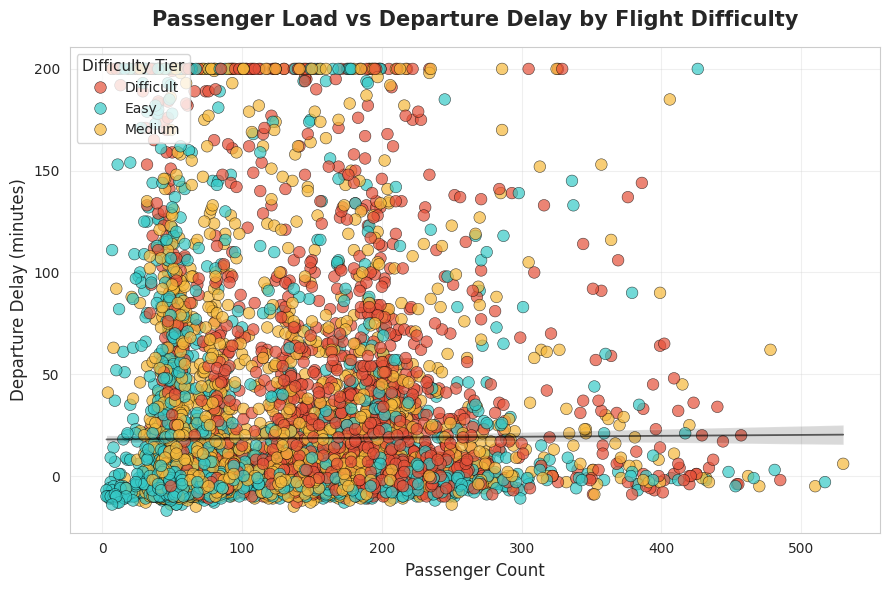

In [184]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

# Load the scored dataset
df = pd.read_csv("out/flights_scored.csv", low_memory=False)

# Auto-detect correct columns
def pick(df, *cands):
    for c in cands:
        if c in df.columns:
            return c
    return None

X = pick(df, "pax_booked", "total_pax", "pax_count")
Y = pick(df, "dep_delay_min", "departure_delay_minutes", "dep_delay")
H = pick(df, "difficulty_bucket", "tier")

if not X or not Y or not H:
    raise KeyError(f"Missing required columns — pax({X}), delay({Y}), tier({H}). "
                   f"Available: {df.columns.tolist()[:25]}")

# Clean numeric columns
df[X] = pd.to_numeric(df[X], errors="coerce")
df[Y] = pd.to_numeric(df[Y], errors="coerce")
df = df[np.isfinite(df[X]) & np.isfinite(df[Y]) & df[H].notna()]

# --- Plot ---
sns.set_style("whitegrid")
plt.figure(figsize=(9,6))

palette = {"Easy":"#36C9C6", "Medium":"#F6B93B", "Difficult":"#E55039"}

df[Y] = df[Y].clip(lower=-20, upper=200)

sns.scatterplot(
    x=X, y=Y, hue=H, data=df,
    palette=palette, s=70, alpha=0.7, edgecolor="black", linewidth=0.4
)

sns.regplot(x=X, y=Y, data=df, scatter=False, color="black",
            line_kws={"lw":1.3, "alpha":0.6})

plt.title("Passenger Load vs Departure Delay by Flight Difficulty", fontsize=15, weight="bold", pad=15)
plt.xlabel("Passenger Count", fontsize=12)
plt.ylabel("Departure Delay (minutes)", fontsize=12)
plt.legend(title="Difficulty Tier", fontsize=10, title_fontsize=11, loc="upper left", frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


feature eng graph

In [144]:
# STEP 1 — Load data and prepare columns
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

PATH = "out/flights_scored.csv"
if not os.path.exists(PATH):
    from google.colab import files
    print("⚠️ Please upload flights_scored.csv")
    uploaded = files.upload()
    PATH = list(uploaded.keys())[0]

df = pd.read_csv(PATH, low_memory=False)
print("✅ Loaded:", len(df), "rows")

# Define key feature groups
num_feats = [c for c in [
    "bags_per_min","pax_per_min","transfer_ratio",
    "ssr_per_100pax","turn_minutes","minimum_turn_minutes","turn_buffer"
] if c in df.columns]
bin_feats = [c for c in ["is_tight_turn","is_international"] if c in df.columns]

# Key outcome columns
C_DELAY = next((c for c in ["dep_delay_min","departure_delay_minutes","dep_delay"] if c in df.columns), None)
C_TIER  = next((c for c in ["difficulty_bucket","tier"] if c in df.columns), None)
C_SCORE = next((c for c in ["difficulty_score","FDS"] if c in df.columns), None)

for c in num_feats + bin_feats + [C_DELAY] if C_DELAY else []:
    df[c] = pd.to_numeric(df[c], errors="coerce")

print("Numeric features:", num_feats)
print("Binary features:", bin_feats)


✅ Loaded: 8099 rows
Numeric features: ['bags_per_min', 'pax_per_min', 'transfer_ratio', 'ssr_per_100pax', 'turn_minutes', 'minimum_turn_minutes', 'turn_buffer']
Binary features: ['is_tight_turn', 'is_international']


/tmp/ipython-input-2092689955.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="viridis")
/tmp/ipython-input-2092689955.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, palette="viridis")


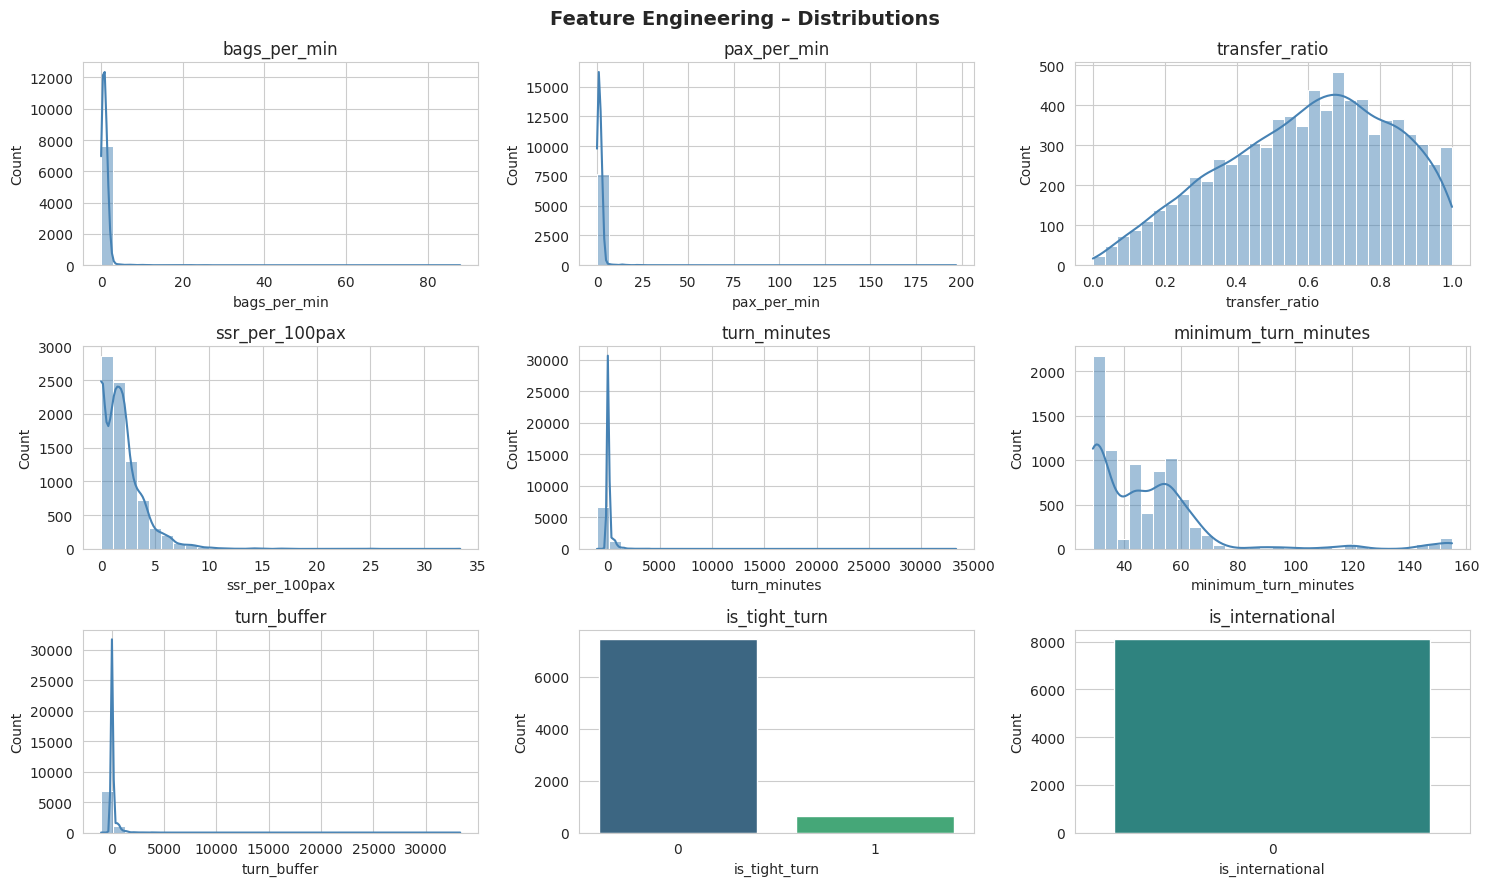

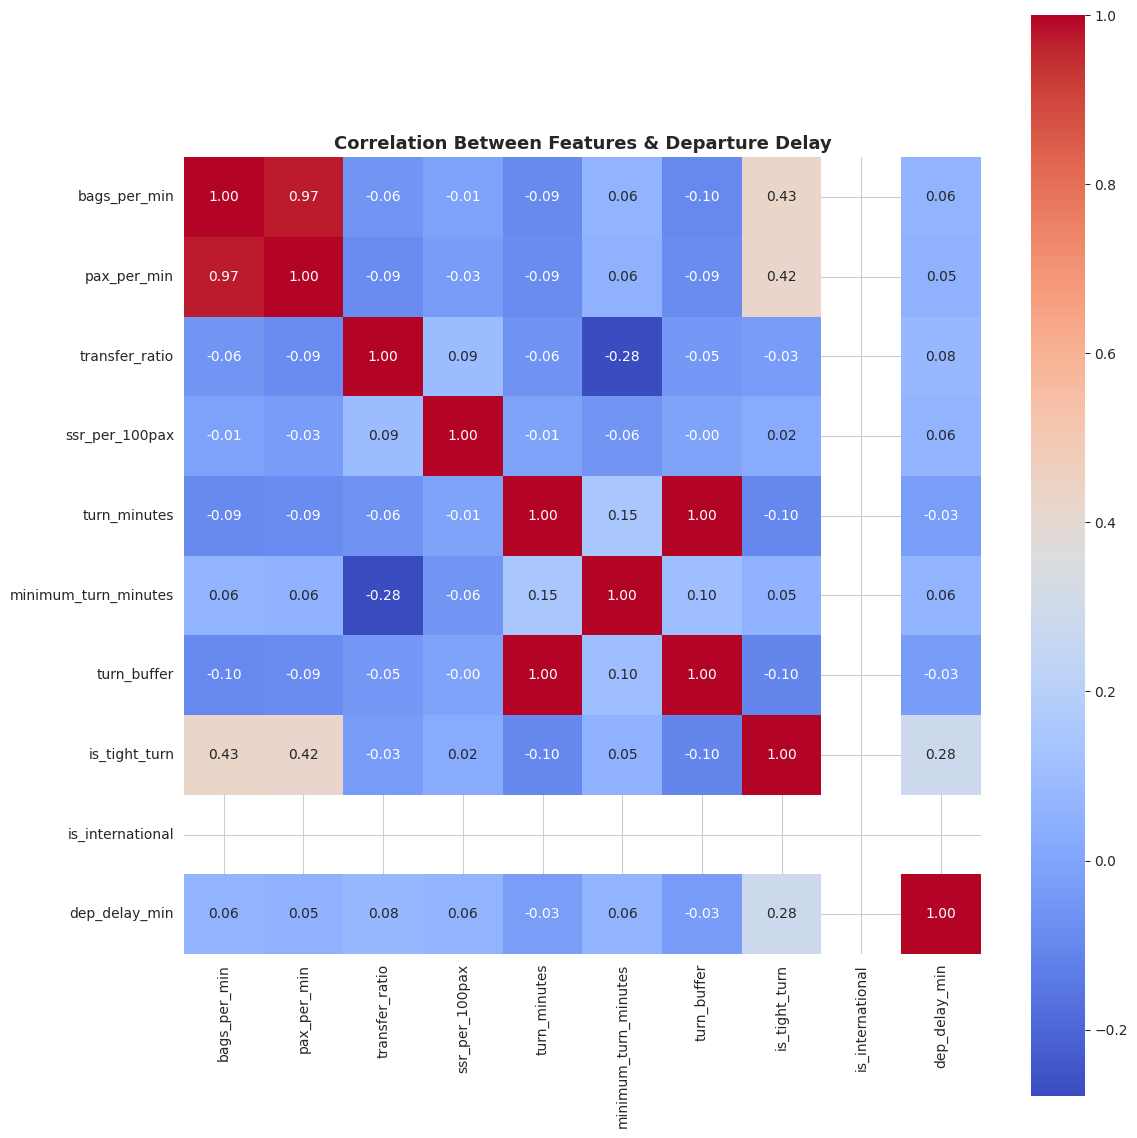

In [145]:
# STEP 2 — Feature distributions + correlation heatmap

# 1️⃣ Distribution overview
features = num_feats + bin_feats
if features:
    n, cols = len(features), 3
    rows = int(np.ceil(n/cols))
    plt.figure(figsize=(min(5*cols,18), max(3*rows,4)))
    for i,col in enumerate(features,1):
        plt.subplot(rows,cols,i)
        if col in bin_feats:
            sns.countplot(x=col, data=df, palette="viridis")
            plt.ylabel("Count")
        else:
            sns.histplot(df[col], kde=True, bins=30, color="steelblue")
        plt.title(col)
    plt.suptitle("Feature Engineering – Distributions", fontsize=14, weight="bold")
    plt.tight_layout()
    plt.show()

# 2️⃣ Correlation with departure delay
if C_DELAY:
    corr_cols = [*num_feats, *bin_feats, C_DELAY]
    corr = df[corr_cols].corr(numeric_only=True)
    plt.figure(figsize=(1.2*len(corr_cols), 1.2*len(corr_cols)))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Between Features & Departure Delay", fontsize=13, weight="bold")
    plt.tight_layout()
    plt.show()


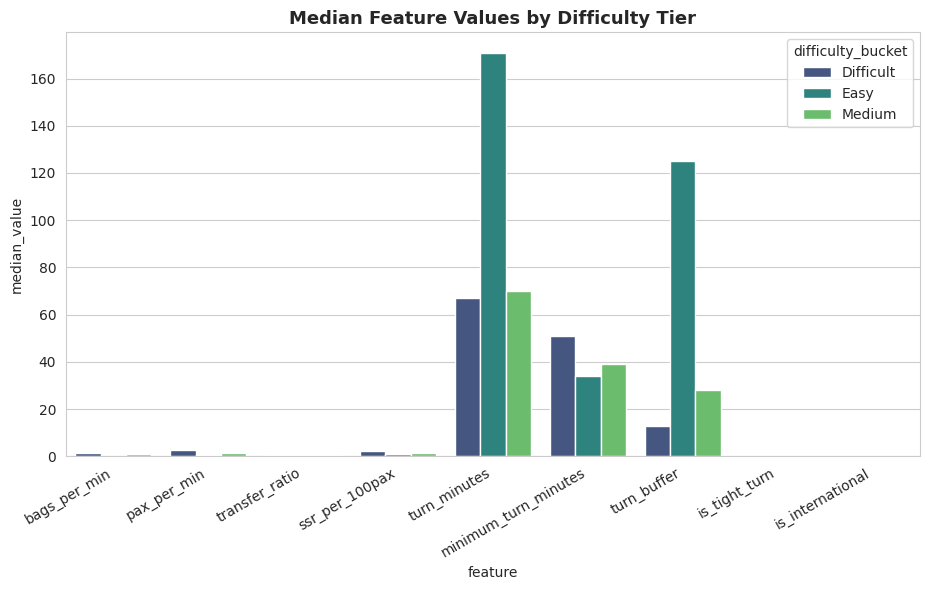

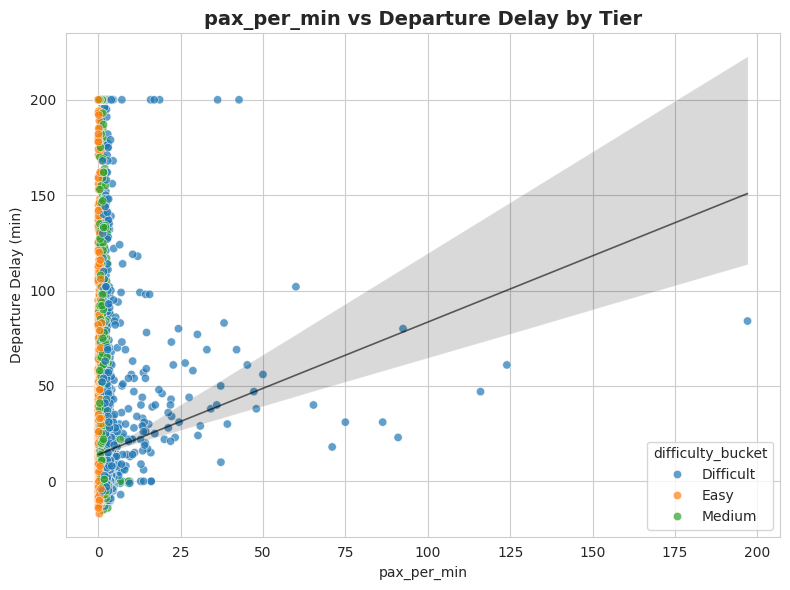

In [146]:
# STEP 3 — Tier contrast + scatter visualization

# 1️⃣ Feature medians by difficulty tier
if C_TIER and (num_feats or bin_feats):
    agg = df.groupby(C_TIER)[num_feats + bin_feats].median(numeric_only=True).reset_index()
    tall = agg.melt(id_vars=[C_TIER], var_name="feature", value_name="median_value")
    plt.figure(figsize=(min(0.6*len(tall.feature.unique())+4,18),6))
    sns.barplot(data=tall, x="feature", y="median_value", hue=C_TIER, palette="viridis")
    plt.title("Median Feature Values by Difficulty Tier", fontsize=13, weight="bold")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()

# 2️⃣ Passenger load vs delay (scatter)
X = next((c for c in ["pax_per_min","pax_booked","total_pax"] if c in df.columns), None)
Y = C_DELAY
if X and Y:
    vis = df[[X,Y,C_TIER]].dropna()
    vis[Y] = vis[Y].clip(-20,200)
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=X, y=Y, hue=C_TIER, data=vis, alpha=0.7)
    sns.regplot(x=X, y=Y, data=vis, scatter=False, color="black", line_kws={"lw":1.2,"alpha":0.6})
    plt.title(f"{X} vs Departure Delay by Tier", fontsize=14, weight="bold")
    plt.xlabel(X); plt.ylabel("Departure Delay (min)")
    plt.tight_layout()
    plt.show()


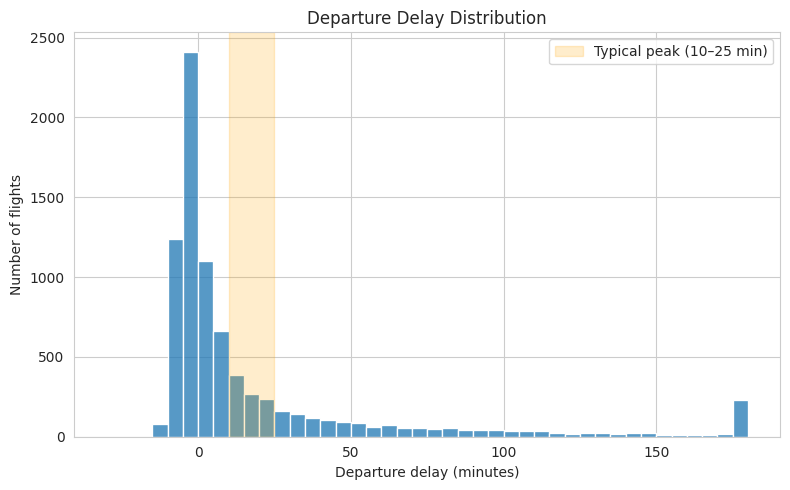

In [147]:
# === EDA Visuals: Histogram, Scatter, Heatmap ===
# Requirements: out/flights_scored.csv
# Libraries: pandas, numpy, matplotlib, seaborn

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Load ----------
PATH = "out/flights_scored.csv"
assert os.path.exists(PATH), f"Missing {PATH}. Run your scoring step first."
df = pd.read_csv(PATH, low_memory=False)

# ---------- Helper to pick first available column name ----------
def pick(df, *cands, required=False, label=""):
    for c in cands:
        if c in df.columns:
            return c
    if required:
        raise KeyError(f"[{label}] none of {cands} found. Have: {list(df.columns)[:25]} ...")
    return None

# Resolve columns robustly
COL_DELAY = pick(df, "dep_delay_min","departure_delay_minutes","dep_delay","delay_minutes", required=True, label="dep delay")
COL_PAX   = pick(df, "pax_booked","total_pax","pax_count","passenger_count", required=True, label="passenger load")
COL_TIER  = pick(df, "tier","difficulty_bucket","difficulty_tier", required=False)

# Coerce numeric
df[COL_DELAY] = pd.to_numeric(df[COL_DELAY], errors="coerce")
df[COL_PAX]   = pd.to_numeric(df[COL_PAX], errors="coerce")

# Trim rows used in plots
df_plot = df.replace([np.inf,-np.inf], np.nan).dropna(subset=[COL_DELAY, COL_PAX])

# ============= (A) HISTOGRAM: Departure delay =============
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
# clip extremes so the shape is readable (adjust as you like)
clip_delay = df_plot[COL_DELAY].clip(lower=-30, upper=180)
bins = np.arange(-30, 181, 5)  # 5-min bins
sns.histplot(clip_delay, bins=bins, kde=False)
plt.title("Departure Delay Distribution")
plt.xlabel("Departure delay (minutes)")
plt.ylabel("Number of flights")

# Highlight 10–25 mins band
ymax = plt.gca().get_ylim()[1]
plt.axvspan(10, 25, color="orange", alpha=0.2, label="Typical peak (10–25 min)")
plt.legend()
plt.tight_layout()
plt.show()


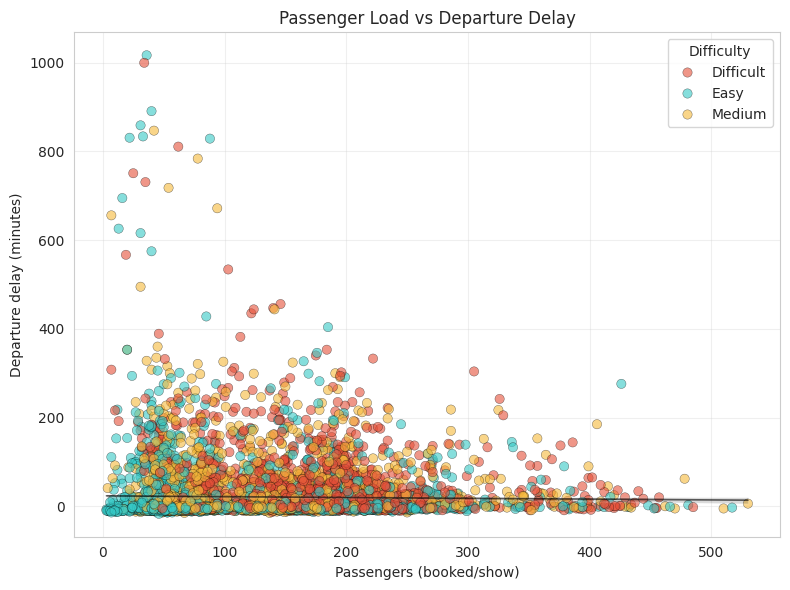

In [148]:
# ============= (B) SCATTER: Pax vs Delay, colored by tier =============
plt.figure(figsize=(8,6))
palette = {"Easy":"#36C9C6", "Medium":"#F6B93B", "Difficult":"#E55039"}
kwargs = dict(alpha=0.6, edgecolor="black", linewidth=0.3)

if COL_TIER and df_plot[COL_TIER].notna().any():
    sns.scatterplot(x=COL_PAX, y=COL_DELAY, hue=COL_TIER, data=df_plot, palette=palette, s=45, **kwargs)
    plt.legend(title="Difficulty")
else:
    sns.scatterplot(x=COL_PAX, y=COL_DELAY, data=df_plot, s=45, **kwargs)

# Optional trend line
sns.regplot(x=COL_PAX, y=COL_DELAY, data=df_plot, scatter=False, color="black", line_kws={"lw":1.2, "alpha":0.6})

plt.title("Passenger Load vs Departure Delay")
plt.xlabel("Passengers (booked/show)")
plt.ylabel("Departure delay (minutes)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


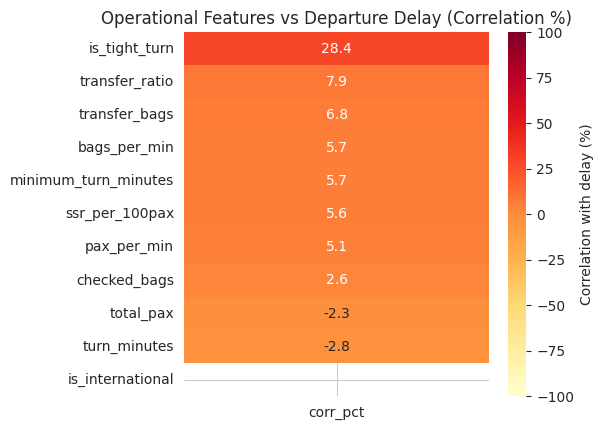

In [149]:
# ============= (C) HEATMAP: Feature ↔ Delay correlations =============
# Choose candidate operational features (include only those present)
candidates = [
    "bags_per_min","pax_per_min","transfer_ratio","ssr_per_100pax",
    "is_tight_turn","is_international","turn_minutes","minimum_turn_minutes",
    "checked_bags","transfer_bags","total_pax","pax_booked"
]
feats = [c for c in candidates if c in df.columns]

# Build correlation (Pearson) vs delay
corr_rows = []
for f in feats:
    v = pd.to_numeric(df[f], errors="coerce")
    mask = v.notna() & df[COL_DELAY].notna()
    if mask.sum() >= 10:  # need enough data points
        r = np.corrcoef(v[mask], df[COL_DELAY][mask])[0,1]
        corr_rows.append((f, r))

corr_df = pd.DataFrame(corr_rows, columns=["feature","corr_with_delay"]).sort_values("corr_with_delay", ascending=False)

# If nothing to plot, warn and skip
if corr_df.empty:
    print("Not enough overlapping data to compute correlations for heatmap.")
else:
    # Convert to % for display, pivot to 2D (features x one column)
    corr_df["corr_pct"] = (corr_df["corr_with_delay"] * 100).round(1)
    hm = corr_df.set_index("feature")[["corr_pct"]]

    plt.figure(figsize=(6, max(3, 0.4*len(hm))))
    ax = sns.heatmap(
        hm, annot=True, fmt=".1f",
        cmap="YlOrRd", vmin=-100, vmax=100, cbar_kws={"label":"Correlation with delay (%)"}
    )
    ax.set_title("Operational Features vs Departure Delay (Correlation %)")
    ax.set_xlabel("")  # cleaner
    ax.set_ylabel("")
    plt.tight_layout()
    plt.show()

Feature Engineering Framework  diagram

In [150]:
# Option 1: Flow diagram (Graphviz) → out/slide6_flow.png
!pip -q install graphviz
from graphviz import Digraph
import os

os.makedirs("out", exist_ok=True)

g = Digraph("FDS_Flow", format="png")
g.attr(rankdir="LR", bgcolor="white", nodesep="0.6", splines="spline")

styles = dict(shape="box", style="rounded,filled", fontname="Helvetica", fontsize="12", color="#2C3E50")
g.node("raw",  "Raw Data\n(Flights • PNR • Bags • Airports)", fillcolor="#D6EAF8", **styles)
g.node("feat", "Feature Extraction\n(bags/min, pax/min, SSR/100 pax…)", fillcolor="#D1F2EB", **styles)
g.node("norm", "Normalization\n(per-min • per-100 pax)", fillcolor="#FCF3CF", **styles)
g.node("wgt",  "Weighted Scoring\n(feature weights)", fillcolor="#FADBD8", **styles)
g.node("fds",  "FDS + Tiers\n(Easy • Medium • Difficult)", fillcolor="#E8DAEF", **styles)

g.edge("raw","feat")
g.edge("feat","norm")
g.edge("norm","wgt")
g.edge("wgt","fds")

png_path = g.render(filename="out/slide6_flow", cleanup=True)
print("Saved:", png_path)


Saved: out/slide6_flow.png


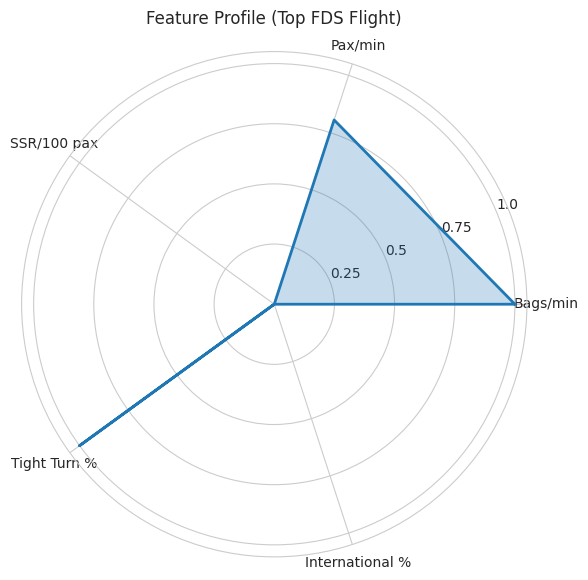

Saved: out/slide6_radar.png


In [151]:
# Option 2: Radar (Spider) chart → out/slide6_radar.png
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt

os.makedirs("out", exist_ok=True)
PATH = "out/flights_scored.csv"

# Load (fail fast with a clear hint)
assert os.path.exists(PATH), "Missing out/flights_scored.csv — run your scoring step first."
df = pd.read_csv(PATH, low_memory=False)

# Safe column picking
def pick(df, *cands):
    for c in cands:
        if c in df.columns: return c

cols = {
    "bags_per_min": pick(df, "bags_per_min"),
    "pax_per_min": pick(df, "pax_per_min"),
    "ssr_per_100pax": pick(df, "ssr_per_100pax"),
    "is_tight_turn": pick(df, "is_tight_turn"),
    "is_international": pick(df, "is_international"),
    "difficulty_score": pick(df, "difficulty_score","FDS")
}

need_missing = [k for k,v in cols.items() if v is None and k!="difficulty_score"]
assert not need_missing, f"Missing required columns: {need_missing}"

# Pick one representative flight (highest difficulty)
row = df.sort_values(cols["difficulty_score"], ascending=False).iloc[0]

# Build feature vector
vals_raw = [
    float(row[cols["bags_per_min"]]),
    float(row[cols["pax_per_min"]]),
    float(row[cols["ssr_per_100pax"]]),
    float(row[cols["is_tight_turn"]]) * 100.0,      # as %
    float(row[cols["is_international"]]) * 100.0    # as %
]
labels = ["Bags/min", "Pax/min", "SSR/100 pax", "Tight Turn %", "International %"]

# Normalize first three to 0–1 for fair radar shape (keep % on 0–100 scale, but divide to fit 0–1)
v1 = np.array(vals_raw[:3], dtype=float)
minv, maxv = np.nanmin(v1), np.nanmax(v1)
# robust min-max (avoid divide-by-zero)
v1n = (v1 - minv) / (maxv - minv) if np.isfinite(maxv - minv) and (maxv - minv) > 0 else np.zeros_like(v1)
v2n = np.array(vals_raw[3:]) / 100.0
vals = np.concatenate([v1n, v2n])

# Radar setup
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
vals = np.concatenate([vals, [vals[0]]])        # close the loop
angles = np.concatenate([angles, [angles[0]]])  # close the loop

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles, vals, linewidth=2)
ax.fill(angles, vals, alpha=0.25)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["0.25","0.5","0.75","1.0"])
title = f"Feature Profile (Top FDS Flight)"
ax.set_title(title, pad=20)
plt.tight_layout()
out_path = "out/slide6_radar.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)


/tmp/ipython-input-663613767.py:47: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-663613767.py:47: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-663613767.py:47: UserWarning: Glyph 129523 (\N{LUGGAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-663613767.py:47: UserWarning: Glyph 127757 (\N{EARTH GLOBE EUROPE-AFRICA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-663613767.py:49: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=200)
/tmp/ipython-input-663613767.py:49: UserWarning: Glyph 128101 (\N{BUSTS IN SILHOUETTE}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=200)
/tmp/ipython-input-663613767.py:49: UserWarning: Glyph 129523 (\N{LUGGAGE}) missing from font(s) DejaVu Sans.
  plt.savefig(out_path, dpi=200)
/tmp/

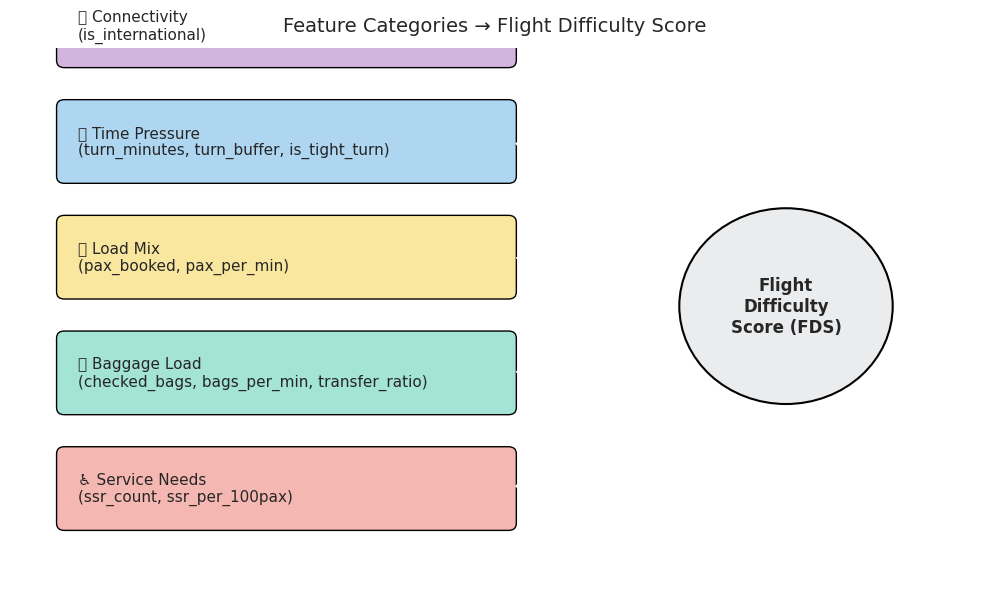

Saved: out/slide6_blocks.png


In [152]:
# Option 3: Color blocks → out/slide6_blocks.png
import os, matplotlib.pyplot as plt, matplotlib.patches as patches

os.makedirs("out", exist_ok=True)

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlim(0, 10)
ax.set_ylim(0, 6)
ax.axis("off")

# Boxes (left side)
blocks = [
    (0.5, 4.5, "⏱️ Time Pressure\n(turn_minutes, turn_buffer, is_tight_turn)", "#AED6F1"),
    (0.5, 3.2, "👥 Load Mix\n(pax_booked, pax_per_min)", "#F9E79F"),
    (0.5, 1.9, "🧳 Baggage Load\n(checked_bags, bags_per_min, transfer_ratio)", "#A3E4D7"),
    (0.5, 0.6, "♿ Service Needs\n(ssr_count, ssr_per_100pax)", "#F5B7B1"),
]
for x,y,text,color in blocks:
    rect = patches.FancyBboxPatch((x,y), 4.7, 0.9, boxstyle="round,pad=0.02,rounding_size=0.08",
                                  linewidth=1, edgecolor="black", facecolor=color)
    ax.add_patch(rect)
    ax.text(x+0.2, y+0.45, text, va="center", ha="left", fontsize=11)

# Right block (Connectivity)
rect = patches.FancyBboxPatch((0.5, 5.8), 4.7, 0.9, boxstyle="round,pad=0.02,rounding_size=0.08",
                              linewidth=1, edgecolor="black", facecolor="#D2B4DE")
ax.add_patch(rect)
ax.text(0.7, 6.25, "🌍 Connectivity\n(is_international)", va="center", ha="left", fontsize=11)

# Central FDS bubble
circle = patches.Circle((8.0, 3.1), 1.1, facecolor="#EAECEE", edgecolor="black", linewidth=1.5)
ax.add_patch(circle)
ax.text(8.0, 3.1, "Flight\nDifficulty\nScore (FDS)", va="center", ha="center", fontsize=12, weight="bold")

# Arrows from blocks → bubble
def arrow_from(x,y):
    ax.annotate("", xy=(6.9, 3.1), xytext=(x+4.7, y+0.45),
                arrowprops=dict(arrowstyle="->", lw=1.6))

arrow_from(0.5, 5.8)  # connectivity
arrow_from(0.5, 4.5)
arrow_from(0.5, 3.2)
arrow_from(0.5, 1.9)
arrow_from(0.5, 0.6)

ax.set_title("Feature Categories → Flight Difficulty Score", fontsize=14, pad=12)
plt.tight_layout()
out_path = "out/slide6_blocks.png"
plt.savefig(out_path, dpi=200)
plt.show()
print("Saved:", out_path)


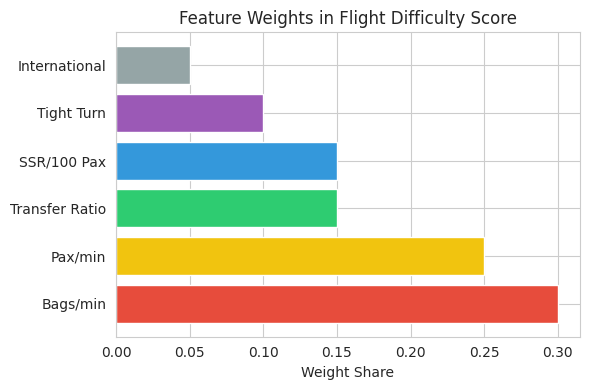

In [153]:
import matplotlib.pyplot as plt

weights = {
    "Bags/min":0.30,
    "Pax/min":0.25,
    "Transfer Ratio":0.15,
    "SSR/100 Pax":0.15,
    "Tight Turn":0.10,
    "International":0.05
}

plt.figure(figsize=(6,4))
plt.barh(list(weights.keys()), list(weights.values()), color=["#E74C3C","#F1C40F","#2ECC71","#3498DB","#9B59B6","#95A5A6"])
plt.title("Feature Weights in Flight Difficulty Score")
plt.xlabel("Weight Share")
plt.tight_layout()
plt.savefig("out/slide7_weights.png", dpi=200)
plt.show()


In [154]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs("out", exist_ok=True)

# Core inputs
scored_path = "out/flights_scored.csv"
dest_path   = "out/destinations_summary.csv"

scored = pd.read_csv(scored_path, low_memory=False)
dest   = pd.read_csv(dest_path,   low_memory=False)

print("Loaded:", scored.shape, dest.shape)


Loaded: (8099, 27) (188, 4)


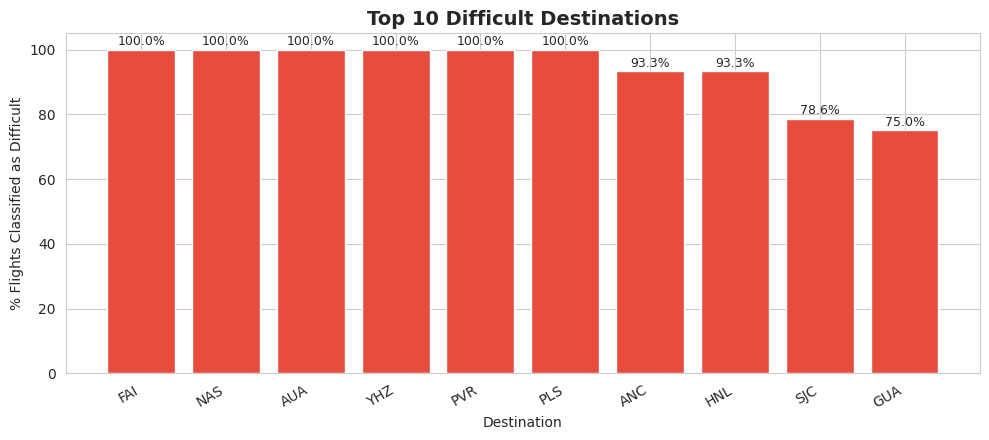

In [155]:
# Resolve column names
dest_col = "destination" if "destination" in dest.columns else dest.columns[0]
pct_col  = "pct_difficult" if "pct_difficult" in dest.columns else (
    next((c for c in dest.columns if "difficult" in c.lower() and "pct" in c.lower()), None)
)
assert pct_col, f"Couldn't find pct difficult column in {list(dest.columns)}"

top = dest.sort_values(pct_col, ascending=False).head(10)

plt.figure(figsize=(10,4.5))
bars = plt.bar(top[dest_col], top[pct_col], color="#E74C3C")
plt.title("Top 10 Difficult Destinations", fontsize=14, weight="bold")
plt.ylabel("% Flights Classified as Difficult")
plt.xlabel("Destination")
plt.xticks(rotation=30, ha="right")
for b in bars:
    v = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, v+0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=9)
plt.tight_layout()
plt.savefig("out/top10_difficult_destinations.png", dpi=200)
plt.show()


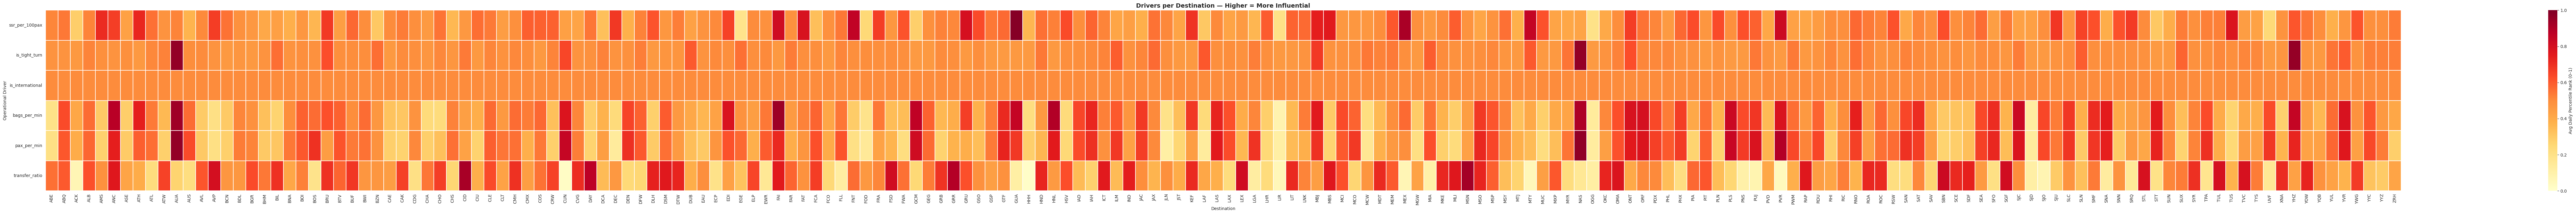

In [156]:
# Find driver rank columns like "_r_bags_per_min", "_r_pax_per_min", ...
driver_rank_cols = [c for c in scored.columns if c.startswith("_r_")]
assert driver_rank_cols, "No driver rank columns (_r_*) found. Make sure you saved _r_* columns in flights_scored.csv."

# Destination column
dest_scored_col = next((c for c in ["destination","scheduled_arrival_station_code","dest"] if c in scored.columns), None)
assert dest_scored_col, f"Destination column not found in scored: {list(scored.columns)[:30]}"

# Average rank (0..1) per destination & driver
long = scored[[dest_scored_col] + driver_rank_cols].copy()
long = long.melt(id_vars=[dest_scored_col], var_name="driver", value_name="rank_pct")
long["driver"] = long["driver"].str.replace(r"^_r_", "", regex=True)

heat = (long.groupby([dest_scored_col,"driver"], as_index=False)["rank_pct"]
             .mean()
             .pivot(index="driver", columns=dest_scored_col, values="rank_pct"))

# Optionally sort drivers by overall mean rank
heat = heat.loc[heat.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(max(8, 0.5*heat.shape[1]+4), 5 + 0.35*heat.shape[0]))
sns.heatmap(heat, cmap="YlOrRd", vmin=0, vmax=1, linewidths=.3, linecolor="white",
            cbar_kws={"label":"Avg Daily Percentile Rank (0–1)"})
plt.title("Drivers per Destination — Higher = More Influential", fontsize=14, weight="bold")
plt.xlabel("Destination")
plt.ylabel("Operational Driver")
plt.tight_layout()
plt.savefig("out/heatmap_drivers_by_destination.png", dpi=220)
plt.show()


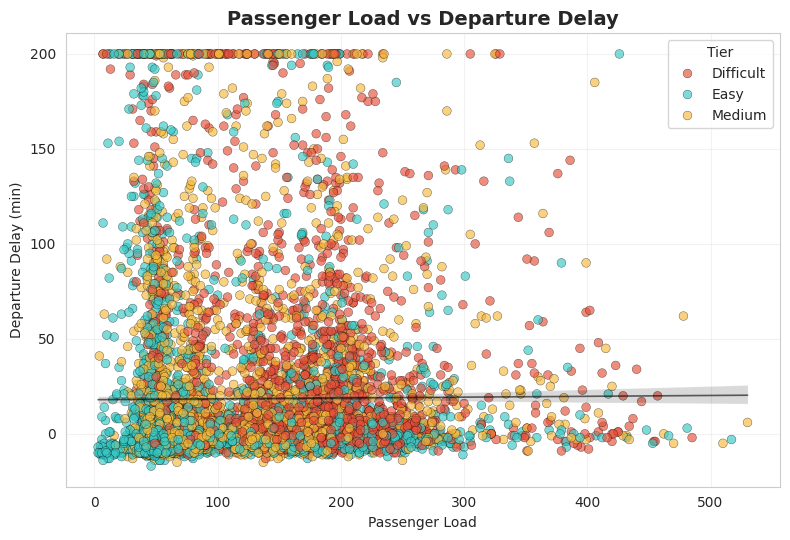

In [157]:
# Resolve columns (robust)
def pick(df, *cands):
    return next((c for c in cands if c in df.columns), None)

X = pick(scored, "pax_booked","total_pax","pax_count","passengers")
Y = pick(scored, "dep_delay_min","departure_delay_minutes","dep_delay","delay_minutes")
H = pick(scored, "tier","difficulty_bucket")

if X is None or Y is None:
    raise KeyError(f"Missing required columns for scatter. Have: {list(scored.columns)[:30]}")

viz = scored[[X,Y] + ([H] if H else [])].copy()
viz[X] = pd.to_numeric(viz[X], errors="coerce")
viz[Y] = pd.to_numeric(viz[Y], errors="coerce")
viz = viz.replace([np.inf,-np.inf], np.nan).dropna(subset=[X,Y])

# Clip extreme delays for visibility
viz[Y] = viz[Y].clip(lower=-20, upper=200)

plt.figure(figsize=(8,5.5))
if H:
    palette = {"Easy":"#36C9C6","Medium":"#F6B93B","Difficult":"#E55039"}
    sns.scatterplot(x=X, y=Y, hue=H, data=viz, palette=palette, alpha=0.65, s=40, edgecolor="black", linewidth=0.3)
    plt.legend(title="Tier", frameon=True)
else:
    sns.scatterplot(x=X, y=Y, data=viz, alpha=0.65, s=40, edgecolor="black", linewidth=0.3)

sns.regplot(x=X, y=Y, data=viz, scatter=False, color="black", line_kws={"lw":1.2, "alpha":0.6})

plt.title("Passenger Load vs Departure Delay", fontsize=14, weight="bold")
plt.xlabel("Passenger Load")
plt.ylabel("Departure Delay (min)")
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.savefig("out/scatter_pax_vs_delay_by_tier.png", dpi=200)
plt.show()
